Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  47.65 s
2: Total numb steps is  609


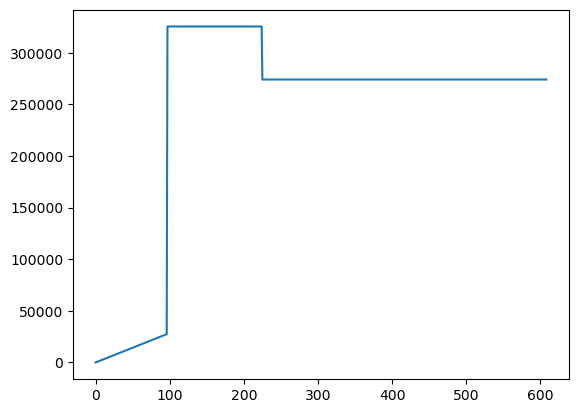

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions


# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 224
v_vehicle = 160
c_acc = 1

def vehicle_initial(angular_r, v_vehicle, c_contact, c_acc):
    import numpy as np
    # v_ini  =  raad/ss
    v_ini = v_vehicle/3.6   /   (920/2/1000) 
    # D_wheel = 920 mm, v = D_wheel /2 /1000 * v_ini *3.6   # km/h
    # Start time, Final time  
    t = 0
    t_brake = 49
    t_lag1 = 4
    t_lag2 = 6
    # rubbing element radius, Contact area 
    r_rub = 18.8
    S_rub_circle = r_rub**2 * c_contact
    S_total = S_rub_circle * np.pi * 18  #mm2
    # initial and brake pad temperature
    Ti = 60
    Tm = 60
    # density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
    t_u = 1e3 # m to mm
    rho = 7850 /(t_u**3)
    c = 462
    k = 48 / t_u
    # mu, P_brake,  r_disc , heat_distribution  
    mu = 0.376
    P_initial = 274000
    r_disc = 0.25
    heat_distribution = 0.88
    # calculate total num_steps
    if c_acc == 1:  # constant acc for the whole process
        acc = v_ini/t_brake
        # end velocity, km/h
        v_lag_end1 = (v_ini - (acc *t_lag1) )  
        v_lag_end2 = (v_ini - (acc *(t_lag1+t_lag2) ) )

        # angular speed, rad/s
        angular_r_rad = angular_r / 180 *np.pi  

        # lag time for period 1 and 2
        dt_lag1 = angular_r_rad  /  ( ( v_ini + v_lag_end1  ) /2 )
        dt_lag2 = angular_r_rad  /  ( ( v_lag_end1 + v_lag_end2  ) /2 )

        # lag steps for period 1 and 2
        n_lag1 = round (t_lag1 / dt_lag1) + 1 
        n_lag2 = round (t_lag2 / dt_lag2) + 1

        # every second, the rotation angular divide average speed, then know the average dt.
        dt_a_lag2 = angular_r_rad  /  ( v_lag_end2 /2 )
        
        n_a_lag =  round ( (t_brake - t_lag1 - t_lag2) / dt_a_lag2 )+ 1
        
        num_steps = n_lag1 + n_lag2 + n_a_lag
        dt = []
        v_angular = [v_ini]
        for i in range(num_steps):
            dt.append ( angular_r_rad / v_angular[i] )
            v_angular.append (  v_ini- sum(dt) * acc )           
        P = []
        for i in range(num_steps):
            if i <= n_lag1:
                # linear pressure increase * 10%
                P.append( P_initial/ n_lag1 * (i * 0.1) )
            elif n_lag1 < i <= (n_lag1 + n_lag2):
                # heat lost in lag1 is added on lag2, 50%, should be 90% here
                P.append( P_initial * (1+ n_lag1 / (2 * n_lag2)* 0.5 ) ) 
            else:
                P.append( P_initial) 
    # S_or is the original brake pad rubbing area, 200 cm2. 
    S_or = 200
    S_new = S_total/100 #mm2 to cm2
    # g is the heat source,unit is w/mm2 
    g = []
    for i in range(num_steps):
        g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )
        
    #  h is the heat convection coefficient, unit is W/mm2 K  
    h = 7.75e-5
    # radiation is the radiation heat coefficient, unit is W/mm2 K
    # stefan-Boltzmann constant theta = 5.67*10e-8 w/m2 k-4,   0.64 is the emmissivity
    radiation = 5.670*(10e-8)/(t_u**2)  * 0.64

    return dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total,n_lag1,n_lag2,n_a_lag
    
# calling local functions to get all parameters
( dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c, k, t_brake,S_total,n_lag1,n_lag2,n_a_lag) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)



plt.plot(P)



In [3]:
print(n_lag1)
print(n_lag2)
print(n_a_lag)
from disc_f import *

96
128
385


## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2, 'tetr')
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    # before 2024/5/16
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-09-09 23:15:47.645 (   4.957s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:47.713 (   5.024s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:47.732 (   5.043s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0439124 (tol = 1e-10) r (rel) = 7.05842e-06(tol = 1e-06)
2024-09-09 23:15:47.754 (   5.066s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:47.777 (   5.090s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.91701e-07 (tol = 1e-10) r (rel) = 3.08138e-11(tol = 1e-06)
2024-09-09 23:15:47.779 (   5.090s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


## 5: Solution


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-2

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 224 degree. 2: Current time is 0.0 s. 3: Completion is 0.1 %. 

2024-09-09 23:15:50.939 (   8.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:50.939 (   8.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:50.940 (   8.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:50.940 (   8.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:50.940 (   8.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:50.940 (   8.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:50.940 (   8.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:50.941 (   8.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.1 %. 

2024-09-09 23:15:51.989 (   9.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:51.989 (   9.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:51.990 (   9.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:51.990 (   9.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:51.995 (   9.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:52.012 (   9.324s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:52.050 (   9.361s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:52.138 (   9.449s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-09-09 23:15:52.377 (   9.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:52.378 (   9.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:52.378 (   9.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:52.378 (   9.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:52.379 (   9.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:52.379 (   9.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:52.379 (   9.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:52.379 (   9.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.2 %. 

2024-09-09 23:15:53.327 (  10.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:53.327 (  10.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:53.329 (  10.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:53.329 (  10.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:53.332 (  10.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:53.352 (  10.664s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:53.392 (  10.703s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:53.491 (  10.802s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 672 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-09-09 23:15:53.604 (  10.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:53.605 (  10.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:53.605 (  10.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:53.605 (  10.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:53.606 (  10.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:53.606 (  10.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:53.606 (  10.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:53.606 (  10.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.2 %. 

2024-09-09 23:15:54.552 (  11.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:54.552 (  11.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:54.554 (  11.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:54.554 (  11.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:54.557 (  11.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:54.576 (  11.887s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:54.607 (  11.920s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:54.674 (  11.986s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 896 degree. 2: Current time is 0.2 s. 3: Completion is 0.3 %. 

2024-09-09 23:15:54.690 (  12.001s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.61718e-06 (tol = 1e-10) r (rel) = 5.09905e-06(tol = 0.01)
2024-09-09 23:15:54.690 (  12.002s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:15:54.691 (  12.002s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:15:54.801 (  12.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:54.802 (  12.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:54.802 (  12.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:54.802 (  12.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 0.3 %. 

2024-09-09 23:15:55.679 (  12.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:55.679 (  12.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:55.680 (  12.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:55.681 (  12.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:55.687 (  12.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:55.706 (  13.017s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:55.749 (  13.060s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:55.920 (  13.231s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1120 degree. 2: Current time is 0.2 s. 3: Completion is 0.4 %. 

2024-09-09 23:15:55.944 (  13.255s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 4.36258e-06 (tol = 1e-10) r (rel) = 5.62043e-06(tol = 0.01)
2024-09-09 23:15:55.944 (  13.256s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:15:55.944 (  13.256s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:15:56.046 (  13.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:56.046 (  13.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:56.047 (  13.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:56.047 (  13.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 0.4 %. 

2024-09-09 23:15:57.001 (  14.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:57.002 (  14.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:57.002 (  14.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:57.003 (  14.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:57.007 (  14.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:57.021 (  14.333s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:57.057 (  14.369s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:57.142 (  14.453s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1344 degree. 2: Current time is 0.2 s. 3: Completion is 0.5 %. 

2024-09-09 23:15:57.161 (  14.473s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:15:57.162 (  14.473s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:15:57.251 (  14.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:57.252 (  14.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:57.252 (  14.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:57.252 (  14.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:57.253 (  14.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:57.253 (  14.564s) [main            ]topol

1: Rotation has applied for 1568 degree. 2: Current time is 0.3 s. 3: Completion is 0.6 %. 

2024-09-09 23:15:58.156 (  15.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:58.157 (  15.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:58.158 (  15.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:58.158 (  15.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:58.162 (  15.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:58.180 (  15.492s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:58.221 (  15.532s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:58.286 (  15.597s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 0.6 %. 

2024-09-09 23:15:59.341 (  16.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:59.341 (  16.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:59.341 (  16.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:59.342 (  16.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:15:59.346 (  16.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:15:59.361 (  16.673s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:15:59.399 (  16.711s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:15:59.560 (  16.871s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1792 degree. 2: Current time is 0.3 s. 3: Completion is 0.7 %. 

2024-09-09 23:15:59.671 (  16.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:59.671 (  16.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:59.671 (  16.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:59.672 (  16.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:59.673 (  16.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:59.673 (  16.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:15:59.674 (  16.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:15:59.674 (  16.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.7 %. 

2024-09-09 23:16:00.615 (  17.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:00.615 (  17.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:00.617 (  17.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:00.617 (  17.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:00.622 (  17.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:00.637 (  17.948s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:00.669 (  17.980s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 2016 degree. 2: Current time is 0.4 s. 3: Completion is 0.7 %. 

2024-09-09 23:16:00.833 (  18.145s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:00.854 (  18.166s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.23068e-05 (tol = 1e-10) r (rel) = 4.85643e-06(tol = 0.01)
2024-09-09 23:16:00.854 (  18.166s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:00.855 (  18.166s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:00.938 (  18.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:00.938 (  18.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:00.938 (  18.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 0.7 %. 

2024-09-09 23:16:01.778 (  19.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:01.778 (  19.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:01.783 (  19.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:01.800 (  19.111s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:01.850 (  19.161s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:01.941 (  19.252s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:01.959 (  19.270s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.51472e-06 (tol = 1e-10) r (rel) = 5.48456e-06(tol = 0.01)
2024-09-09 23:16:01.959 (  19.270s

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-09-09 23:16:02.059 (  19.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:02.060 (  19.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:02.060 (  19.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:02.060 (  19.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:02.060 (  19.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:02.060 (  19.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:02.061 (  19.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:02.061 (  19.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 2464 degree. 2: Current time is 0.4 s. 3: Completion is 0.9 %. 

2024-09-09 23:16:02.992 (  20.304s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:03.096 (  20.408s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:03.123 (  20.434s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.08242e-05 (tol = 1e-10) r (rel) = 5.57822e-06(tol = 0.01)
2024-09-09 23:16:03.123 (  20.435s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:03.123 (  20.435s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:03.224 (  20.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:03.225 (  20.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0)

1: Completion is 0.9 %. 

2024-09-09 23:16:04.237 (  21.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:04.237 (  21.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:04.242 (  21.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:04.242 (  21.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:04.245 (  21.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:04.262 (  21.574s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:04.302 (  21.613s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:04.406 (  21.717s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2688 degree. 2: Current time is 0.5 s. 3: Completion is 1.0 %. 

2024-09-09 23:16:04.545 (  21.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:04.547 (  21.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:04.548 (  21.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:04.549 (  21.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:04.549 (  21.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:04.549 (  21.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:04.550 (  21.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:04.550 (  21.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.0 %. 

2024-09-09 23:16:05.457 (  22.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:05.457 (  22.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:05.458 (  22.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:05.458 (  22.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:05.460 (  22.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:05.477 (  22.789s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:05.513 (  22.828s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:05.596 (  22.907s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2912 degree. 2: Current time is 0.5 s. 3: Completion is 1.1 %. 

2024-09-09 23:16:05.707 (  23.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:05.707 (  23.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:05.708 (  23.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:05.708 (  23.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:05.708 (  23.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:05.708 (  23.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:05.709 (  23.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:05.709 (  23.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.1 %. 

2024-09-09 23:16:06.627 (  23.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:06.627 (  23.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:06.629 (  23.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:06.629 (  23.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:06.634 (  23.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:06.651 (  23.962s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:06.689 (  24.001s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:06.766 (  24.078s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3136 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-09-09 23:16:06.879 (  24.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:06.880 (  24.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:06.880 (  24.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:06.880 (  24.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:06.880 (  24.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:06.880 (  24.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:06.881 (  24.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:06.881 (  24.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.2 %. 

2024-09-09 23:16:07.781 (  25.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:07.781 (  25.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:07.782 (  25.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:07.782 (  25.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:07.786 (  25.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:07.801 (  25.113s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:07.840 (  25.151s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:08.002 (  25.313s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3360 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-09-09 23:16:08.097 (  25.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:08.098 (  25.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:08.098 (  25.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:08.106 (  25.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:08.106 (  25.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:08.106 (  25.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:08.107 (  25.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:08.108 (  25.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.2 %. 

2024-09-09 23:16:09.011 (  26.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:09.011 (  26.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:09.011 (  26.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:09.012 (  26.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:09.016 (  26.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:09.031 (  26.342s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:09.067 (  26.379s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:09.139 (  26.451s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3584 degree. 2: Current time is 0.7 s. 3: Completion is 1.3 %. 

2024-09-09 23:16:09.163 (  26.474s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:09.262 (  26.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:09.262 (  26.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:09.262 (  26.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:09.263 (  26.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:09.263 (  26.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:09.263 (  26.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:09.263 (  26.575s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 1.3 %. 

2024-09-09 23:16:10.148 (  27.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:10.148 (  27.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:10.149 (  27.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:10.150 (  27.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:10.153 (  27.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:10.170 (  27.481s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:10.202 (  27.514s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:10.274 (  27.585s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3808 degree. 2: Current time is 0.7 s. 3: Completion is 1.4 %. 

2024-09-09 23:16:10.388 (  27.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:10.389 (  27.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:10.389 (  27.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:10.389 (  27.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:10.390 (  27.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:10.390 (  27.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:10.390 (  27.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:10.391 (  27.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.4 %. 

2024-09-09 23:16:11.270 (  28.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:11.270 (  28.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:11.272 (  28.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:11.272 (  28.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:11.279 (  28.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:11.298 (  28.610s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:11.336 (  28.647s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:11.403 (  28.721s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4032 degree. 2: Current time is 0.7 s. 3: Completion is 1.5 %. 

2024-09-09 23:16:11.525 (  28.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:11.526 (  28.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:11.526 (  28.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:11.526 (  28.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:11.527 (  28.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:11.527 (  28.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:11.528 (  28.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:11.528 (  28.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 4256 degree. 2: Current time is 0.8 s. 3: Completion is 1.6 %. 

2024-09-09 23:16:12.364 (  29.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:12.364 (  29.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:12.366 (  29.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:12.366 (  29.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:12.378 (  29.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:12.398 (  29.709s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:12.433 (  29.745s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:12.505 (  29.816s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 1.6 %. 

2024-09-09 23:16:13.524 (  30.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:13.524 (  30.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:13.525 (  30.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:13.525 (  30.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:13.529 (  30.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:13.552 (  30.863s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:13.589 (  30.900s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:13.658 (  30.971s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 1.7 %. 

2024-09-09 23:16:13.780 (  31.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:13.781 (  31.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:13.781 (  31.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:13.781 (  31.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:13.781 (  31.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:13.781 (  31.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:13.783 (  31.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:13.783 (  31.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.7 %. 

2024-09-09 23:16:14.680 (  31.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:14.680 (  31.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:14.682 (  31.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:14.682 (  31.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:14.685 (  31.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:14.701 (  32.012s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:14.736 (  32.048s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:14.843 (  32.167s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4704 degree. 2: Current time is 0.9 s. 3: Completion is 1.7 %. 

2024-09-09 23:16:15.004 (  32.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:15.005 (  32.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:15.005 (  32.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:15.005 (  32.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:15.006 (  32.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:15.006 (  32.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:15.007 (  32.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:15.007 (  32.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.7 %. 

2024-09-09 23:16:15.935 (  33.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:15.935 (  33.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:15.936 (  33.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:15.937 (  33.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:15.940 (  33.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:15.958 (  33.269s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:15.997 (  33.308s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:16.088 (  33.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4928 degree. 2: Current time is 0.9 s. 3: Completion is 1.8 %. 

2024-09-09 23:16:16.227 (  33.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:16.228 (  33.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:16.228 (  33.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:16.229 (  33.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:16.229 (  33.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:16.229 (  33.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:16.230 (  33.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:16.230 (  33.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.8 %. 

2024-09-09 23:16:17.137 (  34.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:17.140 (  34.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:17.141 (  34.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:17.141 (  34.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:17.145 (  34.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:17.162 (  34.473s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:17.200 (  34.513s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:17.298 (  34.619s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5152 degree. 2: Current time is 0.9 s. 3: Completion is 1.9 %. 

2024-09-09 23:16:17.430 (  34.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:17.431 (  34.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:17.431 (  34.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:17.431 (  34.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:17.434 (  34.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:17.434 (  34.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:17.434 (  34.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:17.435 (  34.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.9 %. 

2024-09-09 23:16:18.320 (  35.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:18.320 (  35.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:18.322 (  35.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:18.322 (  35.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:18.326 (  35.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:18.347 (  35.658s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:18.383 (  35.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:18.469 (  35.780s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5376 degree. 2: Current time is 1.0 s. 3: Completion is 2.0 %. 

2024-09-09 23:16:18.586 (  35.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:18.587 (  35.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:18.587 (  35.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:18.587 (  35.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:18.587 (  35.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:18.588 (  35.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:18.588 (  35.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:18.588 (  35.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.0 %. 

2024-09-09 23:16:19.482 (  36.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:19.482 (  36.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:19.484 (  36.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:19.484 (  36.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:19.487 (  36.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:19.504 (  36.816s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:19.539 (  36.850s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:19.647 (  36.959s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5600 degree. 2: Current time is 1.0 s. 3: Completion is 2.1 %. 

2024-09-09 23:16:19.759 (  37.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:19.761 (  37.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:19.761 (  37.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:19.761 (  37.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:19.761 (  37.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:19.761 (  37.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:19.761 (  37.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:19.762 (  37.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.1 %. 

2024-09-09 23:16:20.669 (  37.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:20.669 (  37.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:20.670 (  37.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:20.670 (  37.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:20.675 (  37.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:20.691 (  38.003s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:20.723 (  38.035s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:20.804 (  38.115s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5824 degree. 2: Current time is 1.1 s. 3: Completion is 2.2 %. 

2024-09-09 23:16:20.915 (  38.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:20.916 (  38.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:20.916 (  38.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:20.916 (  38.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:20.917 (  38.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:20.917 (  38.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:20.920 (  38.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:20.920 (  38.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.2 %. 

2024-09-09 23:16:21.802 (  39.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:21.802 (  39.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:21.803 (  39.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:21.803 (  39.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:21.807 (  39.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:21.823 (  39.135s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:21.860 (  39.171s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:21.927 (  39.252s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6048 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-09-09 23:16:22.063 (  39.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:22.064 (  39.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:22.064 (  39.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:22.064 (  39.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:22.064 (  39.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:22.064 (  39.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:22.064 (  39.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:22.065 (  39.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.3 %. 

2024-09-09 23:16:22.962 (  40.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:22.963 (  40.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:22.964 (  40.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:22.964 (  40.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:22.967 (  40.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:22.984 (  40.295s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:23.023 (  40.334s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:23.103 (  40.414s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6272 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-09-09 23:16:23.230 (  40.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:23.232 (  40.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:23.232 (  40.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:23.232 (  40.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:23.232 (  40.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:23.232 (  40.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:23.233 (  40.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:23.233 (  40.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.3 %. 

2024-09-09 23:16:24.164 (  41.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:24.166 (  41.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:24.167 (  41.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:24.168 (  41.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:24.171 (  41.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:24.186 (  41.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:24.222 (  41.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:24.374 (  41.686s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6496 degree. 2: Current time is 1.2 s. 3: Completion is 2.4 %. 

2024-09-09 23:16:24.492 (  41.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:24.492 (  41.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:24.492 (  41.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:24.492 (  41.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:24.493 (  41.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:24.493 (  41.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:24.493 (  41.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:24.493 (  41.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.4 %. 

2024-09-09 23:16:25.362 (  42.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:25.362 (  42.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:25.363 (  42.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:25.363 (  42.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:25.367 (  42.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:25.384 (  42.695s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:25.426 (  42.737s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 6720 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-09-09 23:16:25.582 (  42.894s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:25.608 (  42.919s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 4.3121e-05 (tol = 1e-10) r (rel) = 4.76754e-06(tol = 0.01)
2024-09-09 23:16:25.608 (  42.919s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:25.608 (  42.920s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:25.707 (  43.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:25.707 (  43.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:25.707 (  43.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 2.5 %. 

2024-09-09 23:16:26.599 (  43.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:26.599 (  43.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:26.600 (  43.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:26.600 (  43.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:26.604 (  43.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:26.610 (  43.922s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:26.656 (  43.967s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:26.720 (  44.031s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6944 degree. 2: Current time is 1.3 s. 3: Completion is 2.6 %. 

2024-09-09 23:16:26.844 (  44.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:26.844 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:26.844 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:26.844 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:26.845 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:26.845 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:26.845 (  44.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:26.845 (  44.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.6 %. 

2024-09-09 23:16:27.788 (  45.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:27.788 (  45.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:27.790 (  45.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:27.790 (  45.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:27.794 (  45.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:27.809 (  45.120s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:27.843 (  45.154s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 7168 degree. 2: Current time is 1.3 s. 3: Completion is 2.7 %. 

2024-09-09 23:16:28.422 (  45.733s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:28.440 (  45.752s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.31524e-05 (tol = 1e-10) r (rel) = 5.47301e-06(tol = 0.01)
2024-09-09 23:16:28.440 (  45.752s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:28.440 (  45.752s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:28.537 (  45.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:28.537 (  45.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:28.537 (  45.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 2.7 %. 

2024-09-09 23:16:29.360 (  46.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:29.360 (  46.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:29.361 (  46.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:29.366 (  46.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:29.374 (  46.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:29.397 (  46.709s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:29.438 (  46.749s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:29.529 (  46.841s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7392 degree. 2: Current time is 1.4 s. 3: Completion is 2.8 %. 

2024-09-09 23:16:29.650 (  46.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:29.650 (  46.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:29.651 (  46.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:29.651 (  46.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:29.651 (  46.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:29.651 (  46.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:29.651 (  46.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:29.652 (  46.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.8 %. 

2024-09-09 23:16:30.547 (  47.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:30.550 (  47.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:30.551 (  47.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:30.552 (  47.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:30.556 (  47.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:30.570 (  47.882s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:30.603 (  47.914s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 7616 degree. 2: Current time is 1.4 s. 3: Completion is 2.8 %. 

2024-09-09 23:16:30.845 (  48.156s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:30.865 (  48.176s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.48097e-05 (tol = 1e-10) r (rel) = 5.61813e-06(tol = 0.01)
2024-09-09 23:16:30.865 (  48.176s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:30.865 (  48.176s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:30.963 (  48.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:30.964 (  48.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:30.964 (  48.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 2.8 %. 

2024-09-09 23:16:31.860 (  49.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:31.860 (  49.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:31.863 (  49.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:31.863 (  49.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:31.866 (  49.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:31.883 (  49.195s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:31.922 (  49.233s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:31.991 (  49.303s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7840 degree. 2: Current time is 1.4 s. 3: Completion is 2.9 %. 

2024-09-09 23:16:32.109 (  49.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:32.110 (  49.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:32.110 (  49.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:32.110 (  49.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:32.111 (  49.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:32.111 (  49.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:32.111 (  49.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:32.111 (  49.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.9 %. 

2024-09-09 23:16:32.981 (  50.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:32.981 (  50.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:32.983 (  50.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:32.983 (  50.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:32.987 (  50.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:33.003 (  50.314s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:33.041 (  50.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:33.142 (  50.453s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8064 degree. 2: Current time is 1.5 s. 3: Completion is 3.0 %. 

2024-09-09 23:16:33.248 (  50.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:33.249 (  50.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:33.249 (  50.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:33.250 (  50.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:33.250 (  50.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:33.250 (  50.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:33.250 (  50.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:33.251 (  50.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 8288 degree. 2: Current time is 1.5 s. 3: Completion is 3.1 %. 

2024-09-09 23:16:34.193 (  51.504s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:34.276 (  51.587s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:34.293 (  51.604s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.7676e-05 (tol = 1e-10) r (rel) = 5.5456e-06(tol = 0.01)
2024-09-09 23:16:34.293 (  51.605s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:34.293 (  51.605s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:34.404 (  51.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:34.404 (  51.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) -

1: Completion is 3.1 %. 

2024-09-09 23:16:35.302 (  52.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:35.302 (  52.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:35.304 (  52.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:35.304 (  52.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:35.308 (  52.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:35.323 (  52.634s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:35.357 (  52.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:35.451 (  52.762s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8512 degree. 2: Current time is 1.6 s. 3: Completion is 3.2 %. 

2024-09-09 23:16:35.486 (  52.798s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 5.71913e-05 (tol = 1e-10) r (rel) = 4.85231e-06(tol = 0.01)
2024-09-09 23:16:35.486 (  52.798s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:35.487 (  52.798s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:35.586 (  52.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:35.587 (  52.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:35.587 (  52.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:35.587 (  52.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 3.2 %. 

2024-09-09 23:16:36.504 (  53.815s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:36.504 (  53.815s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:36.505 (  53.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:36.505 (  53.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:36.510 (  53.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:36.524 (  53.836s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:36.564 (  53.876s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:36.641 (  53.952s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8736 degree. 2: Current time is 1.6 s. 3: Completion is 3.3 %. 

2024-09-09 23:16:36.755 (  54.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:36.755 (  54.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:36.756 (  54.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:36.756 (  54.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:36.756 (  54.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:36.756 (  54.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:36.756 (  54.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:36.757 (  54.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.3 %. 

2024-09-09 23:16:37.642 (  54.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:37.642 (  54.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:37.643 (  54.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:37.643 (  54.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:37.647 (  54.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:37.662 (  54.975s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:37.700 (  55.011s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:37.766 (  55.077s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8960 degree. 2: Current time is 1.6 s. 3: Completion is 3.4 %. 

2024-09-09 23:16:37.881 (  55.192s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:37.882 (  55.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:37.882 (  55.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:37.882 (  55.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:37.886 (  55.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:37.886 (  55.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:37.886 (  55.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:37.886 (  55.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.4 %. 

2024-09-09 23:16:38.780 (  56.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:38.781 (  56.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:38.782 (  56.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:38.782 (  56.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:38.788 (  56.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:38.802 (  56.114s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:38.838 (  56.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:38.907 (  56.218s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9184 degree. 2: Current time is 1.7 s. 3: Completion is 3.4 %. 

2024-09-09 23:16:39.016 (  56.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:39.018 (  56.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:39.019 (  56.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:39.019 (  56.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:39.019 (  56.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:39.019 (  56.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:39.019 (  56.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:39.020 (  56.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.4 %. 

2024-09-09 23:16:39.909 (  57.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:39.910 (  57.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:39.912 (  57.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:39.912 (  57.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:39.916 (  57.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:39.931 (  57.245s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:39.967 (  57.278s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:40.033 (  57.345s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9408 degree. 2: Current time is 1.7 s. 3: Completion is 3.5 %. 

2024-09-09 23:16:40.150 (  57.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:40.151 (  57.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:40.158 (  57.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:40.159 (  57.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:40.160 (  57.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:40.160 (  57.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:40.160 (  57.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:40.161 (  57.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.5 %. 

2024-09-09 23:16:41.045 (  58.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:41.045 (  58.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:41.046 (  58.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:41.046 (  58.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:41.051 (  58.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:41.066 (  58.377s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:41.100 (  58.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 9632 degree. 2: Current time is 1.8 s. 3: Completion is 3.6 %. 

2024-09-09 23:16:41.439 (  58.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:41.457 (  58.769s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 5.27017e-05 (tol = 1e-10) r (rel) = 5.16997e-06(tol = 0.01)
2024-09-09 23:16:41.458 (  58.769s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:41.458 (  58.769s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:41.551 (  58.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:41.552 (  58.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:41.552 (  58.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 3.6 %. 

2024-09-09 23:16:42.439 (  59.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:42.440 (  59.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:42.441 (  59.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:42.441 (  59.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:42.445 (  59.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:42.462 (  59.773s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:42.500 (  59.813s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:42.595 (  59.907s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9856 degree. 2: Current time is 1.8 s. 3: Completion is 3.7 %. 

2024-09-09 23:16:42.696 (  60.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:42.697 (  60.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:42.697 (  60.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:42.697 (  60.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:42.697 (  60.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:42.697 (  60.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:42.697 (  60.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:42.698 (  60.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.7 %. 

2024-09-09 23:16:43.572 (  60.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:43.572 (  60.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:43.573 (  60.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:43.573 (  60.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:43.577 (  60.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:43.594 (  60.905s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:43.642 (  60.953s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:43.706 (  61.017s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10080 degree. 2: Current time is 1.9 s. 3: Completion is 3.8 %. 

2024-09-09 23:16:43.814 (  61.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:43.815 (  61.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:43.815 (  61.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:43.815 (  61.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:43.816 (  61.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:43.816 (  61.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:43.816 (  61.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:43.816 (  61.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.8 %. 

2024-09-09 23:16:44.715 (  62.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:44.716 (  62.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:44.717 (  62.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:44.717 (  62.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:44.721 (  62.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:44.738 (  62.050s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:44.771 (  62.082s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:44.850 (  62.161s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10304 degree. 2: Current time is 1.9 s. 3: Completion is 3.9 %. 

2024-09-09 23:16:44.957 (  62.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:44.958 (  62.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:44.958 (  62.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:44.965 (  62.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:44.965 (  62.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:44.965 (  62.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:44.965 (  62.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:44.966 (  62.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 10528 degree. 2: Current time is 1.9 s. 3: Completion is 4.0 %. 

2024-09-09 23:16:45.860 (  63.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:45.860 (  63.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:45.861 (  63.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:45.861 (  63.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:45.865 (  63.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:45.881 (  63.192s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:45.919 (  63.231s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:45.993 (  63.304s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 4.0 %. 

2024-09-09 23:16:47.001 (  64.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:47.001 (  64.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:47.003 (  64.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:47.003 (  64.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:47.007 (  64.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:47.023 (  64.334s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:47.061 (  64.373s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:47.129 (  64.440s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10752 degree. 2: Current time is 2.0 s. 3: Completion is 4.0 %. 

2024-09-09 23:16:47.151 (  64.462s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:47.151 (  64.463s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:47.272 (  64.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:47.272 (  64.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:47.272 (  64.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:47.272 (  64.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:47.273 (  64.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:47.273 (  64.584s) [main            ]topol

1: Completion is 4.0 %. 

2024-09-09 23:16:48.168 (  65.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:48.168 (  65.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:48.170 (  65.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:48.170 (  65.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:48.174 (  65.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:48.190 (  65.501s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:48.227 (  65.538s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:48.290 (  65.601s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10976 degree. 2: Current time is 2.0 s. 3: Completion is 4.1 %. 

2024-09-09 23:16:48.419 (  65.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:48.419 (  65.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:48.419 (  65.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:48.420 (  65.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:48.420 (  65.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:48.420 (  65.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:48.420 (  65.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:48.421 (  65.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.1 %. 

2024-09-09 23:16:49.284 (  66.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:49.284 (  66.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:49.286 (  66.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:49.286 (  66.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:49.290 (  66.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:49.303 (  66.618s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:49.345 (  66.656s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:49.415 (  66.726s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11200 degree. 2: Current time is 2.1 s. 3: Completion is 4.2 %. 

2024-09-09 23:16:49.523 (  66.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:49.524 (  66.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:49.524 (  66.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:49.524 (  66.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:49.525 (  66.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:49.525 (  66.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:49.525 (  66.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:49.525 (  66.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.2 %. 

2024-09-09 23:16:50.416 (  67.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:50.416 (  67.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:50.422 (  67.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:50.422 (  67.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:50.426 (  67.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:50.441 (  67.753s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:50.477 (  67.788s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:50.600 (  67.912s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11424 degree. 2: Current time is 2.1 s. 3: Completion is 4.3 %. 

2024-09-09 23:16:50.721 (  68.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:50.721 (  68.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:50.721 (  68.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:50.722 (  68.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:50.722 (  68.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:50.722 (  68.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:50.723 (  68.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:50.725 (  68.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.3 %. 

2024-09-09 23:16:51.687 (  68.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:51.687 (  68.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:51.688 (  69.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:51.689 (  69.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:51.693 (  69.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:51.708 (  69.020s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:51.754 (  69.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:51.839 (  69.150s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11648 degree. 2: Current time is 2.2 s. 3: Completion is 4.4 %. 

2024-09-09 23:16:51.940 (  69.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:51.940 (  69.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:51.941 (  69.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:51.941 (  69.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:51.941 (  69.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:51.941 (  69.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:51.942 (  69.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:51.942 (  69.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.4 %. 

2024-09-09 23:16:52.768 (  70.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:52.771 (  70.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:52.771 (  70.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:52.772 (  70.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:52.790 (  70.102s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:52.831 (  70.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:52.904 (  70.216s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 11872 degree. 2: Current time is 2.2 s. 3: Completion is 4.5 %. 

2024-09-09 23:16:52.920 (  70.231s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 5.45648e-05 (tol = 1e-10) r (rel) = 5.53263e-06(tol = 0.01)
2024-09-09 23:16:52.920 (  70.232s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:52.921 (  70.232s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:53.015 (  70.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:53.016 (  70.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:53.016 (  70.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:53.016 (  70.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 4.5 %. 

2024-09-09 23:16:53.915 (  71.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:53.916 (  71.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:53.916 (  71.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:53.917 (  71.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:53.920 (  71.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:53.937 (  71.249s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:53.958 (  71.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:54.044 (  71.355s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12096 degree. 2: Current time is 2.2 s. 3: Completion is 4.6 %. 

2024-09-09 23:16:54.168 (  71.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:54.169 (  71.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:54.169 (  71.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:54.169 (  71.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:54.171 (  71.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:54.171 (  71.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:54.171 (  71.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:54.172 (  71.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.6 %. 

2024-09-09 23:16:55.065 (  72.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:55.065 (  72.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:55.066 (  72.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:55.066 (  72.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:55.067 (  72.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:55.085 (  72.399s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:55.126 (  72.438s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:55.208 (  72.523s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12320 degree. 2: Current time is 2.3 s. 3: Completion is 4.6 %. 

2024-09-09 23:16:55.334 (  72.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:55.337 (  72.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:55.337 (  72.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:55.337 (  72.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:55.338 (  72.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:55.339 (  72.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:55.339 (  72.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:55.341 (  72.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 12544 degree. 2: Current time is 2.3 s. 3: Completion is 4.7 %. 

2024-09-09 23:16:56.209 (  73.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:56.209 (  73.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:56.210 (  73.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:56.210 (  73.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:56.214 (  73.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:56.230 (  73.542s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:56.272 (  73.584s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:56.354 (  73.665s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 4.7 %. 

2024-09-09 23:16:57.316 (  74.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:57.317 (  74.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:57.319 (  74.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:57.319 (  74.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:57.324 (  74.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:57.331 (  74.643s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:57.375 (  74.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:57.448 (  74.759s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12768 degree. 2: Current time is 2.4 s. 3: Completion is 4.8 %. 

2024-09-09 23:16:57.468 (  74.779s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 6.9801e-05 (tol = 1e-10) r (rel) = 5.111e-06(tol = 0.01)
2024-09-09 23:16:57.468 (  74.779s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:16:57.468 (  74.779s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:16:57.589 (  74.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:57.589 (  74.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:57.589 (  74.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:57.590 (  74.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09

1: Completion is 4.8 %. 

2024-09-09 23:16:58.509 (  75.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:58.509 (  75.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:58.511 (  75.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:58.511 (  75.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:58.515 (  75.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:58.531 (  75.842s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:58.568 (  75.879s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:58.666 (  75.978s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12992 degree. 2: Current time is 2.4 s. 3: Completion is 4.9 %. 

2024-09-09 23:16:58.782 (  76.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:58.783 (  76.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:58.783 (  76.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:58.783 (  76.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:58.784 (  76.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:58.784 (  76.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:58.784 (  76.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:58.785 (  76.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.9 %. 

2024-09-09 23:16:59.672 (  76.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:59.679 (  76.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:59.680 (  76.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:59.681 (  76.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:16:59.683 (  76.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:16:59.700 (  77.012s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:16:59.740 (  77.051s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:16:59.811 (  77.122s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13216 degree. 2: Current time is 2.4 s. 3: Completion is 5.0 %. 

2024-09-09 23:16:59.923 (  77.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:59.925 (  77.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:59.925 (  77.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:59.925 (  77.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:59.926 (  77.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:59.926 (  77.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:16:59.927 (  77.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:16:59.927 (  77.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.0 %. 

2024-09-09 23:17:00.849 (  78.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:00.850 (  78.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:00.854 (  78.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:00.854 (  78.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:00.857 (  78.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:00.874 (  78.186s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:00.911 (  78.223s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:00.978 (  78.290s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13440 degree. 2: Current time is 2.5 s. 3: Completion is 5.1 %. 

2024-09-09 23:17:01.086 (  78.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:01.089 (  78.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:01.089 (  78.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:01.090 (  78.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:01.090 (  78.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:01.090 (  78.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:01.090 (  78.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:01.091 (  78.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.1 %. 

2024-09-09 23:17:01.999 (  79.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:01.999 (  79.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:02.000 (  79.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:02.000 (  79.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:02.004 (  79.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:02.021 (  79.333s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:02.057 (  79.368s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:02.217 (  79.528s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13664 degree. 2: Current time is 2.5 s. 3: Completion is 5.2 %. 

2024-09-09 23:17:02.236 (  79.548s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 6.39143e-05 (tol = 1e-10) r (rel) = 5.53808e-06(tol = 0.01)
2024-09-09 23:17:02.236 (  79.548s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:02.239 (  79.550s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:02.369 (  79.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:02.370 (  79.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:02.370 (  79.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:02.370 (  79.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 5.2 %. 

2024-09-09 23:17:02.918 (  80.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:03.222 (  80.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:03.225 (  80.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:03.225 (  80.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:03.236 (  80.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:03.254 (  80.565s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:03.292 (  80.603s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:03.382 (  80.693s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13888 degree. 2: Current time is 2.6 s. 3: Completion is 5.3 %. 

2024-09-09 23:17:03.399 (  80.711s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.0089e-05 (tol = 1e-10) r (rel) = 4.8813e-06(tol = 0.01)
2024-09-09 23:17:03.399 (  80.712s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:03.404 (  80.716s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:03.507 (  80.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:03.511 (  80.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:03.511 (  80.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:03.511 (  80.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 5.3 %. 

2024-09-09 23:17:04.407 (  81.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:04.407 (  81.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:04.408 (  81.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:04.408 (  81.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:04.417 (  81.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:04.439 (  81.750s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:04.478 (  81.793s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:04.600 (  81.911s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14112 degree. 2: Current time is 2.6 s. 3: Completion is 5.3 %. 

2024-09-09 23:17:04.703 (  82.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:04.704 (  82.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:04.704 (  82.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:04.704 (  82.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:04.705 (  82.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:04.705 (  82.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:04.705 (  82.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:04.706 (  82.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 14336 degree. 2: Current time is 2.7 s. 3: Completion is 5.4 %. 

2024-09-09 23:17:05.583 (  82.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:05.583 (  82.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:05.584 (  82.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:05.584 (  82.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:05.588 (  82.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:05.602 (  82.914s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:05.641 (  82.952s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:05.702 (  83.013s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 5.4 %. 

2024-09-09 23:17:06.681 (  83.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:06.696 (  84.008s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:06.730 (  84.041s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:06.806 (  84.118s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:06.827 (  84.138s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.71533e-05 (tol = 1e-10) r (rel) = 5.24972e-06(tol = 0.01)
2024-09-09 23:17:06.827 (  84.138s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:06.827 (  84.138s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/

1: Rotation has applied for 14560 degree. 2: Current time is 2.7 s. 3: Completion is 5.5 %. 

2024-09-09 23:17:06.927 (  84.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:06.928 (  84.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:06.928 (  84.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:06.928 (  84.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:06.928 (  84.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:06.928 (  84.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:06.929 (  84.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:06.929 (  84.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.5 %. 

2024-09-09 23:17:07.782 (  85.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:07.783 (  85.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:07.784 (  85.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:07.784 (  85.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:07.788 (  85.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:07.805 (  85.117s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:07.849 (  85.161s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:07.914 (  85.225s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14784 degree. 2: Current time is 2.7 s. 3: Completion is 5.6 %. 

2024-09-09 23:17:07.931 (  85.242s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 6.82539e-05 (tol = 1e-10) r (rel) = 5.52555e-06(tol = 0.01)
2024-09-09 23:17:07.931 (  85.243s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:07.931 (  85.243s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:08.033 (  85.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:08.033 (  85.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:08.033 (  85.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:08.034 (  85.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 5.6 %. 

2024-09-09 23:17:08.888 (  86.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:08.888 (  86.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:08.890 (  86.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:08.890 (  86.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:08.894 (  86.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:08.909 (  86.220s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:08.947 (  86.258s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:09.020 (  86.332s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15008 degree. 2: Current time is 2.8 s. 3: Completion is 5.7 %. 

2024-09-09 23:17:09.021 (  86.337s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.80574e-05 (tol = 1e-10) r (rel) = 5.13639e-06(tol = 0.01)
2024-09-09 23:17:09.040 (  86.351s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:09.040 (  86.351s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:09.136 (  86.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:09.137 (  86.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:09.137 (  86.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:09.137 (  86.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 5.7 %. 

2024-09-09 23:17:09.982 (  87.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:09.982 (  87.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:09.983 (  87.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:09.983 (  87.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:09.988 (  87.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:10.009 (  87.321s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:10.043 (  87.355s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:10.118 (  87.429s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15232 degree. 2: Current time is 2.8 s. 3: Completion is 5.8 %. 

2024-09-09 23:17:10.222 (  87.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:10.223 (  87.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:10.223 (  87.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:10.223 (  87.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:10.224 (  87.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:10.224 (  87.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:10.224 (  87.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:10.225 (  87.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 15456 degree. 2: Current time is 2.9 s. 3: Completion is 5.9 %. 

2024-09-09 23:17:11.125 (  88.437s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:11.197 (  88.508s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:11.214 (  88.525s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.23808e-05 (tol = 1e-10) r (rel) = 5.41147e-06(tol = 0.01)
2024-09-09 23:17:11.214 (  88.525s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:11.214 (  88.526s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:11.307 (  88.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:11.307 (  88.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0)

1: Completion is 5.9 %. 

2024-09-09 23:17:12.152 (  89.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:12.152 (  89.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:12.161 (  89.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:12.161 (  89.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:12.168 (  89.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:12.192 (  89.503s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:12.225 (  89.536s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:12.296 (  89.608s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15680 degree. 2: Current time is 2.9 s. 3: Completion is 6.0 %. 

2024-09-09 23:17:12.408 (  89.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:12.409 (  89.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:12.409 (  89.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:12.409 (  89.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:12.410 (  89.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:12.410 (  89.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:12.410 (  89.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:12.410 (  89.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.0 %. 

2024-09-09 23:17:13.371 (  90.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:13.371 (  90.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:13.372 (  90.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:13.372 (  90.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:13.375 (  90.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:13.389 (  90.704s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:13.429 (  90.741s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:13.499 (  90.812s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15904 degree. 2: Current time is 3.0 s. 3: Completion is 6.0 %. 

2024-09-09 23:17:13.627 (  90.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:13.628 (  90.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:13.628 (  90.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:13.628 (  90.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:13.628 (  90.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:13.628 (  90.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:13.629 (  90.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:13.629 (  90.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.0 %. 

2024-09-09 23:17:14.543 (  91.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:14.543 (  91.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:14.546 (  91.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:14.546 (  91.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:14.553 (  91.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:14.575 (  91.886s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:14.608 (  91.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:14.694 (  92.005s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16128 degree. 2: Current time is 3.0 s. 3: Completion is 6.1 %. 

2024-09-09 23:17:14.790 (  92.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:14.791 (  92.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:14.791 (  92.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:14.791 (  92.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:14.792 (  92.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:14.792 (  92.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:14.792 (  92.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:14.793 (  92.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.1 %. 

2024-09-09 23:17:15.679 (  92.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:15.680 (  92.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:15.684 (  92.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:15.685 (  92.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:15.688 (  93.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:15.705 (  93.018s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:15.746 (  93.057s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:15.828 (  93.139s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16352 degree. 2: Current time is 3.0 s. 3: Completion is 6.2 %. 

2024-09-09 23:17:15.847 (  93.158s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:15.847 (  93.158s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:15.933 (  93.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:15.934 (  93.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:15.934 (  93.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:15.934 (  93.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:15.934 (  93.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:15.934 (  93.246s) [main            ]topol

1: Completion is 6.2 %. 

2024-09-09 23:17:16.866 (  94.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:16.866 (  94.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:16.871 (  94.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:16.871 (  94.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:16.872 (  94.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:16.892 (  94.203s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:16.928 (  94.239s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:17.005 (  94.316s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16576 degree. 2: Current time is 3.1 s. 3: Completion is 6.3 %. 

2024-09-09 23:17:17.020 (  94.332s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.8624e-05 (tol = 1e-10) r (rel) = 5.56229e-06(tol = 0.01)
2024-09-09 23:17:17.021 (  94.332s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:17.021 (  94.332s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:17.116 (  94.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:17.116 (  94.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:17.116 (  94.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:17.118 (  94.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 6.3 %. 

2024-09-09 23:17:17.966 (  95.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:17.966 (  95.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:17.970 (  95.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:17.986 (  95.297s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:18.024 (  95.336s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:18.110 (  95.421s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:18.128 (  95.440s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000108821 (tol = 1e-10) r (rel) = 4.77467e-06(tol = 0.01)
2024-09-09 23:17:18.128 (  95.440s

1: Rotation has applied for 16800 degree. 2: Current time is 3.1 s. 3: Completion is 6.4 %. 

2024-09-09 23:17:18.221 (  95.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:18.221 (  95.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:18.221 (  95.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:18.222 (  95.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:18.222 (  95.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:18.222 (  95.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:18.223 (  95.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:18.223 (  95.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.4 %. 

2024-09-09 23:17:18.781 (  96.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:19.083 (  96.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:19.086 (  96.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:19.086 (  96.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:19.090 (  96.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:19.107 (  96.419s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:19.146 (  96.457s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:19.210 (  96.534s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17024 degree. 2: Current time is 3.2 s. 3: Completion is 6.5 %. 

2024-09-09 23:17:19.344 (  96.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:19.344 (  96.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:19.345 (  96.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:19.345 (  96.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:19.346 (  96.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:19.346 (  96.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:19.346 (  96.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:19.346 (  96.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.5 %. 

2024-09-09 23:17:20.236 (  97.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:20.237 (  97.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:20.237 (  97.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:20.238 (  97.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:20.242 (  97.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:20.257 (  97.569s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:20.304 (  97.615s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:20.411 (  97.723s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17248 degree. 2: Current time is 3.2 s. 3: Completion is 6.6 %. 

2024-09-09 23:17:20.522 (  97.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:20.522 (  97.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:20.523 (  97.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:20.523 (  97.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:20.523 (  97.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:20.524 (  97.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:20.524 (  97.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:20.524 (  97.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.6 %. 

2024-09-09 23:17:21.378 (  98.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:21.378 (  98.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:21.380 (  98.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:21.380 (  98.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:21.385 (  98.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:21.402 (  98.714s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:21.446 (  98.759s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:21.531 (  98.842s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17472 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-09-09 23:17:21.652 (  98.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:21.653 (  98.964s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:21.653 (  98.964s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:21.653 (  98.964s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:21.655 (  98.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:21.655 (  98.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:21.655 (  98.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:21.657 (  98.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.7 %. 

2024-09-09 23:17:22.552 (  99.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:22.553 (  99.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:22.554 (  99.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:22.554 (  99.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:22.558 (  99.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:22.573 (  99.884s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:22.606 (  99.921s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:22.720 ( 100.031s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17696 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-09-09 23:17:22.829 ( 100.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:22.830 ( 100.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:22.830 ( 100.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:22.830 ( 100.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:22.832 ( 100.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:22.832 ( 100.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:22.833 ( 100.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:22.833 ( 100.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.7 %. 

2024-09-09 23:17:23.729 ( 101.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:23.730 ( 101.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:23.732 ( 101.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:23.732 ( 101.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:23.735 ( 101.047s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:23.751 ( 101.063s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:23.787 ( 101.099s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:23.860 ( 101.172s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17920 degree. 2: Current time is 3.4 s. 3: Completion is 6.8 %. 

2024-09-09 23:17:23.969 ( 101.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:23.970 ( 101.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:23.970 ( 101.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:23.970 ( 101.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:23.971 ( 101.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:23.973 ( 101.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:23.973 ( 101.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:23.973 ( 101.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.8 %. 

2024-09-09 23:17:24.894 ( 102.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:24.896 ( 102.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:24.900 ( 102.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:24.900 ( 102.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:24.903 ( 102.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:24.920 ( 102.231s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:24.956 ( 102.268s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:25.110 ( 102.422s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18144 degree. 2: Current time is 3.4 s. 3: Completion is 6.9 %. 

2024-09-09 23:17:25.128 ( 102.439s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:25.222 ( 102.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:25.222 ( 102.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:25.222 ( 102.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:25.222 ( 102.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:25.223 ( 102.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:25.223 ( 102.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:25.224 ( 102.535s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 6.9 %. 

2024-09-09 23:17:26.093 ( 103.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:26.094 ( 103.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:26.096 ( 103.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:26.096 ( 103.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:26.100 ( 103.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:26.115 ( 103.427s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:26.153 ( 103.464s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:26.292 ( 103.604s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18368 degree. 2: Current time is 3.4 s. 3: Completion is 7.0 %. 

2024-09-09 23:17:26.423 ( 103.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:26.424 ( 103.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:26.424 ( 103.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:26.425 ( 103.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:26.426 ( 103.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:26.426 ( 103.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:26.426 ( 103.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:26.426 ( 103.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.0 %. 

2024-09-09 23:17:27.325 ( 104.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:27.325 ( 104.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:27.326 ( 104.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:27.326 ( 104.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:27.330 ( 104.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:27.347 ( 104.658s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:27.391 ( 104.703s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:27.484 ( 104.796s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18592 degree. 2: Current time is 3.5 s. 3: Completion is 7.1 %. 

2024-09-09 23:17:27.595 ( 104.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:27.596 ( 104.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:27.596 ( 104.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:27.596 ( 104.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:27.597 ( 104.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:27.597 ( 104.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:27.597 ( 104.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:27.597 ( 104.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.1 %. 

2024-09-09 23:17:28.493 ( 105.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:28.493 ( 105.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:28.495 ( 105.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:28.495 ( 105.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:28.498 ( 105.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:28.512 ( 105.826s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:28.554 ( 105.866s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:28.639 ( 105.950s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18816 degree. 2: Current time is 3.5 s. 3: Completion is 7.2 %. 

2024-09-09 23:17:28.780 ( 106.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:28.781 ( 106.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:28.781 ( 106.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:28.782 ( 106.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:28.782 ( 106.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:28.782 ( 106.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:28.782 ( 106.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:28.783 ( 106.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 19040 degree. 2: Current time is 3.6 s. 3: Completion is 7.3 %. 

2024-09-09 23:17:29.682 ( 106.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:29.682 ( 106.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:29.683 ( 106.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:29.683 ( 106.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:29.687 ( 106.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:29.703 ( 107.014s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:29.737 ( 107.048s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:29.803 ( 107.115s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 7.3 %. 

2024-09-09 23:17:30.819 ( 108.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:30.819 ( 108.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:30.820 ( 108.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:30.820 ( 108.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:30.824 ( 108.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:30.840 ( 108.154s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:30.880 ( 108.192s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:30.989 ( 108.300s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19264 degree. 2: Current time is 3.6 s. 3: Completion is 7.4 %. 

2024-09-09 23:17:31.101 ( 108.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:31.102 ( 108.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:31.102 ( 108.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:31.102 ( 108.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:31.103 ( 108.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:31.103 ( 108.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:31.103 ( 108.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:31.103 ( 108.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.4 %. 

2024-09-09 23:17:32.000 ( 109.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:32.001 ( 109.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:32.002 ( 109.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:32.002 ( 109.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:32.006 ( 109.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:32.021 ( 109.333s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:32.064 ( 109.375s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:32.127 ( 109.439s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19488 degree. 2: Current time is 3.7 s. 3: Completion is 7.5 %. 

2024-09-09 23:17:32.149 ( 109.460s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.34099e-05 (tol = 1e-10) r (rel) = 5.58542e-06(tol = 0.01)
2024-09-09 23:17:32.149 ( 109.460s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:32.149 ( 109.460s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:32.271 ( 109.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:32.272 ( 109.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:32.272 ( 109.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:32.272 ( 109.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 7.5 %. 

2024-09-09 23:17:33.138 ( 110.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:33.139 ( 110.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:33.140 ( 110.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:33.140 ( 110.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:33.148 ( 110.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:33.173 ( 110.485s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:33.211 ( 110.522s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:33.295 ( 110.606s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19712 degree. 2: Current time is 3.7 s. 3: Completion is 7.5 %. 

2024-09-09 23:17:33.402 ( 110.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:33.403 ( 110.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:33.403 ( 110.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:33.403 ( 110.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:33.405 ( 110.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:33.405 ( 110.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:33.405 ( 110.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:33.405 ( 110.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.5 %. 

2024-09-09 23:17:34.290 ( 111.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:34.291 ( 111.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:34.292 ( 111.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:34.292 ( 111.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:34.296 ( 111.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:34.313 ( 111.624s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:34.346 ( 111.657s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:34.419 ( 111.730s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19936 degree. 2: Current time is 3.7 s. 3: Completion is 7.6 %. 

2024-09-09 23:17:34.564 ( 111.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:34.567 ( 111.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:34.567 ( 111.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:34.568 ( 111.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:34.568 ( 111.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:34.568 ( 111.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:34.568 ( 111.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:34.568 ( 111.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.6 %. 

2024-09-09 23:17:35.468 ( 112.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:35.468 ( 112.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:35.469 ( 112.780s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:35.469 ( 112.780s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:35.474 ( 112.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:35.489 ( 112.801s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:35.522 ( 112.833s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:35.589 ( 112.900s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20160 degree. 2: Current time is 3.8 s. 3: Completion is 7.7 %. 

2024-09-09 23:17:35.611 ( 112.922s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.28192e-05 (tol = 1e-10) r (rel) = 5.55727e-06(tol = 0.01)
2024-09-09 23:17:35.611 ( 112.922s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:35.611 ( 112.922s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:35.734 ( 113.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:35.735 ( 113.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:35.735 ( 113.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:35.735 ( 113.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 7.7 %. 

2024-09-09 23:17:36.705 ( 114.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:36.706 ( 114.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:36.707 ( 114.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:36.707 ( 114.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:36.711 ( 114.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:36.728 ( 114.039s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:36.769 ( 114.080s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:36.841 ( 114.153s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20384 degree. 2: Current time is 3.8 s. 3: Completion is 7.8 %. 

2024-09-09 23:17:36.867 ( 114.178s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:36.965 ( 114.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:36.966 ( 114.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:36.966 ( 114.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:36.966 ( 114.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:36.966 ( 114.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:36.966 ( 114.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:36.967 ( 114.278s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 7.8 %. 

2024-09-09 23:17:37.854 ( 115.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:37.854 ( 115.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:37.855 ( 115.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:37.856 ( 115.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:37.860 ( 115.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:37.876 ( 115.187s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:37.915 ( 115.226s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:37.988 ( 115.299s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20608 degree. 2: Current time is 3.9 s. 3: Completion is 7.9 %. 

2024-09-09 23:17:38.010 ( 115.321s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 9.46055e-05 (tol = 1e-10) r (rel) = 5.43167e-06(tol = 0.01)
2024-09-09 23:17:38.010 ( 115.322s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:38.010 ( 115.322s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:38.140 ( 115.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:38.141 ( 115.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:38.141 ( 115.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:38.141 ( 115.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 7.9 %. 

2024-09-09 23:17:39.032 ( 116.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:39.032 ( 116.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:39.034 ( 116.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:39.034 ( 116.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:39.038 ( 116.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:39.054 ( 116.365s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:39.093 ( 116.405s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:39.132 ( 116.447s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20832 degree. 2: Current time is 3.9 s. 3: Completion is 8.0 %. 

2024-09-09 23:17:39.270 ( 116.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:39.270 ( 116.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:39.270 ( 116.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:39.272 ( 116.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:39.272 ( 116.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:39.272 ( 116.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:39.273 ( 116.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:39.273 ( 116.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.0 %. 

2024-09-09 23:17:40.146 ( 117.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:40.147 ( 117.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:40.148 ( 117.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:40.148 ( 117.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:40.152 ( 117.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:40.169 ( 117.480s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:40.205 ( 117.517s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:40.273 ( 117.584s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21056 degree. 2: Current time is 4.0 s. 3: Completion is 8.1 %. 

2024-09-09 23:17:40.291 ( 117.602s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:40.405 ( 117.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:40.408 ( 117.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:40.408 ( 117.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:40.408 ( 117.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:40.408 ( 117.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:40.408 ( 117.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:40.409 ( 117.720s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 8.1 %. 

2024-09-09 23:17:41.288 ( 118.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:41.289 ( 118.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:41.290 ( 118.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:41.290 ( 118.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:41.295 ( 118.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:41.310 ( 118.622s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:41.348 ( 118.659s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:41.416 ( 118.727s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21280 degree. 2: Current time is 4.0 s. 3: Completion is 8.2 %. 

2024-09-09 23:17:41.516 ( 118.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:41.517 ( 118.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:41.517 ( 118.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:41.517 ( 118.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:41.517 ( 118.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:41.517 ( 118.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:41.518 ( 118.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:41.518 ( 118.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.2 %. 

2024-09-09 23:17:42.358 ( 119.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:42.358 ( 119.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:42.360 ( 119.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:42.360 ( 119.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:42.360 ( 119.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:42.378 ( 119.690s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:42.418 ( 119.729s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:42.512 ( 119.824s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21504 degree. 2: Current time is 4.1 s. 3: Completion is 8.3 %. 

2024-09-09 23:17:42.641 ( 119.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:42.645 ( 119.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:42.645 ( 119.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:42.645 ( 119.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:42.646 ( 119.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:42.646 ( 119.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:42.646 ( 119.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:42.648 ( 119.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.3 %. 

2024-09-09 23:17:43.530 ( 120.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:43.532 ( 120.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:43.534 ( 120.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:43.535 ( 120.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:43.540 ( 120.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:43.557 ( 120.868s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:43.593 ( 120.904s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:43.750 ( 121.061s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21728 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-09-09 23:17:43.766 ( 121.077s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000104721 (tol = 1e-10) r (rel) = 5.55652e-06(tol = 0.01)
2024-09-09 23:17:43.766 ( 121.077s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:43.767 ( 121.078s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:43.858 ( 121.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:43.858 ( 121.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:43.858 ( 121.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:43.858 ( 121.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Completion is 8.4 %. 

2024-09-09 23:17:44.763 ( 122.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:44.763 ( 122.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:44.766 ( 122.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:44.766 ( 122.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:44.772 ( 122.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:44.791 ( 122.103s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:44.833 ( 122.144s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 21952 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-09-09 23:17:44.998 ( 122.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:45.016 ( 122.328s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00010184 (tol = 1e-10) r (rel) = 5.54873e-06(tol = 0.01)
2024-09-09 23:17:45.016 ( 122.328s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:17:45.017 ( 122.328s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:17:45.116 ( 122.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:45.117 ( 122.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:45.117 ( 122.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 8.4 %. 

2024-09-09 23:17:56.721 ( 134.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:56.721 ( 134.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:56.724 ( 134.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:56.724 ( 134.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:17:56.736 ( 134.047s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:17:56.761 ( 134.072s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:17:56.792 ( 134.104s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:17:56.866 ( 134.178s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22176 degree. 2: Current time is 4.2 s. 3: Completion is 8.5 %. 

2024-09-09 23:17:56.984 ( 134.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:56.986 ( 134.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:56.986 ( 134.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:56.986 ( 134.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:56.987 ( 134.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:56.987 ( 134.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:17:56.987 ( 134.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:17:56.987 ( 134.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.5 %. 

2024-09-09 23:18:07.953 ( 145.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:07.953 ( 145.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:07.954 ( 145.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:07.954 ( 145.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:07.960 ( 145.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:07.976 ( 145.288s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:18:08.016 ( 145.327s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:18:08.081 ( 145.392s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22400 degree. 2: Current time is 4.2 s. 3: Completion is 8.6 %. 

2024-09-09 23:18:08.097 ( 145.408s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:18:08.203 ( 145.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:08.203 ( 145.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:08.203 ( 145.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:18:08.204 ( 145.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:08.204 ( 145.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:08.204 ( 145.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:18:08.204 ( 145.516s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 8.6 %. 

2024-09-09 23:18:18.983 ( 156.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:18.983 ( 156.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:18.986 ( 156.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:18.986 ( 156.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:18.993 ( 156.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:19.007 ( 156.319s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:18:19.047 ( 156.359s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:18:19.115 ( 156.427s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22624 degree. 2: Current time is 4.3 s. 3: Completion is 8.7 %. 

2024-09-09 23:18:19.131 ( 156.443s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0012516 (tol = 1e-10) r (rel) = 5.66712e-06(tol = 0.01)
2024-09-09 23:18:19.131 ( 156.443s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:18:19.134 ( 156.445s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:18:19.230 ( 156.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:19.231 ( 156.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:18:19.231 ( 156.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:18:19.231 ( 156.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Rotation has applied for 22848 degree. 2: Current time is 4.3 s. 3: Completion is 8.8 %. 

2024-09-09 23:18:29.953 ( 167.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:29.954 ( 167.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:29.956 ( 167.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:29.956 ( 167.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:29.960 ( 167.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:29.976 ( 167.288s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:18:30.013 ( 167.324s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:18:30.076 ( 167.388s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23072 degree. 2: Current time is 4.4 s. 3: Completion is 8.9 %. 

2024-09-09 23:18:40.851 ( 178.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:40.851 ( 178.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:40.854 ( 178.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:40.854 ( 178.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:40.858 ( 178.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:40.873 ( 178.184s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:18:40.897 ( 178.209s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:18:40.977 ( 178.288s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23296 degree. 2: Current time is 4.4 s. 3: Completion is 9.0 %. 

2024-09-09 23:18:51.870 ( 189.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:51.870 ( 189.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:51.871 ( 189.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:51.871 ( 189.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:18:51.875 ( 189.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:18:51.890 ( 189.201s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:18:51.929 ( 189.240s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:18:51.971 ( 189.304s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 9.0 %. 

2024-09-09 23:19:02.841 ( 200.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:02.841 ( 200.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:02.843 ( 200.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:02.843 ( 200.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:02.849 ( 200.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:02.864 ( 200.175s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:02.899 ( 200.211s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:02.973 ( 200.284s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23520 degree. 2: Current time is 4.4 s. 3: Completion is 9.1 %. 

2024-09-09 23:19:03.086 ( 200.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:03.087 ( 200.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:03.087 ( 200.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:03.087 ( 200.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:03.087 ( 200.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:03.087 ( 200.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:03.088 ( 200.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:03.088 ( 200.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.1 %. 

2024-09-09 23:19:13.696 ( 211.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:13.696 ( 211.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:13.697 ( 211.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:13.697 ( 211.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:13.701 ( 211.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:13.716 ( 211.027s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:13.754 ( 211.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:13.822 ( 211.133s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23744 degree. 2: Current time is 4.5 s. 3: Completion is 9.2 %. 

2024-09-09 23:19:13.927 ( 211.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:13.927 ( 211.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:13.929 ( 211.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:13.930 ( 211.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:13.931 ( 211.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:13.931 ( 211.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:13.931 ( 211.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:13.932 ( 211.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 23968 degree. 2: Current time is 4.5 s. 3: Completion is 9.3 %. 

2024-09-09 23:19:24.798 ( 222.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:24.798 ( 222.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:24.800 ( 222.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:24.800 ( 222.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:24.803 ( 222.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:24.820 ( 222.131s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:24.853 ( 222.165s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:24.915 ( 222.235s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 9.3 %. 

2024-09-09 23:19:36.123 ( 233.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:36.123 ( 233.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:36.125 ( 233.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:36.125 ( 233.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:36.129 ( 233.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:36.144 ( 233.456s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:36.181 ( 233.492s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:36.249 ( 233.560s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24192 degree. 2: Current time is 4.6 s. 3: Completion is 9.4 %. 

2024-09-09 23:19:36.267 ( 233.578s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:19:36.380 ( 233.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:36.381 ( 233.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:36.381 ( 233.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:36.381 ( 233.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:36.381 ( 233.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:36.381 ( 233.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:36.382 ( 233.693s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 9.4 %. 

2024-09-09 23:19:47.459 ( 244.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:47.459 ( 244.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:47.460 ( 244.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:47.460 ( 244.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:47.464 ( 244.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:47.480 ( 244.792s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:47.541 ( 244.853s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:47.654 ( 244.965s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24416 degree. 2: Current time is 4.6 s. 3: Completion is 9.4 %. 

2024-09-09 23:19:47.755 ( 245.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:47.756 ( 245.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:47.756 ( 245.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:47.756 ( 245.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:47.756 ( 245.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:47.756 ( 245.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:47.757 ( 245.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:47.757 ( 245.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.4 %. 

2024-09-09 23:19:58.386 ( 255.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:58.387 ( 255.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:58.388 ( 255.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:58.388 ( 255.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:19:58.395 ( 255.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:19:58.413 ( 255.724s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:19:58.446 ( 255.758s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:19:58.543 ( 255.855s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24640 degree. 2: Current time is 4.7 s. 3: Completion is 9.5 %. 

2024-09-09 23:19:58.660 ( 255.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:58.664 ( 255.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:58.664 ( 255.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:58.664 ( 255.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:58.665 ( 255.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:58.666 ( 255.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:19:58.666 ( 255.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:19:58.666 ( 255.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.5 %. 

2024-09-09 23:20:09.568 ( 266.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:09.568 ( 266.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:09.570 ( 266.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:09.570 ( 266.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:09.574 ( 266.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:09.589 ( 266.900s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:20:09.626 ( 266.937s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:20:09.692 ( 267.003s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24864 degree. 2: Current time is 4.7 s. 3: Completion is 9.6 %. 

2024-09-09 23:20:09.711 ( 267.023s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:20:09.712 ( 267.023s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:20:09.807 ( 267.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:09.807 ( 267.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:09.807 ( 267.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:09.808 ( 267.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:09.808 ( 267.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:09.808 ( 267.119s) [main            ]topol

1: Rotation has applied for 25088 degree. 2: Current time is 4.8 s. 3: Completion is 9.7 %. 

2024-09-09 23:20:20.878 ( 278.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:20.878 ( 278.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:20.879 ( 278.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:20.879 ( 278.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:20.883 ( 278.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:20.898 ( 278.210s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:20:20.934 ( 278.245s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:20:20.998 ( 278.309s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 9.7 %. 

2024-09-09 23:20:31.699 ( 289.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:31.699 ( 289.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:31.701 ( 289.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:31.701 ( 289.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:31.709 ( 289.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:31.724 ( 289.036s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:20:31.764 ( 289.076s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:20:31.826 ( 289.138s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25312 degree. 2: Current time is 4.8 s. 3: Completion is 9.8 %. 

2024-09-09 23:20:31.949 ( 289.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:31.949 ( 289.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:31.949 ( 289.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:31.949 ( 289.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:31.950 ( 289.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:31.950 ( 289.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:31.950 ( 289.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:31.950 ( 289.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.8 %. 

2024-09-09 23:20:42.604 ( 299.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:42.604 ( 299.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:42.605 ( 299.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:42.605 ( 299.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:42.610 ( 299.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:42.624 ( 299.936s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:20:42.659 ( 299.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:20:42.739 ( 300.051s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25536 degree. 2: Current time is 4.9 s. 3: Completion is 9.9 %. 

2024-09-09 23:20:42.851 ( 300.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:42.852 ( 300.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:42.852 ( 300.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:42.852 ( 300.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:42.853 ( 300.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:42.853 ( 300.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:42.853 ( 300.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:42.854 ( 300.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.9 %. 

2024-09-09 23:20:53.605 ( 310.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:53.605 ( 310.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:53.611 ( 310.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:53.611 ( 310.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:20:53.617 ( 310.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:20:53.638 ( 310.950s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:20:53.675 ( 310.986s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:20:53.741 ( 311.052s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25760 degree. 2: Current time is 4.9 s. 3: Completion is 10.0 %. 

2024-09-09 23:20:53.850 ( 311.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:53.851 ( 311.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:53.851 ( 311.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:53.851 ( 311.162s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:53.851 ( 311.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:53.852 ( 311.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:20:53.852 ( 311.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:20:53.852 ( 311.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.0 %. 

2024-09-09 23:21:04.570 ( 321.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:04.570 ( 321.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:04.572 ( 321.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:04.572 ( 321.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:04.575 ( 321.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:04.590 ( 321.902s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:21:04.631 ( 321.942s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:21:04.707 ( 322.018s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25984 degree. 2: Current time is 4.9 s. 3: Completion is 10.1 %. 

2024-09-09 23:21:04.816 ( 322.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:04.816 ( 322.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:04.816 ( 322.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:04.817 ( 322.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:04.818 ( 322.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:04.818 ( 322.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:04.818 ( 322.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:04.818 ( 322.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.1 %. 

2024-09-09 23:21:15.451 ( 332.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:15.468 ( 332.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:15.470 ( 332.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:15.470 ( 332.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:15.473 ( 332.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:15.489 ( 332.800s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:21:15.528 ( 332.839s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:21:15.594 ( 332.906s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26208 degree. 2: Current time is 5.0 s. 3: Completion is 10.2 %. 

2024-09-09 23:21:15.697 ( 333.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:15.698 ( 333.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:15.698 ( 333.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:15.698 ( 333.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:15.698 ( 333.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:15.698 ( 333.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:15.699 ( 333.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:15.699 ( 333.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.2 %. 

2024-09-09 23:21:26.808 ( 344.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:26.809 ( 344.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:26.811 ( 344.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:26.811 ( 344.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:26.815 ( 344.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:26.830 ( 344.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:21:26.870 ( 344.182s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:21:27.044 ( 344.356s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26432 degree. 2: Current time is 5.0 s. 3: Completion is 10.3 %. 

2024-09-09 23:21:27.071 ( 344.383s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00139962 (tol = 1e-10) r (rel) = 5.77213e-06(tol = 0.01)
2024-09-09 23:21:27.071 ( 344.383s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:21:27.072 ( 344.383s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:21:27.170 ( 344.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:27.170 ( 344.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:27.170 ( 344.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:27.170 ( 344.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 10.3 %. 

2024-09-09 23:21:38.091 ( 355.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:38.091 ( 355.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:38.093 ( 355.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:38.093 ( 355.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:38.097 ( 355.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:38.113 ( 355.424s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:21:38.148 ( 355.460s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:21:38.248 ( 355.559s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26656 degree. 2: Current time is 5.1 s. 3: Completion is 10.4 %. 

2024-09-09 23:21:38.346 ( 355.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:38.351 ( 355.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:38.351 ( 355.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:38.351 ( 355.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:38.351 ( 355.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:38.351 ( 355.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:38.352 ( 355.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:38.352 ( 355.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.4 %. 

2024-09-09 23:21:49.309 ( 366.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:49.312 ( 366.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:49.314 ( 366.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:49.314 ( 366.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:21:49.318 ( 366.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:21:49.335 ( 366.647s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:21:49.376 ( 366.687s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:21:49.460 ( 366.771s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26880 degree. 2: Current time is 5.1 s. 3: Completion is 10.5 %. 

2024-09-09 23:21:49.568 ( 366.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:49.569 ( 366.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:49.569 ( 366.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:49.569 ( 366.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:49.570 ( 366.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:49.570 ( 366.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:21:49.570 ( 366.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:21:49.571 ( 366.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.5 %. 

2024-09-09 23:22:00.577 ( 377.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:00.581 ( 377.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:00.583 ( 377.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:00.583 ( 377.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:00.587 ( 377.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:00.605 ( 377.916s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:00.645 ( 377.956s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:00.722 ( 378.033s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27104 degree. 2: Current time is 5.2 s. 3: Completion is 10.5 %. 

2024-09-09 23:22:00.738 ( 378.050s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00128916 (tol = 1e-10) r (rel) = 5.77427e-06(tol = 0.01)
2024-09-09 23:22:00.738 ( 378.050s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:22:00.739 ( 378.050s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:22:00.829 ( 378.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:00.830 ( 378.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:00.830 ( 378.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:00.830 ( 378.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 10.5 %. 

2024-09-09 23:22:12.063 ( 389.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:12.064 ( 389.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:12.065 ( 389.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:12.065 ( 389.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:12.069 ( 389.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:12.087 ( 389.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:12.122 ( 389.433s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:12.200 ( 389.511s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27328 degree. 2: Current time is 5.2 s. 3: Completion is 10.6 %. 

2024-09-09 23:22:12.221 ( 389.533s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00126348 (tol = 1e-10) r (rel) = 5.68025e-06(tol = 0.01)
2024-09-09 23:22:12.222 ( 389.533s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:22:12.222 ( 389.534s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:22:12.330 ( 389.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:12.331 ( 389.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:12.331 ( 389.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:12.331 ( 389.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 10.6 %. 

2024-09-09 23:22:23.492 ( 400.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:23.493 ( 400.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:23.494 ( 400.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:23.494 ( 400.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:23.498 ( 400.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:23.516 ( 400.827s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:23.559 ( 400.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:23.650 ( 400.962s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27552 degree. 2: Current time is 5.3 s. 3: Completion is 10.7 %. 

2024-09-09 23:22:23.782 ( 401.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:23.782 ( 401.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:23.782 ( 401.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:23.782 ( 401.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:23.783 ( 401.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:23.783 ( 401.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:23.783 ( 401.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:23.783 ( 401.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.7 %. 

2024-09-09 23:22:34.809 ( 412.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:34.809 ( 412.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:34.811 ( 412.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:34.811 ( 412.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:34.815 ( 412.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:34.831 ( 412.143s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:34.865 ( 412.177s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:34.937 ( 412.249s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27776 degree. 2: Current time is 5.3 s. 3: Completion is 10.8 %. 

2024-09-09 23:22:35.057 ( 412.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:35.058 ( 412.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:35.058 ( 412.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:35.058 ( 412.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:35.059 ( 412.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:35.059 ( 412.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:35.059 ( 412.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:35.062 ( 412.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.8 %. 

2024-09-09 23:22:46.346 ( 423.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:46.346 ( 423.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:46.348 ( 423.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:46.348 ( 423.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:46.352 ( 423.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:46.367 ( 423.679s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:46.406 ( 423.717s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:46.470 ( 423.782s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28000 degree. 2: Current time is 5.3 s. 3: Completion is 10.9 %. 

2024-09-09 23:22:46.600 ( 423.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:46.601 ( 423.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:46.601 ( 423.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:46.601 ( 423.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:46.601 ( 423.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:46.601 ( 423.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:46.602 ( 423.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:46.602 ( 423.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.9 %. 

2024-09-09 23:22:57.693 ( 435.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:57.693 ( 435.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:57.694 ( 435.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:57.694 ( 435.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:22:57.700 ( 435.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:22:57.716 ( 435.031s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:22:57.759 ( 435.071s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:22:57.827 ( 435.138s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28224 degree. 2: Current time is 5.4 s. 3: Completion is 11.0 %. 

2024-09-09 23:22:57.982 ( 435.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:57.983 ( 435.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:57.983 ( 435.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:57.984 ( 435.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:57.984 ( 435.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:57.984 ( 435.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:22:57.984 ( 435.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:22:57.985 ( 435.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.0 %. 

2024-09-09 23:23:09.079 ( 446.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:09.079 ( 446.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:09.081 ( 446.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:09.081 ( 446.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:09.088 ( 446.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:09.101 ( 446.413s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:23:09.139 ( 446.452s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:23:09.226 ( 446.537s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28448 degree. 2: Current time is 5.4 s. 3: Completion is 11.1 %. 

2024-09-09 23:23:09.242 ( 446.553s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00123126 (tol = 1e-10) r (rel) = 5.72942e-06(tol = 0.01)
2024-09-09 23:23:09.242 ( 446.553s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:23:09.242 ( 446.554s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:23:09.369 ( 446.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:09.369 ( 446.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:09.369 ( 446.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:09.370 ( 446.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 11.1 %. 

2024-09-09 23:23:20.447 ( 457.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:20.447 ( 457.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:20.449 ( 457.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:20.449 ( 457.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:20.453 ( 457.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:20.470 ( 457.782s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:23:20.504 ( 457.816s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:23:20.577 ( 457.888s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28672 degree. 2: Current time is 5.5 s. 3: Completion is 11.2 %. 

2024-09-09 23:23:20.687 ( 457.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:20.687 ( 457.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:20.688 ( 457.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:20.688 ( 457.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:20.688 ( 457.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:20.688 ( 458.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:20.688 ( 458.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:20.689 ( 458.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.2 %. 

2024-09-09 23:23:31.701 ( 469.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:31.701 ( 469.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:31.702 ( 469.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:31.702 ( 469.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:31.702 ( 469.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:31.721 ( 469.033s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:23:31.754 ( 469.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:23:31.837 ( 469.148s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28896 degree. 2: Current time is 5.5 s. 3: Completion is 11.3 %. 

2024-09-09 23:23:31.854 ( 469.165s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00126289 (tol = 1e-10) r (rel) = 5.73654e-06(tol = 0.01)
2024-09-09 23:23:31.854 ( 469.165s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:23:31.854 ( 469.165s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:23:31.952 ( 469.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:31.953 ( 469.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:31.953 ( 469.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:31.953 ( 469.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 11.3 %. 

2024-09-09 23:23:42.575 ( 479.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:42.575 ( 479.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:42.576 ( 479.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:42.576 ( 479.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:42.581 ( 479.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:42.595 ( 479.907s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:23:42.628 ( 479.940s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:23:42.695 ( 480.007s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29120 degree. 2: Current time is 5.6 s. 3: Completion is 11.4 %. 

2024-09-09 23:23:42.811 ( 480.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:42.812 ( 480.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:42.812 ( 480.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:42.812 ( 480.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:42.813 ( 480.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:42.813 ( 480.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:42.813 ( 480.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:42.813 ( 480.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.4 %. 

2024-09-09 23:23:53.498 ( 490.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:53.498 ( 490.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:53.498 ( 490.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:53.499 ( 490.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:23:53.503 ( 490.815s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:23:53.518 ( 490.830s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:23:53.557 ( 490.868s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:23:53.624 ( 490.936s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29344 degree. 2: Current time is 5.6 s. 3: Completion is 11.5 %. 

2024-09-09 23:23:53.624 ( 490.955s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00175434 (tol = 1e-10) r (rel) = 5.95491e-06(tol = 0.01)
2024-09-09 23:23:53.644 ( 490.955s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:23:53.644 ( 490.955s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:23:53.733 ( 491.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:53.733 ( 491.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:23:53.733 ( 491.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:23:53.733 ( 491.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 11.5 %. 

2024-09-09 23:24:05.118 ( 502.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:05.118 ( 502.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:05.120 ( 502.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:05.120 ( 502.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:05.121 ( 502.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:05.140 ( 502.451s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:05.177 ( 502.489s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:05.253 ( 502.565s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29568 degree. 2: Current time is 5.7 s. 3: Completion is 11.6 %. 

2024-09-09 23:24:05.372 ( 502.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:05.373 ( 502.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:05.373 ( 502.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:05.374 ( 502.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:05.375 ( 502.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:05.375 ( 502.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:05.375 ( 502.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:05.376 ( 502.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.6 %. 

2024-09-09 23:24:15.999 ( 513.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:15.999 ( 513.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:16.001 ( 513.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:16.001 ( 513.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:16.001 ( 513.315s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:16.019 ( 513.331s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:16.058 ( 513.369s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:16.134 ( 513.445s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29792 degree. 2: Current time is 5.7 s. 3: Completion is 11.7 %. 

2024-09-09 23:24:16.236 ( 513.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:16.237 ( 513.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:16.237 ( 513.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:16.237 ( 513.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:16.238 ( 513.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:16.238 ( 513.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:16.238 ( 513.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:16.238 ( 513.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.7 %. 

2024-09-09 23:24:26.756 ( 524.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:26.756 ( 524.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:26.758 ( 524.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:26.758 ( 524.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:26.764 ( 524.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:26.785 ( 524.097s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:26.821 ( 524.132s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:26.888 ( 524.200s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30016 degree. 2: Current time is 5.8 s. 3: Completion is 11.8 %. 

2024-09-09 23:24:26.996 ( 524.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:26.997 ( 524.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:26.997 ( 524.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:26.997 ( 524.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:26.998 ( 524.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:26.998 ( 524.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:26.998 ( 524.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:26.999 ( 524.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.8 %. 

2024-09-09 23:24:37.623 ( 534.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:37.623 ( 534.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:37.625 ( 534.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:37.625 ( 534.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:37.625 ( 534.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:37.649 ( 534.961s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:37.685 ( 534.996s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:37.762 ( 535.073s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30240 degree. 2: Current time is 5.8 s. 3: Completion is 11.8 %. 

2024-09-09 23:24:37.780 ( 535.091s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:24:37.866 ( 535.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:37.867 ( 535.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:37.867 ( 535.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:37.867 ( 535.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:37.868 ( 535.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:37.868 ( 535.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:37.868 ( 535.179s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 11.8 %. 

2024-09-09 23:24:48.482 ( 545.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:48.483 ( 545.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:48.486 ( 545.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:48.486 ( 545.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:48.491 ( 545.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:48.506 ( 545.817s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:48.549 ( 545.861s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:48.634 ( 545.945s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30464 degree. 2: Current time is 5.8 s. 3: Completion is 11.9 %. 

2024-09-09 23:24:48.650 ( 545.962s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:24:48.739 ( 546.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:48.739 ( 546.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:48.739 ( 546.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:48.740 ( 546.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:48.740 ( 546.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:48.740 ( 546.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:48.740 ( 546.051s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 11.9 %. 

2024-09-09 23:24:58.975 ( 556.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:59.273 ( 556.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:59.278 ( 556.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:59.278 ( 556.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:24:59.287 ( 556.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:24:59.309 ( 556.620s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:24:59.342 ( 556.653s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:24:59.411 ( 556.722s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30688 degree. 2: Current time is 5.9 s. 3: Completion is 12.0 %. 

2024-09-09 23:24:59.518 ( 556.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:59.519 ( 556.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:59.519 ( 556.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:59.519 ( 556.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:59.519 ( 556.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:59.519 ( 556.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:24:59.520 ( 556.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:24:59.520 ( 556.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.0 %. 

2024-09-09 23:25:09.920 ( 567.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:10.175 ( 567.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:10.176 ( 567.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:10.176 ( 567.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:10.180 ( 567.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:10.195 ( 567.506s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:25:10.230 ( 567.541s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:25:10.304 ( 567.616s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30912 degree. 2: Current time is 5.9 s. 3: Completion is 12.1 %. 

2024-09-09 23:25:10.421 ( 567.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:10.422 ( 567.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:10.422 ( 567.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:10.422 ( 567.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:10.422 ( 567.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:10.423 ( 567.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:10.423 ( 567.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:10.423 ( 567.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.1 %. 

2024-09-09 23:25:20.956 ( 578.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:20.956 ( 578.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:20.958 ( 578.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:20.958 ( 578.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:20.962 ( 578.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:20.977 ( 578.288s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:25:21.014 ( 578.325s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:25:21.079 ( 578.390s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31136 degree. 2: Current time is 6.0 s. 3: Completion is 12.2 %. 

2024-09-09 23:25:21.095 ( 578.406s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:25:21.191 ( 578.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:21.191 ( 578.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:21.191 ( 578.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:21.192 ( 578.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:21.192 ( 578.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:21.192 ( 578.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:21.192 ( 578.504s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Rotation has applied for 31360 degree. 2: Current time is 6.0 s. 3: Completion is 12.3 %. 

2024-09-09 23:25:31.812 ( 589.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:31.812 ( 589.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:31.813 ( 589.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:31.813 ( 589.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:31.823 ( 589.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:31.842 ( 589.153s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:25:31.870 ( 589.183s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:25:31.944 ( 589.255s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 12.3 %. 

2024-09-09 23:25:42.732 ( 600.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:42.732 ( 600.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:42.734 ( 600.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:42.734 ( 600.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:42.738 ( 600.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:42.754 ( 600.065s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:25:42.794 ( 600.105s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:25:42.862 ( 600.173s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31584 degree. 2: Current time is 6.1 s. 3: Completion is 12.4 %. 

2024-09-09 23:25:42.969 ( 600.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:42.969 ( 600.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:42.970 ( 600.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:42.970 ( 600.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:42.970 ( 600.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:42.970 ( 600.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:42.971 ( 600.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:42.971 ( 600.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.4 %. 

2024-09-09 23:25:53.611 ( 610.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:53.611 ( 610.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:53.613 ( 610.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:53.613 ( 610.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:25:53.617 ( 610.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:25:53.632 ( 610.943s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:25:53.668 ( 610.979s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:25:53.736 ( 611.048s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31808 degree. 2: Current time is 6.1 s. 3: Completion is 12.5 %. 

2024-09-09 23:25:53.847 ( 611.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:53.848 ( 611.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:53.848 ( 611.159s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:53.848 ( 611.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:53.849 ( 611.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:53.849 ( 611.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:25:53.849 ( 611.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:25:53.849 ( 611.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.5 %. 

2024-09-09 23:26:04.630 ( 621.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:04.631 ( 621.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:04.632 ( 621.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:04.632 ( 621.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:04.636 ( 621.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:04.651 ( 621.963s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:04.688 ( 622.000s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:04.757 ( 622.068s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32032 degree. 2: Current time is 6.2 s. 3: Completion is 12.6 %. 

2024-09-09 23:26:04.864 ( 622.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:04.864 ( 622.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:04.864 ( 622.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:04.864 ( 622.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:04.865 ( 622.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:04.865 ( 622.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:04.865 ( 622.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:04.865 ( 622.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 32256 degree. 2: Current time is 6.2 s. 3: Completion is 12.7 %. 

2024-09-09 23:26:15.546 ( 632.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:15.546 ( 632.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:15.547 ( 632.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:15.547 ( 632.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:15.557 ( 632.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:15.585 ( 632.896s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:15.616 ( 632.927s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:15.681 ( 632.992s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32480 degree. 2: Current time is 6.3 s. 3: Completion is 12.8 %. 

2024-09-09 23:26:26.694 ( 644.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:26.694 ( 644.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:26.695 ( 644.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:26.695 ( 644.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:26.699 ( 644.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:26.714 ( 644.025s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:26.747 ( 644.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:26.817 ( 644.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 12.8 %. 

2024-09-09 23:26:37.387 ( 654.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:37.610 ( 654.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:37.612 ( 654.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:37.612 ( 654.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:37.618 ( 654.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:37.635 ( 654.947s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:37.672 ( 654.983s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:37.728 ( 655.068s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32704 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-09-09 23:26:37.868 ( 655.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:37.869 ( 655.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:37.869 ( 655.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:37.869 ( 655.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:37.873 ( 655.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:37.873 ( 655.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:37.873 ( 655.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:37.873 ( 655.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.9 %. 

2024-09-09 23:26:48.463 ( 665.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:48.463 ( 665.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:48.464 ( 665.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:48.464 ( 665.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:48.475 ( 665.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:48.494 ( 665.806s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:48.530 ( 665.841s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:48.623 ( 665.934s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32928 degree. 2: Current time is 6.4 s. 3: Completion is 13.0 %. 

2024-09-09 23:26:48.738 ( 666.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:48.738 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:48.738 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:48.739 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:48.739 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:48.739 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:48.739 ( 666.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:48.739 ( 666.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.0 %. 

2024-09-09 23:26:59.299 ( 676.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:59.300 ( 676.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:59.301 ( 676.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:59.301 ( 676.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:26:59.305 ( 676.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:26:59.320 ( 676.632s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:26:59.353 ( 676.665s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:26:59.430 ( 676.741s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33152 degree. 2: Current time is 6.4 s. 3: Completion is 13.1 %. 

2024-09-09 23:26:59.544 ( 676.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:59.545 ( 676.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:59.545 ( 676.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:59.546 ( 676.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:59.546 ( 676.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:59.546 ( 676.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:26:59.546 ( 676.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:26:59.547 ( 676.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.1 %. 

2024-09-09 23:27:10.404 ( 687.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:10.404 ( 687.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:10.405 ( 687.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:10.405 ( 687.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:10.409 ( 687.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:10.424 ( 687.736s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:27:10.466 ( 687.777s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:27:10.532 ( 687.843s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33376 degree. 2: Current time is 6.5 s. 3: Completion is 13.2 %. 

2024-09-09 23:27:10.638 ( 687.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:10.639 ( 687.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:10.639 ( 687.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:10.639 ( 687.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:10.639 ( 687.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:10.639 ( 687.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:10.640 ( 687.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:10.640 ( 687.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 33600 degree. 2: Current time is 6.5 s. 3: Completion is 13.3 %. 

2024-09-09 23:27:21.777 ( 699.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:21.777 ( 699.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:21.778 ( 699.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:21.778 ( 699.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:21.782 ( 699.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:21.798 ( 699.109s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:27:21.830 ( 699.141s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:27:21.869 ( 699.187s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 13.3 %. 

2024-09-09 23:27:33.013 ( 710.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:33.014 ( 710.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:33.015 ( 710.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:33.015 ( 710.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:33.019 ( 710.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:33.035 ( 710.347s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:27:33.072 ( 710.384s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:27:33.144 ( 710.456s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33824 degree. 2: Current time is 6.5 s. 3: Completion is 13.4 %. 

2024-09-09 23:27:33.270 ( 710.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:33.272 ( 710.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:33.272 ( 710.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:33.272 ( 710.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:33.274 ( 710.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:33.275 ( 710.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:33.276 ( 710.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:33.276 ( 710.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.4 %. 

2024-09-09 23:27:44.187 ( 721.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:44.187 ( 721.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:44.189 ( 721.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:44.189 ( 721.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:44.193 ( 721.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:44.210 ( 721.522s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:27:44.250 ( 721.561s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:27:44.319 ( 721.631s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34048 degree. 2: Current time is 6.6 s. 3: Completion is 13.5 %. 

2024-09-09 23:27:44.340 ( 721.651s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00209475 (tol = 1e-10) r (rel) = 6.1707e-06(tol = 0.01)
2024-09-09 23:27:44.340 ( 721.651s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:27:44.340 ( 721.652s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:27:44.431 ( 721.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:44.431 ( 721.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:44.431 ( 721.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:44.431 ( 721.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 13.5 %. 

2024-09-09 23:27:55.505 ( 732.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:55.505 ( 732.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:55.506 ( 732.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:55.506 ( 732.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:27:55.510 ( 732.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:27:55.526 ( 732.837s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:27:55.563 ( 732.876s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:27:55.651 ( 732.962s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34272 degree. 2: Current time is 6.6 s. 3: Completion is 13.5 %. 

2024-09-09 23:27:55.675 ( 732.987s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0013142 (tol = 1e-10) r (rel) = 5.89301e-06(tol = 0.01)
2024-09-09 23:27:55.676 ( 732.987s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:27:55.676 ( 732.987s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:27:55.781 ( 733.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:55.781 ( 733.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:27:55.781 ( 733.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:27:55.782 ( 733.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 13.5 %. 

2024-09-09 23:28:06.790 ( 744.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:06.790 ( 744.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:06.792 ( 744.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:06.792 ( 744.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:06.797 ( 744.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:06.815 ( 744.127s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:28:06.857 ( 744.168s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:28:06.952 ( 744.263s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34496 degree. 2: Current time is 6.7 s. 3: Completion is 13.6 %. 

2024-09-09 23:28:07.074 ( 744.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:07.074 ( 744.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:07.074 ( 744.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:07.075 ( 744.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:07.076 ( 744.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:07.076 ( 744.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:07.077 ( 744.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:07.078 ( 744.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.6 %. 

2024-09-09 23:28:18.269 ( 755.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:18.269 ( 755.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:18.270 ( 755.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:18.270 ( 755.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:18.274 ( 755.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:18.289 ( 755.601s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:28:18.331 ( 755.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:28:18.403 ( 755.738s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34720 degree. 2: Current time is 6.7 s. 3: Completion is 13.7 %. 

2024-09-09 23:28:18.552 ( 755.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:18.552 ( 755.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:18.553 ( 755.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:18.553 ( 755.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:18.553 ( 755.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:18.553 ( 755.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:18.553 ( 755.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:18.554 ( 755.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.7 %. 

2024-09-09 23:28:29.146 ( 766.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:29.146 ( 766.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:29.148 ( 766.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:29.148 ( 766.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:29.151 ( 766.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:29.167 ( 766.479s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:28:29.197 ( 766.509s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:28:29.296 ( 766.607s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34944 degree. 2: Current time is 6.8 s. 3: Completion is 13.8 %. 

2024-09-09 23:28:29.412 ( 766.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:29.413 ( 766.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:29.413 ( 766.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:29.413 ( 766.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:29.414 ( 766.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:29.415 ( 766.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:29.416 ( 766.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:29.417 ( 766.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.8 %. 

2024-09-09 23:28:40.239 ( 777.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:40.239 ( 777.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:40.244 ( 777.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:40.244 ( 777.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:40.249 ( 777.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:40.272 ( 777.583s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:28:40.313 ( 777.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:28:40.379 ( 777.690s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35168 degree. 2: Current time is 6.8 s. 3: Completion is 13.9 %. 

2024-09-09 23:28:40.496 ( 777.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:40.496 ( 777.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:40.496 ( 777.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:40.497 ( 777.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:40.498 ( 777.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:40.498 ( 777.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:28:40.499 ( 777.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:28:40.500 ( 777.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 35392 degree. 2: Current time is 6.9 s. 3: Completion is 14.0 %. 

2024-09-09 23:28:51.171 ( 788.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:51.171 ( 788.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:51.172 ( 788.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:51.173 ( 788.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:28:51.178 ( 788.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:28:51.194 ( 788.505s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:28:51.231 ( 788.543s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:28:51.298 ( 788.609s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 14.0 %. 

2024-09-09 23:29:01.977 ( 799.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:01.977 ( 799.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:01.980 ( 799.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:01.980 ( 799.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:01.987 ( 799.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:02.002 ( 799.314s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:02.035 ( 799.350s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:02.105 ( 799.417s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35616 degree. 2: Current time is 6.9 s. 3: Completion is 14.1 %. 

2024-09-09 23:29:02.217 ( 799.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:02.218 ( 799.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:02.218 ( 799.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:02.218 ( 799.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:02.218 ( 799.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:02.218 ( 799.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:02.220 ( 799.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:02.220 ( 799.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 35840 degree. 2: Current time is 7.0 s. 3: Completion is 14.2 %. 

2024-09-09 23:29:12.871 ( 810.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:12.871 ( 810.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:12.872 ( 810.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:12.872 ( 810.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:12.876 ( 810.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:12.883 ( 810.195s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:12.927 ( 810.238s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:12.991 ( 810.302s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 14.2 %. 

2024-09-09 23:29:23.762 ( 821.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:23.762 ( 821.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:23.764 ( 821.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:23.764 ( 821.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:23.769 ( 821.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:23.784 ( 821.096s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:23.818 ( 821.130s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:23.888 ( 821.200s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36064 degree. 2: Current time is 7.0 s. 3: Completion is 14.3 %. 

2024-09-09 23:29:24.000 ( 821.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:24.000 ( 821.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:24.000 ( 821.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:24.000 ( 821.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:24.001 ( 821.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:24.001 ( 821.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:24.001 ( 821.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:24.002 ( 821.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.3 %. 

2024-09-09 23:29:34.720 ( 832.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:34.720 ( 832.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:34.721 ( 832.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:34.721 ( 832.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:34.726 ( 832.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:34.748 ( 832.060s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:34.786 ( 832.098s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:34.864 ( 832.175s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36288 degree. 2: Current time is 7.1 s. 3: Completion is 14.4 %. 

2024-09-09 23:29:34.982 ( 832.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:34.984 ( 832.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:34.984 ( 832.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:34.985 ( 832.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:34.985 ( 832.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:34.985 ( 832.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:34.986 ( 832.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:34.986 ( 832.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.4 %. 

2024-09-09 23:29:45.539 ( 842.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:45.543 ( 842.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:45.545 ( 842.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:45.545 ( 842.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:45.550 ( 842.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:45.572 ( 842.884s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:45.611 ( 842.922s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:45.680 ( 842.991s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36512 degree. 2: Current time is 7.1 s. 3: Completion is 14.5 %. 

2024-09-09 23:29:45.703 ( 843.014s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:29:45.792 ( 843.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:45.794 ( 843.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:45.794 ( 843.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:45.794 ( 843.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:45.795 ( 843.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:45.795 ( 843.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:45.795 ( 843.106s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 14.5 %. 

2024-09-09 23:29:56.711 ( 854.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:56.711 ( 854.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:56.714 ( 854.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:56.714 ( 854.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:29:56.726 ( 854.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:29:56.742 ( 854.053s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:29:56.773 ( 854.085s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:29:56.853 ( 854.164s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36736 degree. 2: Current time is 7.2 s. 3: Completion is 14.6 %. 

2024-09-09 23:29:56.869 ( 854.181s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00130121 (tol = 1e-10) r (rel) = 5.90832e-06(tol = 0.01)
2024-09-09 23:29:56.873 ( 854.185s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:29:56.873 ( 854.185s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:29:56.968 ( 854.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:56.969 ( 854.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:29:56.969 ( 854.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:29:56.969 ( 854.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 14.6 %. 

2024-09-09 23:30:07.845 ( 865.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:07.845 ( 865.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:07.847 ( 865.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:07.847 ( 865.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:07.856 ( 865.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:07.884 ( 865.196s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:30:07.922 ( 865.234s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:07.990 ( 865.301s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36960 degree. 2: Current time is 7.2 s. 3: Completion is 14.7 %. 

2024-09-09 23:30:08.104 ( 865.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:08.105 ( 865.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:08.105 ( 865.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:08.105 ( 865.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:08.105 ( 865.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:08.106 ( 865.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:08.106 ( 865.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:08.106 ( 865.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.7 %. 

2024-09-09 23:30:18.784 ( 876.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:18.784 ( 876.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:18.786 ( 876.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:18.786 ( 876.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:18.791 ( 876.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:18.806 ( 876.117s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:30:18.845 ( 876.157s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:18.918 ( 876.230s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37184 degree. 2: Current time is 7.3 s. 3: Completion is 14.8 %. 

2024-09-09 23:30:19.041 ( 876.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:19.042 ( 876.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:19.042 ( 876.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:19.042 ( 876.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:19.043 ( 876.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:19.043 ( 876.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:19.043 ( 876.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:19.043 ( 876.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.8 %. 

2024-09-09 23:30:29.629 ( 886.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:29.629 ( 886.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:29.638 ( 886.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:29.638 ( 886.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:29.642 ( 886.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:29.654 ( 886.973s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 37408 degree. 2: Current time is 7.3 s. 3: Completion is 14.9 %. 

2024-09-09 23:30:29.698 ( 887.009s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:30.382 ( 887.693s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:30.410 ( 887.721s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0013146 (tol = 1e-10) r (rel) = 5.93519e-06(tol = 0.01)
2024-09-09 23:30:30.410 ( 887.721s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:30:30.410 ( 887.721s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:30:30.502 ( 887.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:30.503 ( 887.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) -

1: Completion is 14.9 %. 

2024-09-09 23:30:41.650 ( 898.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:41.650 ( 898.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:41.652 ( 898.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:41.652 ( 898.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:41.655 ( 898.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:41.671 ( 898.983s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:30:41.713 ( 899.024s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:41.793 ( 899.104s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37632 degree. 2: Current time is 7.3 s. 3: Completion is 15.0 %. 

2024-09-09 23:30:41.901 ( 899.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:41.901 ( 899.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:41.901 ( 899.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:41.901 ( 899.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:41.902 ( 899.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:41.902 ( 899.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:41.902 ( 899.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:41.902 ( 899.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.0 %. 

2024-09-09 23:30:52.727 ( 910.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:52.728 ( 910.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:52.729 ( 910.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:52.729 ( 910.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:30:52.729 ( 910.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:30:52.751 ( 910.063s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:30:52.791 ( 910.102s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:30:52.919 ( 910.230s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37856 degree. 2: Current time is 7.4 s. 3: Completion is 15.1 %. 

2024-09-09 23:30:53.047 ( 910.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:53.047 ( 910.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:53.047 ( 910.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:53.048 ( 910.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:53.050 ( 910.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:53.050 ( 910.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:30:53.050 ( 910.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:30:53.051 ( 910.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.1 %. 

2024-09-09 23:31:03.908 ( 921.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:03.908 ( 921.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:03.910 ( 921.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:03.910 ( 921.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:03.915 ( 921.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:03.932 ( 921.243s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:31:03.969 ( 921.280s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:31:04.052 ( 921.363s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38080 degree. 2: Current time is 7.4 s. 3: Completion is 15.2 %. 

2024-09-09 23:31:04.177 ( 921.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:04.178 ( 921.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:04.178 ( 921.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:04.178 ( 921.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:04.178 ( 921.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:04.179 ( 921.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:04.179 ( 921.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:04.179 ( 921.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.2 %. 

2024-09-09 23:31:14.907 ( 932.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:14.907 ( 932.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:14.909 ( 932.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:14.909 ( 932.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:14.912 ( 932.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:14.926 ( 932.238s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:31:14.957 ( 932.270s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:31:15.036 ( 932.348s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38304 degree. 2: Current time is 7.5 s. 3: Completion is 15.3 %. 

2024-09-09 23:31:15.147 ( 932.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:15.151 ( 932.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:15.151 ( 932.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:15.151 ( 932.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:15.152 ( 932.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:15.152 ( 932.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:15.152 ( 932.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:15.152 ( 932.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.3 %. 

2024-09-09 23:31:25.948 ( 943.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:25.949 ( 943.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:25.950 ( 943.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:25.950 ( 943.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:25.955 ( 943.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:25.967 ( 943.282s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:31:26.004 ( 943.316s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:31:26.088 ( 943.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38528 degree. 2: Current time is 7.5 s. 3: Completion is 15.4 %. 

2024-09-09 23:31:26.242 ( 943.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:26.242 ( 943.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:26.242 ( 943.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:26.243 ( 943.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:26.243 ( 943.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:26.243 ( 943.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:26.244 ( 943.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:26.244 ( 943.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.4 %. 

2024-09-09 23:31:37.217 ( 954.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:37.217 ( 954.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:37.218 ( 954.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:37.221 ( 954.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:37.227 ( 954.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:37.244 ( 954.555s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:31:37.282 ( 954.593s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:31:37.377 ( 954.689s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38752 degree. 2: Current time is 7.6 s. 3: Completion is 15.5 %. 

2024-09-09 23:31:37.401 ( 954.712s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00242988 (tol = 1e-10) r (rel) = 6.86895e-06(tol = 0.01)
2024-09-09 23:31:37.401 ( 954.713s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:31:37.401 ( 954.713s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:31:37.532 ( 954.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:37.532 ( 954.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:37.532 ( 954.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:37.533 ( 954.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 15.5 %. 

2024-09-09 23:31:48.979 ( 966.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:48.979 ( 966.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:48.980 ( 966.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:48.980 ( 966.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:31:48.985 ( 966.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:31:49.002 ( 966.313s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:31:49.041 ( 966.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:31:49.114 ( 966.425s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38976 degree. 2: Current time is 7.6 s. 3: Completion is 15.6 %. 

2024-09-09 23:31:49.241 ( 966.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:49.241 ( 966.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:49.242 ( 966.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:49.242 ( 966.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:49.242 ( 966.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:49.242 ( 966.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:31:49.242 ( 966.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:31:49.243 ( 966.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.6 %. 

2024-09-09 23:32:00.767 ( 978.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:00.808 ( 978.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:00.809 ( 978.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:00.809 ( 978.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:00.814 ( 978.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:00.831 ( 978.142s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:00.870 ( 978.182s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:00.970 ( 978.281s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39200 degree. 2: Current time is 7.7 s. 3: Completion is 15.7 %. 

2024-09-09 23:32:01.087 ( 978.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:01.088 ( 978.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:01.088 ( 978.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:01.088 ( 978.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:01.089 ( 978.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:01.089 ( 978.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:01.089 ( 978.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:01.089 ( 978.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.7 %. 

2024-09-09 23:32:12.401 ( 989.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:12.401 ( 989.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:12.403 ( 989.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:12.404 ( 989.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:12.404 ( 989.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:12.428 ( 989.739s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:12.467 ( 989.778s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:12.541 ( 989.853s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39424 degree. 2: Current time is 7.7 s. 3: Completion is 15.8 %. 

2024-09-09 23:32:12.570 ( 989.881s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00197623 (tol = 1e-10) r (rel) = 6.76601e-06(tol = 0.01)
2024-09-09 23:32:12.570 ( 989.881s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:32:12.570 ( 989.882s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:32:12.667 ( 989.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:12.668 ( 989.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:12.668 ( 989.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:12.668 ( 989.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 15.8 %. 

2024-09-09 23:32:24.574 (1001.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:24.574 (1001.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:24.576 (1001.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:24.578 (1001.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:24.583 (1001.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:24.601 (1001.913s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:24.635 (1001.947s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:24.715 (1002.026s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39648 degree. 2: Current time is 7.8 s. 3: Completion is 15.9 %. 

2024-09-09 23:32:24.736 (1002.048s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00133794 (tol = 1e-10) r (rel) = 6.04348e-06(tol = 0.01)
2024-09-09 23:32:24.736 (1002.048s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:32:24.738 (1002.050s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:32:24.831 (1002.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:24.832 (1002.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:24.832 (1002.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:24.832 (1002.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 15.9 %. 

2024-09-09 23:32:35.807 (1013.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:35.807 (1013.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:35.808 (1013.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:35.808 (1013.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:35.811 (1013.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:35.834 (1013.145s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:35.869 (1013.180s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:35.932 (1013.244s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39872 degree. 2: Current time is 7.8 s. 3: Completion is 16.0 %. 

2024-09-09 23:32:36.049 (1013.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:36.049 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:36.049 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:36.050 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:36.050 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:36.050 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:36.050 (1013.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:36.051 (1013.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.0 %. 

2024-09-09 23:32:47.851 (1025.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:47.851 (1025.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:47.858 (1025.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:47.858 (1025.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:47.864 (1025.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:47.886 (1025.197s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:47.925 (1025.237s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:48.008 (1025.320s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40096 degree. 2: Current time is 7.9 s. 3: Completion is 16.1 %. 

2024-09-09 23:32:48.121 (1025.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:48.123 (1025.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:48.123 (1025.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:48.124 (1025.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:48.126 (1025.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:48.126 (1025.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:32:48.126 (1025.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:32:48.126 (1025.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 40320 degree. 2: Current time is 7.9 s. 3: Completion is 16.2 %. 

2024-09-09 23:32:59.520 (1036.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:59.520 (1036.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:59.522 (1036.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:59.522 (1036.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:32:59.525 (1036.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:32:59.541 (1036.853s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:32:59.583 (1036.894s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:32:59.659 (1036.970s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 16.2 %. 

2024-09-09 23:33:11.021 (1048.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:11.021 (1048.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:11.023 (1048.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:11.023 (1048.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:11.027 (1048.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:11.033 (1048.345s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:33:11.077 (1048.388s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:33:11.144 (1048.455s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40544 degree. 2: Current time is 8.0 s. 3: Completion is 16.3 %. 

2024-09-09 23:33:11.254 (1048.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:11.254 (1048.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:11.254 (1048.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:11.255 (1048.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:11.255 (1048.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:11.255 (1048.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:11.255 (1048.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:11.256 (1048.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.3 %. 

2024-09-09 23:33:22.700 (1060.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:22.700 (1060.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:22.701 (1060.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:22.702 (1060.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:22.706 (1060.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:22.721 (1060.033s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:33:22.758 (1060.070s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:33:22.823 (1060.140s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40768 degree. 2: Current time is 8.0 s. 3: Completion is 16.4 %. 

2024-09-09 23:33:22.936 (1060.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:22.936 (1060.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:22.936 (1060.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:22.937 (1060.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:22.937 (1060.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:22.937 (1060.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:22.937 (1060.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:22.938 (1060.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.4 %. 

2024-09-09 23:33:34.382 (1071.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:34.382 (1071.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:34.383 (1071.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:34.383 (1071.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:34.387 (1071.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:34.406 (1071.718s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:33:34.441 (1071.753s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:33:34.513 (1071.824s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40992 degree. 2: Current time is 8.1 s. 3: Completion is 16.5 %. 

2024-09-09 23:33:34.629 (1071.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:34.629 (1071.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:34.629 (1071.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:34.630 (1071.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:34.630 (1071.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:34.630 (1071.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:34.630 (1071.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:34.631 (1071.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.5 %. 

2024-09-09 23:33:46.772 (1084.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:46.773 (1084.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:46.775 (1084.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:46.775 (1084.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:46.778 (1084.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:46.800 (1084.111s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:33:46.841 (1084.152s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 41216 degree. 2: Current time is 8.1 s. 3: Completion is 16.6 %. 

2024-09-09 23:33:47.018 (1084.329s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:33:47.037 (1084.349s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00167718 (tol = 1e-10) r (rel) = 6.54157e-06(tol = 0.01)
2024-09-09 23:33:47.037 (1084.349s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:33:47.038 (1084.349s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:33:47.124 (1084.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:47.125 (1084.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:47.125 (1084.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 16.6 %. 

2024-09-09 23:33:58.808 (1096.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:58.808 (1096.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:58.810 (1096.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:58.810 (1096.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:33:58.814 (1096.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:33:58.828 (1096.140s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:33:58.868 (1096.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:33:58.961 (1096.273s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41440 degree. 2: Current time is 8.2 s. 3: Completion is 16.7 %. 

2024-09-09 23:33:59.084 (1096.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:59.085 (1096.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:59.085 (1096.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:59.085 (1096.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:59.085 (1096.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:59.085 (1096.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:33:59.086 (1096.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:33:59.086 (1096.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.7 %. 

2024-09-09 23:34:10.272 (1107.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:10.273 (1107.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:10.274 (1107.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:10.274 (1107.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:10.279 (1107.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:10.295 (1107.607s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:34:10.332 (1107.643s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:34:10.440 (1107.752s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41664 degree. 2: Current time is 8.2 s. 3: Completion is 16.8 %. 

2024-09-09 23:34:10.557 (1107.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:10.557 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:10.557 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:10.558 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:10.558 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:10.558 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:10.558 (1107.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:10.558 (1107.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.8 %. 

2024-09-09 23:34:21.765 (1119.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:21.765 (1119.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:21.766 (1119.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:21.766 (1119.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:21.770 (1119.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:21.791 (1119.102s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:34:21.831 (1119.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:34:21.925 (1119.237s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41888 degree. 2: Current time is 8.3 s. 3: Completion is 16.9 %. 

2024-09-09 23:34:22.042 (1119.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:22.043 (1119.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:22.043 (1119.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:22.043 (1119.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:22.047 (1119.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:22.047 (1119.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:22.047 (1119.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:22.047 (1119.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.9 %. 

2024-09-09 23:34:33.059 (1130.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:33.059 (1130.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:33.061 (1130.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:33.061 (1130.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:33.065 (1130.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:33.080 (1130.392s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:34:33.115 (1130.426s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:34:33.256 (1130.568s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42112 degree. 2: Current time is 8.3 s. 3: Completion is 17.0 %. 

2024-09-09 23:34:33.267 (1130.584s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00130634 (tol = 1e-10) r (rel) = 6.06122e-06(tol = 0.01)
2024-09-09 23:34:33.272 (1130.584s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:34:33.273 (1130.584s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:34:33.360 (1130.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:33.361 (1130.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:33.361 (1130.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:33.362 (1130.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Rotation has applied for 42336 degree. 2: Current time is 8.4 s. 3: Completion is 17.1 %. 

2024-09-09 23:34:44.153 (1141.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:44.153 (1141.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:44.154 (1141.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:44.154 (1141.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:44.158 (1141.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:44.166 (1141.478s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:34:44.209 (1141.521s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:34:44.277 (1141.588s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 17.1 %. 

2024-09-09 23:34:56.265 (1153.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:56.265 (1153.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:56.270 (1153.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:56.271 (1153.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:34:56.282 (1153.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:34:56.321 (1153.632s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:34:56.379 (1153.691s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:34:56.897 (1154.208s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42560 degree. 2: Current time is 8.4 s. 3: Completion is 17.2 %. 

2024-09-09 23:34:56.994 (1154.310s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00131738 (tol = 1e-10) r (rel) = 6.01258e-06(tol = 0.01)
2024-09-09 23:34:56.999 (1154.310s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:34:57.000 (1154.311s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:34:57.118 (1154.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:57.119 (1154.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:34:57.119 (1154.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:34:57.119 (1154.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 17.2 %. 

2024-09-09 23:35:11.241 (1168.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:11.241 (1168.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:11.243 (1168.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:11.243 (1168.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:11.244 (1168.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:11.268 (1168.579s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:35:11.326 (1168.637s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:35:11.392 (1168.705s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42784 degree. 2: Current time is 8.5 s. 3: Completion is 17.3 %. 

2024-09-09 23:35:11.521 (1168.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:11.522 (1168.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:11.522 (1168.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:11.522 (1168.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:11.522 (1168.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:11.522 (1168.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:11.523 (1168.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:11.523 (1168.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.3 %. 

2024-09-09 23:35:23.814 (1181.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:23.814 (1181.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:23.816 (1181.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:23.816 (1181.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:23.819 (1181.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:23.835 (1181.146s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:35:23.883 (1181.194s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:35:23.980 (1181.291s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43008 degree. 2: Current time is 8.5 s. 3: Completion is 17.4 %. 

2024-09-09 23:35:24.092 (1181.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:24.092 (1181.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:24.092 (1181.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:24.092 (1181.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:24.093 (1181.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:24.093 (1181.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:24.093 (1181.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:24.093 (1181.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.4 %. 

2024-09-09 23:35:35.133 (1192.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:35.134 (1192.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:35.135 (1192.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:35.135 (1192.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:35.139 (1192.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:35.154 (1192.465s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:35:35.207 (1192.518s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:35:35.273 (1192.585s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43232 degree. 2: Current time is 8.6 s. 3: Completion is 17.5 %. 

2024-09-09 23:35:35.381 (1192.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:35.382 (1192.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:35.382 (1192.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:35.382 (1192.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:35.382 (1192.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:35.383 (1192.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:35.383 (1192.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:35.385 (1192.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.5 %. 

2024-09-09 23:35:46.122 (1203.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:46.122 (1203.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:46.123 (1203.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:46.123 (1203.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:46.129 (1203.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:46.144 (1203.455s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:35:46.192 (1203.504s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:35:46.267 (1203.578s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43456 degree. 2: Current time is 8.6 s. 3: Completion is 17.6 %. 

2024-09-09 23:35:46.371 (1203.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:46.372 (1203.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:46.372 (1203.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:46.372 (1203.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:46.374 (1203.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:46.374 (1203.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:46.374 (1203.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:46.375 (1203.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.6 %. 

2024-09-09 23:35:57.052 (1214.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:57.052 (1214.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:57.053 (1214.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:57.054 (1214.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:35:57.058 (1214.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:35:57.074 (1214.385s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:35:57.114 (1214.426s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:35:57.223 (1214.534s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43680 degree. 2: Current time is 8.6 s. 3: Completion is 17.7 %. 

2024-09-09 23:35:57.240 (1214.551s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00135289 (tol = 1e-10) r (rel) = 6.10039e-06(tol = 0.01)
2024-09-09 23:35:57.240 (1214.551s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:35:57.240 (1214.551s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:35:57.335 (1214.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:57.335 (1214.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:35:57.335 (1214.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:35:57.336 (1214.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 17.7 %. 

2024-09-09 23:36:08.289 (1225.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:08.289 (1225.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:08.290 (1225.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:08.290 (1225.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:08.294 (1225.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:08.307 (1225.624s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:36:08.363 (1225.677s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:36:08.447 (1225.759s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43904 degree. 2: Current time is 8.7 s. 3: Completion is 17.8 %. 

2024-09-09 23:36:08.464 (1225.775s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00133752 (tol = 1e-10) r (rel) = 6.11798e-06(tol = 0.01)
2024-09-09 23:36:08.464 (1225.775s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:36:08.464 (1225.775s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:36:08.576 (1225.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:08.577 (1225.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:08.577 (1225.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:08.577 (1225.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 17.8 %. 

2024-09-09 23:36:19.578 (1236.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:19.583 (1236.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:19.587 (1236.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:19.587 (1236.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:19.592 (1236.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:19.615 (1236.926s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:36:19.665 (1236.976s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:36:19.734 (1237.046s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44128 degree. 2: Current time is 8.7 s. 3: Completion is 17.9 %. 

2024-09-09 23:36:19.845 (1237.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:19.846 (1237.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:19.846 (1237.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:19.846 (1237.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:19.846 (1237.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:19.846 (1237.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:19.847 (1237.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:19.847 (1237.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.9 %. 

2024-09-09 23:36:30.729 (1248.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:30.729 (1248.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:30.731 (1248.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:30.731 (1248.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:30.743 (1248.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:30.762 (1248.074s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:36:30.797 (1248.108s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:36:30.879 (1248.191s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44352 degree. 2: Current time is 8.8 s. 3: Completion is 18.0 %. 

2024-09-09 23:36:30.970 (1248.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:30.971 (1248.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:30.971 (1248.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:30.972 (1248.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:30.972 (1248.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:30.972 (1248.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:30.972 (1248.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:30.973 (1248.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.0 %. 

2024-09-09 23:36:41.598 (1258.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:41.598 (1258.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:41.603 (1258.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:41.603 (1258.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:41.614 (1258.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:41.630 (1258.948s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:36:41.695 (1259.006s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:36:41.760 (1259.071s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44576 degree. 2: Current time is 8.8 s. 3: Completion is 18.1 %. 

2024-09-09 23:36:41.899 (1259.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:41.901 (1259.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:41.901 (1259.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:41.901 (1259.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:41.901 (1259.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:41.901 (1259.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:41.902 (1259.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:41.902 (1259.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.1 %. 

2024-09-09 23:36:52.974 (1270.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:52.974 (1270.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:52.976 (1270.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:52.976 (1270.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:36:52.980 (1270.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:36:52.996 (1270.307s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:36:53.043 (1270.354s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:36:53.140 (1270.451s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44800 degree. 2: Current time is 8.9 s. 3: Completion is 18.2 %. 

2024-09-09 23:36:53.156 (1270.467s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:36:53.255 (1270.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:53.256 (1270.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:53.256 (1270.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:53.256 (1270.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:53.256 (1270.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:36:53.256 (1270.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:36:53.257 (1270.568s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 18.2 %. 

2024-09-09 23:37:04.120 (1281.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:04.120 (1281.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:04.123 (1281.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:04.123 (1281.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:04.127 (1281.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:04.142 (1281.454s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:37:04.189 (1281.500s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:37:04.284 (1281.595s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45024 degree. 2: Current time is 8.9 s. 3: Completion is 18.3 %. 

2024-09-09 23:37:04.302 (1281.613s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:37:04.302 (1281.613s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:37:04.384 (1281.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:04.384 (1281.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:04.384 (1281.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:04.385 (1281.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:04.385 (1281.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:04.385 (1281.696s) [main            ]topol

1: Completion is 18.3 %. 

2024-09-09 23:37:15.399 (1292.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:15.400 (1292.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:15.400 (1292.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:15.400 (1292.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:15.404 (1292.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:15.423 (1292.734s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:37:15.465 (1292.777s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:37:15.594 (1292.906s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45248 degree. 2: Current time is 9.0 s. 3: Completion is 18.4 %. 

2024-09-09 23:37:15.705 (1293.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:15.705 (1293.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:15.705 (1293.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:15.706 (1293.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:15.707 (1293.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:15.707 (1293.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:15.707 (1293.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:15.709 (1293.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.4 %. 

2024-09-09 23:37:26.751 (1304.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:26.751 (1304.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:26.752 (1304.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:26.752 (1304.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:26.756 (1304.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:26.774 (1304.085s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:37:26.819 (1304.130s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:37:26.928 (1304.241s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45472 degree. 2: Current time is 9.0 s. 3: Completion is 18.5 %. 

2024-09-09 23:37:27.076 (1304.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:27.077 (1304.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:27.077 (1304.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:27.077 (1304.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:27.081 (1304.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:27.081 (1304.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:27.081 (1304.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:27.081 (1304.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.5 %. 

2024-09-09 23:37:38.244 (1315.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:38.244 (1315.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:38.246 (1315.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:38.246 (1315.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:38.249 (1315.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:38.268 (1315.579s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:37:38.314 (1315.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:37:38.390 (1315.702s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45696 degree. 2: Current time is 9.1 s. 3: Completion is 18.6 %. 

2024-09-09 23:37:38.492 (1315.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:38.493 (1315.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:38.493 (1315.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:38.493 (1315.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:38.493 (1315.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:38.493 (1315.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:38.493 (1315.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:38.494 (1315.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.6 %. 

2024-09-09 23:37:49.704 (1327.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:49.705 (1327.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:49.706 (1327.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:49.706 (1327.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:37:49.710 (1327.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:37:49.727 (1327.039s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:37:49.776 (1327.088s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:37:49.850 (1327.161s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45920 degree. 2: Current time is 9.1 s. 3: Completion is 18.7 %. 

2024-09-09 23:37:49.869 (1327.180s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00223325 (tol = 1e-10) r (rel) = 6.94544e-06(tol = 0.01)
2024-09-09 23:37:49.869 (1327.181s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:37:49.870 (1327.181s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:37:49.966 (1327.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:49.966 (1327.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:37:49.966 (1327.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:37:49.966 (1327.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 18.7 %. 

2024-09-09 23:38:00.914 (1338.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:00.919 (1338.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:00.920 (1338.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:00.920 (1338.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:00.924 (1338.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:00.940 (1338.252s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:00.976 (1338.287s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:01.068 (1338.379s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46144 degree. 2: Current time is 9.2 s. 3: Completion is 18.8 %. 

2024-09-09 23:38:01.084 (1338.396s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:38:01.179 (1338.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:01.180 (1338.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:01.180 (1338.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:01.180 (1338.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:01.181 (1338.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:01.181 (1338.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:01.181 (1338.492s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 18.8 %. 

2024-09-09 23:38:12.396 (1349.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:12.396 (1349.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:12.397 (1349.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:12.397 (1349.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:12.401 (1349.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:12.417 (1349.728s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:12.459 (1349.770s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:12.562 (1349.873s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46368 degree. 2: Current time is 9.2 s. 3: Completion is 18.9 %. 

2024-09-09 23:38:12.684 (1349.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:12.693 (1350.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:12.693 (1350.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:12.693 (1350.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:12.694 (1350.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:12.694 (1350.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:12.694 (1350.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:12.694 (1350.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.9 %. 

2024-09-09 23:38:23.387 (1361.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:23.705 (1361.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:23.711 (1361.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:23.711 (1361.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:23.716 (1361.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:23.734 (1361.045s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:23.790 (1361.101s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:23.865 (1361.177s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46592 degree. 2: Current time is 9.3 s. 3: Completion is 19.0 %. 

2024-09-09 23:38:23.972 (1361.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:23.973 (1361.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:23.973 (1361.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:23.974 (1361.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:23.974 (1361.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:23.974 (1361.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:23.975 (1361.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:23.975 (1361.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.0 %. 

2024-09-09 23:38:35.087 (1372.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:35.087 (1372.399s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:35.089 (1372.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:35.089 (1372.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:35.093 (1372.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:35.108 (1372.420s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:35.153 (1372.464s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:35.268 (1372.585s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46816 degree. 2: Current time is 9.3 s. 3: Completion is 19.1 %. 

2024-09-09 23:38:35.397 (1372.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:35.398 (1372.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:35.398 (1372.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:35.399 (1372.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:35.399 (1372.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:35.399 (1372.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:35.399 (1372.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:35.402 (1372.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.1 %. 

2024-09-09 23:38:46.621 (1383.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:46.621 (1383.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:46.624 (1383.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:46.624 (1383.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:46.631 (1383.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:46.649 (1383.961s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:46.699 (1384.011s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:46.879 (1384.191s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47040 degree. 2: Current time is 9.4 s. 3: Completion is 19.2 %. 

2024-09-09 23:38:46.900 (1384.211s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00248923 (tol = 1e-10) r (rel) = 7.2366e-06(tol = 0.01)
2024-09-09 23:38:46.900 (1384.211s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:38:46.903 (1384.214s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:38:47.014 (1384.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:47.014 (1384.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:47.014 (1384.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:47.015 (1384.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 19.2 %. 

2024-09-09 23:38:57.973 (1395.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:57.974 (1395.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:57.976 (1395.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:57.977 (1395.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:38:57.981 (1395.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:38:57.994 (1395.306s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:38:58.043 (1395.355s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:38:58.136 (1395.448s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47264 degree. 2: Current time is 9.4 s. 3: Completion is 19.3 %. 

2024-09-09 23:38:58.250 (1395.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:58.251 (1395.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:58.251 (1395.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:58.251 (1395.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:58.251 (1395.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:58.251 (1395.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:38:58.252 (1395.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:38:58.252 (1395.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.3 %. 

2024-09-09 23:39:09.488 (1406.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:09.488 (1406.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:09.490 (1406.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:09.490 (1406.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:09.490 (1406.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:09.509 (1406.820s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:39:09.545 (1406.856s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 47488 degree. 2: Current time is 9.5 s. 3: Completion is 19.4 %. 

2024-09-09 23:39:09.711 (1407.023s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:39:09.730 (1407.041s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00136796 (tol = 1e-10) r (rel) = 6.18497e-06(tol = 0.01)
2024-09-09 23:39:09.730 (1407.041s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:39:09.730 (1407.041s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:39:09.849 (1407.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:09.849 (1407.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:09.849 (1407.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 19.4 %. 

2024-09-09 23:39:20.392 (1417.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:20.489 (1417.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:20.490 (1417.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:20.490 (1417.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:20.494 (1417.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:20.500 (1417.821s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:39:20.558 (1417.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:39:20.638 (1417.949s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47712 degree. 2: Current time is 9.5 s. 3: Completion is 19.5 %. 

2024-09-09 23:39:20.654 (1417.965s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00232417 (tol = 1e-10) r (rel) = 7.5225e-06(tol = 0.01)
2024-09-09 23:39:20.654 (1417.965s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:39:20.654 (1417.965s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:39:20.740 (1418.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:20.742 (1418.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:20.742 (1418.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:20.742 (1418.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 19.5 %. 

2024-09-09 23:39:31.797 (1429.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:31.798 (1429.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:31.799 (1429.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:31.799 (1429.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:31.804 (1429.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:31.819 (1429.131s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:39:31.863 (1429.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:39:31.947 (1429.259s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47936 degree. 2: Current time is 9.6 s. 3: Completion is 19.6 %. 

2024-09-09 23:39:32.070 (1429.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:32.070 (1429.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:32.070 (1429.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:32.070 (1429.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:32.071 (1429.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:32.071 (1429.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:32.072 (1429.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:32.072 (1429.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.6 %. 

2024-09-09 23:39:42.888 (1440.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:42.888 (1440.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:42.891 (1440.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:42.891 (1440.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:42.895 (1440.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:42.913 (1440.224s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:39:42.958 (1440.270s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:39:43.063 (1440.375s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48160 degree. 2: Current time is 9.6 s. 3: Completion is 19.7 %. 

2024-09-09 23:39:43.083 (1440.395s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00198958 (tol = 1e-10) r (rel) = 7.05157e-06(tol = 0.01)
2024-09-09 23:39:43.084 (1440.395s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:39:43.084 (1440.395s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:39:43.168 (1440.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:43.169 (1440.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:43.169 (1440.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:43.169 (1440.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 19.7 %. 

2024-09-09 23:39:54.195 (1451.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:54.195 (1451.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:54.196 (1451.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:54.196 (1451.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:39:54.201 (1451.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:39:54.217 (1451.529s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:39:54.256 (1451.567s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:39:54.305 (1451.617s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48384 degree. 2: Current time is 9.7 s. 3: Completion is 19.8 %. 

2024-09-09 23:39:54.465 (1451.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:54.466 (1451.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:54.466 (1451.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:54.466 (1451.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:54.466 (1451.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:54.466 (1451.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:39:54.467 (1451.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:39:54.470 (1451.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.8 %. 

2024-09-09 23:40:05.085 (1462.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:05.086 (1462.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:05.087 (1462.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:05.087 (1462.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:05.091 (1462.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:05.107 (1462.418s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:40:05.150 (1462.461s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:05.336 (1462.647s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48608 degree. 2: Current time is 9.7 s. 3: Completion is 19.9 %. 

2024-09-09 23:40:05.363 (1462.674s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00129926 (tol = 1e-10) r (rel) = 6.07657e-06(tol = 0.01)
2024-09-09 23:40:05.363 (1462.674s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:40:05.363 (1462.674s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:40:05.509 (1462.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:05.510 (1462.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:05.510 (1462.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:40:05.510 (1462.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 19.9 %. 

2024-09-09 23:40:16.342 (1473.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:16.344 (1473.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:16.346 (1473.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:16.346 (1473.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:16.350 (1473.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:16.366 (1473.677s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:40:16.420 (1473.732s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 48832 degree. 2: Current time is 9.8 s. 3: Completion is 20.0 %. 

2024-09-09 23:40:16.504 (1473.815s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:16.523 (1473.834s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00273544 (tol = 1e-10) r (rel) = 7.77991e-06(tol = 0.01)
2024-09-09 23:40:16.523 (1473.834s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:40:16.524 (1473.836s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:40:16.620 (1473.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:16.621 (1473.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:16.621 (1473.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 20.0 %. 

2024-09-09 23:40:27.535 (1484.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:27.535 (1484.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:27.536 (1484.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:27.536 (1484.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:27.541 (1484.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:27.557 (1484.868s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 49056 degree. 2: Current time is 9.8 s. 3: Completion is 20.1 %. 

2024-09-09 23:40:27.611 (1484.923s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:27.820 (1485.132s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:27.861 (1485.173s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00136015 (tol = 1e-10) r (rel) = 6.18692e-06(tol = 0.01)
2024-09-09 23:40:27.862 (1485.173s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:40:27.862 (1485.173s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:40:27.958 (1485.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:27.958 (1485.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 20.1 %. 

2024-09-09 23:40:38.628 (1495.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:38.630 (1495.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:38.631 (1495.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:38.631 (1495.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:38.634 (1495.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:38.652 (1495.964s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:40:38.696 (1496.007s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:38.811 (1496.123s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49280 degree. 2: Current time is 9.9 s. 3: Completion is 20.2 %. 

2024-09-09 23:40:38.929 (1496.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:38.930 (1496.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:38.930 (1496.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:40:38.930 (1496.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:38.931 (1496.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:38.931 (1496.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:40:38.931 (1496.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:38.932 (1496.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.2 %. 

2024-09-09 23:40:49.986 (1507.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:49.986 (1507.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:49.987 (1507.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:49.987 (1507.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:40:49.991 (1507.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:40:50.006 (1507.318s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:40:50.056 (1507.367s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:40:50.115 (1507.426s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49504 degree. 2: Current time is 9.9 s. 3: Completion is 20.3 %. 

2024-09-09 23:40:50.245 (1507.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:50.247 (1507.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:50.247 (1507.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:40:50.247 (1507.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:50.247 (1507.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:50.247 (1507.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:40:50.248 (1507.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:40:50.250 (1507.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.3 %. 

2024-09-09 23:41:01.358 (1518.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:01.358 (1518.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:01.359 (1518.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:01.359 (1518.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:01.359 (1518.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:01.378 (1518.689s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:01.419 (1518.731s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:01.521 (1518.832s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49728 degree. 2: Current time is 10.0 s. 3: Completion is 20.4 %. 

2024-09-09 23:41:01.615 (1518.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:01.616 (1518.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:01.616 (1518.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:01.617 (1518.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:01.618 (1518.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:01.618 (1518.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:01.618 (1518.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:01.619 (1518.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.4 %. 

2024-09-09 23:41:12.375 (1529.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:12.375 (1529.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:12.377 (1529.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:12.377 (1529.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:12.381 (1529.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:12.398 (1529.709s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:12.440 (1529.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:12.528 (1529.840s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49952 degree. 2: Current time is 10.0 s. 3: Completion is 20.5 %. 

2024-09-09 23:41:12.638 (1529.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:12.640 (1529.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:12.640 (1529.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:12.641 (1529.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:12.641 (1529.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:12.641 (1529.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:12.641 (1529.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:12.642 (1529.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.5 %. 

2024-09-09 23:41:23.500 (1540.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:23.500 (1540.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:23.501 (1540.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:23.501 (1540.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:23.502 (1540.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:23.521 (1540.832s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:23.572 (1540.884s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:23.653 (1540.964s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50176 degree. 2: Current time is 10.1 s. 3: Completion is 20.6 %. 

2024-09-09 23:41:23.766 (1541.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:23.767 (1541.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:23.767 (1541.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:23.767 (1541.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:23.767 (1541.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:23.767 (1541.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:23.768 (1541.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:23.768 (1541.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.6 %. 

2024-09-09 23:41:34.583 (1551.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:34.584 (1551.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:34.587 (1551.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:34.587 (1551.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:34.596 (1551.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:34.620 (1551.932s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:34.670 (1551.982s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:34.754 (1552.066s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50400 degree. 2: Current time is 10.2 s. 3: Completion is 20.7 %. 

2024-09-09 23:41:34.860 (1552.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:34.862 (1552.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:34.862 (1552.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:34.862 (1552.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:34.863 (1552.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:34.863 (1552.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:34.863 (1552.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:34.864 (1552.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.7 %. 

2024-09-09 23:41:45.764 (1563.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:45.764 (1563.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:45.766 (1563.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:45.766 (1563.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:45.770 (1563.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:45.789 (1563.101s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:45.830 (1563.141s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:45.901 (1563.212s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50624 degree. 2: Current time is 10.2 s. 3: Completion is 20.8 %. 

2024-09-09 23:41:46.011 (1563.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:46.012 (1563.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:46.012 (1563.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:46.013 (1563.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:46.013 (1563.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:46.013 (1563.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:46.013 (1563.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:46.014 (1563.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.8 %. 

2024-09-09 23:41:47.020 (1564.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:47.020 (1564.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:47.022 (1564.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:47.022 (1564.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:47.026 (1564.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:47.042 (1564.353s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:47.095 (1564.407s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:47.174 (1564.486s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50848 degree. 2: Current time is 10.3 s. 3: Completion is 20.9 %. 

2024-09-09 23:41:47.284 (1564.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:47.285 (1564.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:47.285 (1564.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:47.285 (1564.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:47.286 (1564.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:47.286 (1564.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:47.286 (1564.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:47.286 (1564.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.9 %. 

2024-09-09 23:41:48.233 (1565.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:48.233 (1565.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:48.235 (1565.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:48.235 (1565.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:48.238 (1565.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:48.242 (1565.566s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:48.306 (1565.618s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:48.379 (1565.695s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51072 degree. 2: Current time is 10.3 s. 3: Completion is 21.0 %. 

2024-09-09 23:41:48.514 (1565.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:48.515 (1565.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:48.515 (1565.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:48.515 (1565.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:48.519 (1565.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:48.519 (1565.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:48.520 (1565.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:48.520 (1565.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.0 %. 

2024-09-09 23:41:49.479 (1566.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:49.479 (1566.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:49.480 (1566.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:49.480 (1566.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:49.483 (1566.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:49.501 (1566.812s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:49.541 (1566.852s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:49.627 (1566.939s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51296 degree. 2: Current time is 10.4 s. 3: Completion is 21.1 %. 

2024-09-09 23:41:49.645 (1566.956s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:41:49.645 (1566.957s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:41:49.766 (1567.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:49.767 (1567.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:49.767 (1567.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:49.767 (1567.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:49.768 (1567.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:49.768 (1567.080s) [main            ]topol

1: Completion is 21.1 %. 

2024-09-09 23:41:50.732 (1568.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:50.732 (1568.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:50.733 (1568.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:50.733 (1568.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:50.738 (1568.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:50.753 (1568.064s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:50.794 (1568.105s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:50.903 (1568.214s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51520 degree. 2: Current time is 10.4 s. 3: Completion is 21.2 %. 

2024-09-09 23:41:51.016 (1568.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:51.019 (1568.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:51.019 (1568.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:51.019 (1568.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:51.020 (1568.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:51.020 (1568.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:51.021 (1568.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:51.022 (1568.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.2 %. 

2024-09-09 23:41:51.956 (1569.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:51.958 (1569.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:51.959 (1569.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:51.959 (1569.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:51.964 (1569.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:51.983 (1569.294s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:52.029 (1569.340s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:52.118 (1569.429s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51744 degree. 2: Current time is 10.5 s. 3: Completion is 21.3 %. 

2024-09-09 23:41:52.134 (1569.445s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:41:52.226 (1569.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:52.231 (1569.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:52.231 (1569.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:52.231 (1569.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:52.232 (1569.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:52.232 (1569.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:52.232 (1569.544s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 21.3 %. 

2024-09-09 23:41:53.166 (1570.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:53.167 (1570.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:53.168 (1570.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:53.168 (1570.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:53.170 (1570.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:53.187 (1570.499s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:53.222 (1570.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:53.311 (1570.622s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51968 degree. 2: Current time is 10.5 s. 3: Completion is 21.4 %. 

2024-09-09 23:41:53.415 (1570.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:53.416 (1570.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:53.416 (1570.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:53.416 (1570.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:53.416 (1570.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:53.416 (1570.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:53.417 (1570.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:53.417 (1570.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.4 %. 

2024-09-09 23:41:54.331 (1571.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:54.332 (1571.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:54.333 (1571.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:54.333 (1571.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:54.333 (1571.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:54.352 (1571.664s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:54.406 (1571.717s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:54.502 (1571.814s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52192 degree. 2: Current time is 10.6 s. 3: Completion is 21.6 %. 

2024-09-09 23:41:54.625 (1571.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:54.628 (1571.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:54.628 (1571.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:54.628 (1571.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:54.629 (1571.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:54.629 (1571.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:54.629 (1571.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:54.629 (1571.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.6 %. 

2024-09-09 23:41:55.579 (1572.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:55.580 (1572.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:55.582 (1572.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:55.582 (1572.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:55.586 (1572.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:55.602 (1572.913s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:55.636 (1572.947s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:55.757 (1573.069s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52416 degree. 2: Current time is 10.6 s. 3: Completion is 21.7 %. 

2024-09-09 23:41:55.857 (1573.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:55.859 (1573.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:55.859 (1573.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:55.859 (1573.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:55.860 (1573.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:55.860 (1573.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:55.861 (1573.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:55.862 (1573.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.7 %. 

2024-09-09 23:41:56.823 (1574.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:56.823 (1574.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:56.825 (1574.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:56.825 (1574.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:56.832 (1574.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:56.852 (1574.163s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:56.905 (1574.216s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:56.980 (1574.291s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52640 degree. 2: Current time is 10.7 s. 3: Completion is 21.8 %. 

2024-09-09 23:41:57.091 (1574.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:57.092 (1574.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:57.092 (1574.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:57.092 (1574.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:57.093 (1574.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:57.093 (1574.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:57.093 (1574.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:57.093 (1574.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.8 %. 

2024-09-09 23:41:57.994 (1575.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:57.995 (1575.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:57.998 (1575.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:57.998 (1575.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:58.002 (1575.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:58.017 (1575.328s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:58.068 (1575.379s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:58.131 (1575.442s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52864 degree. 2: Current time is 10.7 s. 3: Completion is 21.9 %. 

2024-09-09 23:41:58.249 (1575.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:58.251 (1575.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:58.251 (1575.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:58.252 (1575.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:58.252 (1575.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:58.252 (1575.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:58.252 (1575.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:58.257 (1575.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.9 %. 

2024-09-09 23:41:59.224 (1576.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:59.224 (1576.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:59.226 (1576.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:59.226 (1576.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:41:59.232 (1576.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:41:59.256 (1576.567s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:41:59.305 (1576.616s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:41:59.369 (1576.680s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53088 degree. 2: Current time is 10.8 s. 3: Completion is 22.0 %. 

2024-09-09 23:41:59.388 (1576.700s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:41:59.485 (1576.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:59.491 (1576.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:59.492 (1576.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:59.492 (1576.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:59.492 (1576.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:41:59.492 (1576.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:41:59.493 (1576.804s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 22.0 %. 

2024-09-09 23:42:00.359 (1577.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:00.360 (1577.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:00.362 (1577.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:00.362 (1577.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:00.366 (1577.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:00.382 (1577.693s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:00.439 (1577.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:00.516 (1577.828s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53312 degree. 2: Current time is 10.8 s. 3: Completion is 22.1 %. 

2024-09-09 23:42:00.533 (1577.845s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00111189 (tol = 1e-10) r (rel) = 6.10737e-06(tol = 0.01)
2024-09-09 23:42:00.533 (1577.845s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:00.533 (1577.845s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:00.627 (1577.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:00.627 (1577.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:00.627 (1577.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:00.627 (1577.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 22.1 %. 

2024-09-09 23:42:01.540 (1578.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:01.540 (1578.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:01.541 (1578.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:01.541 (1578.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:01.545 (1578.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:01.562 (1578.873s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:01.621 (1578.933s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:01.690 (1579.003s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53536 degree. 2: Current time is 10.9 s. 3: Completion is 22.2 %. 

2024-09-09 23:42:01.712 (1579.024s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00178831 (tol = 1e-10) r (rel) = 7.0102e-06(tol = 0.01)
2024-09-09 23:42:01.713 (1579.024s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:01.713 (1579.025s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:01.813 (1579.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:01.814 (1579.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:01.814 (1579.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:01.815 (1579.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Rotation has applied for 53760 degree. 2: Current time is 10.9 s. 3: Completion is 22.3 %. 

2024-09-09 23:42:02.690 (1580.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:02.691 (1580.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:02.691 (1580.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:02.696 (1580.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:02.712 (1580.023s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:02.764 (1580.075s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:02.849 (1580.160s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:02.873 (1580.185s) [main            ]       NewtonSolver.cpp:38    IN

1: Rotation has applied for 53984 degree. 2: Current time is 11.0 s. 3: Completion is 22.4 %. 

2024-09-09 23:42:03.807 (1581.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:03.807 (1581.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:03.808 (1581.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:03.808 (1581.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:03.812 (1581.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:03.828 (1581.139s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:03.885 (1581.197s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:03.965 (1581.276s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 22.4 %. 

2024-09-09 23:42:04.631 (1582.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:04.936 (1582.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:04.941 (1582.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:04.941 (1582.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:04.953 (1582.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:04.986 (1582.298s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:05.046 (1582.358s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:05.135 (1582.447s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54208 degree. 2: Current time is 11.0 s. 3: Completion is 22.5 %. 

2024-09-09 23:42:05.155 (1582.467s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00197511 (tol = 1e-10) r (rel) = 7.00888e-06(tol = 0.01)
2024-09-09 23:42:05.155 (1582.467s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:05.156 (1582.467s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:05.248 (1582.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:05.248 (1582.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:05.249 (1582.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:05.250 (1582.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 22.5 %. 

2024-09-09 23:42:06.202 (1583.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:06.202 (1583.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:06.203 (1583.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:06.207 (1583.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:06.212 (1583.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:06.231 (1583.543s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:06.279 (1583.590s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:06.347 (1583.658s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54432 degree. 2: Current time is 11.1 s. 3: Completion is 22.6 %. 

2024-09-09 23:42:06.453 (1583.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:06.454 (1583.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:06.454 (1583.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:06.454 (1583.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:06.456 (1583.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:06.456 (1583.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:06.456 (1583.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:06.459 (1583.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.6 %. 

2024-09-09 23:42:07.348 (1584.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:07.350 (1584.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:07.354 (1584.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:07.354 (1584.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:07.360 (1584.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:07.375 (1584.686s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:07.428 (1584.739s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:07.501 (1584.812s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54656 degree. 2: Current time is 11.1 s. 3: Completion is 22.7 %. 

2024-09-09 23:42:07.616 (1584.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:07.621 (1584.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:07.621 (1584.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:07.621 (1584.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:07.622 (1584.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:07.622 (1584.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:07.622 (1584.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:07.625 (1584.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 54880 degree. 2: Current time is 11.2 s. 3: Completion is 22.8 %. 

2024-09-09 23:42:08.542 (1585.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:08.542 (1585.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:08.544 (1585.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:08.544 (1585.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:08.549 (1585.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:08.565 (1585.876s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:08.609 (1585.920s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:08.676 (1585.987s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 22.8 %. 

2024-09-09 23:42:09.660 (1586.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:09.660 (1586.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:09.669 (1586.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:09.689 (1587.001s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:09.736 (1587.047s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:09.813 (1587.125s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:09.830 (1587.142s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00108959 (tol = 1e-10) r (rel) = 5.98035e-06(tol = 0.01)
2024-09-09 23:42:09.830 (1587.142s)

1: Rotation has applied for 55104 degree. 2: Current time is 11.2 s. 3: Completion is 22.9 %. 

2024-09-09 23:42:09.939 (1587.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:09.939 (1587.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:09.939 (1587.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:09.943 (1587.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:09.949 (1587.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:09.949 (1587.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:09.949 (1587.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:09.950 (1587.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.9 %. 

2024-09-09 23:42:10.865 (1588.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:10.865 (1588.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:10.867 (1588.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:10.867 (1588.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:10.872 (1588.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:10.891 (1588.203s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:10.942 (1588.253s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:11.017 (1588.328s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55328 degree. 2: Current time is 11.3 s. 3: Completion is 23.0 %. 

2024-09-09 23:42:11.129 (1588.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:11.130 (1588.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:11.130 (1588.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:11.130 (1588.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:11.130 (1588.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:11.130 (1588.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:11.131 (1588.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:11.131 (1588.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.0 %. 

2024-09-09 23:42:12.015 (1589.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:12.015 (1589.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:12.016 (1589.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:12.016 (1589.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:12.020 (1589.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:12.036 (1589.347s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:12.081 (1589.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:12.171 (1589.482s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55552 degree. 2: Current time is 11.3 s. 3: Completion is 23.1 %. 

2024-09-09 23:42:12.275 (1589.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:12.275 (1589.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:12.275 (1589.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:12.275 (1589.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:12.276 (1589.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:12.276 (1589.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:12.276 (1589.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:12.276 (1589.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.1 %. 

2024-09-09 23:42:13.187 (1590.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:13.187 (1590.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:13.188 (1590.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:13.188 (1590.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:13.192 (1590.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:13.209 (1590.520s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:13.265 (1590.576s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:13.331 (1590.643s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55776 degree. 2: Current time is 11.4 s. 3: Completion is 23.3 %. 

2024-09-09 23:42:13.354 (1590.665s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:13.445 (1590.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:13.445 (1590.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:13.445 (1590.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:13.446 (1590.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:13.446 (1590.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:13.446 (1590.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:13.446 (1590.758s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 23.3 %. 

2024-09-09 23:42:14.380 (1591.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:14.402 (1591.713s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:14.439 (1591.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:14.524 (1591.837s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:14.556 (1591.867s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00184083 (tol = 1e-10) r (rel) = 6.84206e-06(tol = 0.01)
2024-09-09 23:42:14.556 (1591.867s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:14.556 (1591.867s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/G

1: Rotation has applied for 56000 degree. 2: Current time is 11.4 s. 3: Completion is 23.4 %. 

2024-09-09 23:42:14.637 (1591.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:14.638 (1591.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:14.638 (1591.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:14.638 (1591.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:14.639 (1591.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:14.639 (1591.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:14.639 (1591.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:14.639 (1591.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.4 %. 

2024-09-09 23:42:15.568 (1592.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:15.569 (1592.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:15.570 (1592.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:15.570 (1592.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:15.574 (1592.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:15.590 (1592.902s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:15.633 (1592.945s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:15.709 (1593.020s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56224 degree. 2: Current time is 11.5 s. 3: Completion is 23.5 %. 

2024-09-09 23:42:15.820 (1593.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:15.821 (1593.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:15.821 (1593.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:15.823 (1593.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:15.823 (1593.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:15.823 (1593.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:15.824 (1593.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:15.824 (1593.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.5 %. 

2024-09-09 23:42:16.786 (1594.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:16.786 (1594.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:16.788 (1594.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:16.788 (1594.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:16.791 (1594.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:16.811 (1594.122s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:16.862 (1594.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:16.956 (1594.267s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56448 degree. 2: Current time is 11.6 s. 3: Completion is 23.6 %. 

2024-09-09 23:42:16.977 (1594.288s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:16.977 (1594.288s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:17.069 (1594.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:17.070 (1594.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:17.070 (1594.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:17.070 (1594.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:17.070 (1594.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:17.070 (1594.382s) [main            ]topol

1: Completion is 23.6 %. 

2024-09-09 23:42:17.650 (1595.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:17.964 (1595.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:17.966 (1595.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:17.966 (1595.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:17.972 (1595.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:17.990 (1595.301s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:18.038 (1595.349s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:18.170 (1595.481s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56672 degree. 2: Current time is 11.6 s. 3: Completion is 23.7 %. 

2024-09-09 23:42:18.188 (1595.499s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:18.282 (1595.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:18.283 (1595.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:18.283 (1595.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:18.283 (1595.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:18.285 (1595.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:18.285 (1595.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:18.285 (1595.596s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 23.7 %. 

2024-09-09 23:42:19.215 (1596.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:19.216 (1596.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:19.217 (1596.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:19.217 (1596.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:19.221 (1596.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:19.237 (1596.548s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:19.284 (1596.595s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:19.362 (1596.673s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56896 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-09-09 23:42:19.470 (1596.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:19.470 (1596.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:19.470 (1596.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:19.471 (1596.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:19.472 (1596.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:19.472 (1596.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:19.472 (1596.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:19.472 (1596.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.8 %. 

2024-09-09 23:42:20.385 (1597.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:20.385 (1597.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:20.389 (1597.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:20.389 (1597.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:20.394 (1597.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:20.420 (1597.731s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:20.467 (1597.779s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:20.548 (1597.859s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57120 degree. 2: Current time is 11.7 s. 3: Completion is 23.9 %. 

2024-09-09 23:42:20.662 (1597.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:20.663 (1597.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:20.663 (1597.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:20.664 (1597.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:20.666 (1597.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:20.666 (1597.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:20.667 (1597.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:20.667 (1597.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.9 %. 

2024-09-09 23:42:21.573 (1598.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:21.573 (1598.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:21.575 (1598.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:21.575 (1598.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:21.578 (1598.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:21.593 (1598.905s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:21.635 (1598.950s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:21.713 (1599.025s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57344 degree. 2: Current time is 11.8 s. 3: Completion is 24.0 %. 

2024-09-09 23:42:21.732 (1599.043s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:21.818 (1599.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:21.819 (1599.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:21.819 (1599.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:21.820 (1599.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:21.822 (1599.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:21.822 (1599.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:21.823 (1599.135s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 24.0 %. 

2024-09-09 23:42:22.747 (1600.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:22.747 (1600.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:22.750 (1600.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:22.750 (1600.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:22.754 (1600.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:22.775 (1600.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:22.832 (1600.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:22.898 (1600.210s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57568 degree. 2: Current time is 11.8 s. 3: Completion is 24.1 %. 

2024-09-09 23:42:22.919 (1600.230s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00113599 (tol = 1e-10) r (rel) = 6.09932e-06(tol = 0.01)
2024-09-09 23:42:22.919 (1600.230s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:22.919 (1600.230s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:23.000 (1600.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:23.000 (1600.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:23.000 (1600.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:23.001 (1600.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 24.1 %. 

2024-09-09 23:42:23.941 (1601.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:23.941 (1601.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:23.942 (1601.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:23.942 (1601.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:23.944 (1601.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:23.962 (1601.273s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:24.006 (1601.318s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:24.074 (1601.386s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 57792 degree. 2: Current time is 11.9 s. 3: Completion is 24.2 %. 

2024-09-09 23:42:24.170 (1601.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:24.171 (1601.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:24.171 (1601.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:24.171 (1601.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:24.176 (1601.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:24.176 (1601.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:24.184 (1601.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:24.184 (1601.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.2 %. 

2024-09-09 23:42:25.132 (1602.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:25.134 (1602.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:25.136 (1602.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:25.137 (1602.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:25.141 (1602.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:25.158 (1602.469s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:25.206 (1602.518s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:25.294 (1602.606s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58016 degree. 2: Current time is 11.9 s. 3: Completion is 24.3 %. 

2024-09-09 23:42:25.409 (1602.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:25.410 (1602.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:25.410 (1602.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:25.410 (1602.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:25.411 (1602.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:25.411 (1602.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:25.411 (1602.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:25.411 (1602.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.3 %. 

2024-09-09 23:42:26.332 (1603.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:26.332 (1603.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:26.334 (1603.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:26.334 (1603.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:26.343 (1603.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:26.358 (1603.669s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:26.401 (1603.712s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 58240 degree. 2: Current time is 12.0 s. 3: Completion is 24.4 %. 

2024-09-09 23:42:26.579 (1603.890s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:26.603 (1603.914s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00163665 (tol = 1e-10) r (rel) = 6.9191e-06(tol = 0.01)
2024-09-09 23:42:26.603 (1603.915s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:26.604 (1603.915s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:26.715 (1604.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:26.716 (1604.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:26.716 (1604.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2

1: Completion is 24.4 %. 

2024-09-09 23:42:27.596 (1604.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:27.596 (1604.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:27.606 (1604.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:27.606 (1604.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:27.611 (1604.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:27.639 (1604.950s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:27.683 (1604.994s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:27.748 (1605.059s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58464 degree. 2: Current time is 12.0 s. 3: Completion is 24.6 %. 

2024-09-09 23:42:27.870 (1605.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:27.871 (1605.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:27.871 (1605.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:27.872 (1605.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:27.872 (1605.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:27.872 (1605.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:27.873 (1605.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:27.876 (1605.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.6 %. 

2024-09-09 23:42:28.811 (1606.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:28.811 (1606.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:28.812 (1606.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:28.813 (1606.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:28.813 (1606.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:28.832 (1606.144s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:28.873 (1606.185s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:28.946 (1606.257s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58688 degree. 2: Current time is 12.1 s. 3: Completion is 24.7 %. 

2024-09-09 23:42:29.052 (1606.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:29.052 (1606.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:29.052 (1606.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:29.053 (1606.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:29.053 (1606.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:29.053 (1606.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:29.055 (1606.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:29.056 (1606.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.7 %. 

2024-09-09 23:42:29.946 (1607.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:29.946 (1607.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:29.947 (1607.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:29.947 (1607.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:29.951 (1607.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:29.966 (1607.278s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:30.015 (1607.327s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:30.098 (1607.410s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 58912 degree. 2: Current time is 12.1 s. 3: Completion is 24.8 %. 

2024-09-09 23:42:30.209 (1607.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:30.209 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:30.209 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:30.209 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:30.210 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:30.210 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:30.210 (1607.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:30.210 (1607.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.8 %. 

2024-09-09 23:42:31.142 (1608.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:31.143 (1608.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:31.145 (1608.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:31.145 (1608.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:31.149 (1608.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:31.164 (1608.475s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:31.205 (1608.516s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:31.281 (1608.601s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59136 degree. 2: Current time is 12.2 s. 3: Completion is 24.9 %. 

2024-09-09 23:42:31.391 (1608.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:31.392 (1608.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:31.392 (1608.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:31.392 (1608.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:31.393 (1608.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:31.393 (1608.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:31.393 (1608.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:31.395 (1608.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.9 %. 

2024-09-09 23:42:32.287 (1609.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:32.287 (1609.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:32.290 (1609.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:32.290 (1609.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:32.294 (1609.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:32.318 (1609.632s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:32.372 (1609.684s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:32.451 (1609.762s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59360 degree. 2: Current time is 12.2 s. 3: Completion is 25.0 %. 

2024-09-09 23:42:32.566 (1609.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:32.566 (1609.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:32.567 (1609.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:32.567 (1609.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:32.567 (1609.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:32.567 (1609.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:32.568 (1609.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:32.568 (1609.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.0 %. 

2024-09-09 23:42:33.495 (1610.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:33.495 (1610.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:33.496 (1610.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:33.496 (1610.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:33.498 (1610.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:33.515 (1610.827s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:33.558 (1610.869s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:33.644 (1610.955s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59584 degree. 2: Current time is 12.3 s. 3: Completion is 25.1 %. 

2024-09-09 23:42:33.661 (1610.972s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00180133 (tol = 1e-10) r (rel) = 7.39765e-06(tol = 0.01)
2024-09-09 23:42:33.661 (1610.972s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:33.661 (1610.972s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:33.752 (1611.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:33.753 (1611.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:33.753 (1611.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:33.753 (1611.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 25.1 %. 

2024-09-09 23:42:34.715 (1612.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:34.715 (1612.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:34.716 (1612.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:34.717 (1612.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:34.720 (1612.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:34.740 (1612.051s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:34.788 (1612.101s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:34.879 (1612.190s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 59808 degree. 2: Current time is 12.4 s. 3: Completion is 25.2 %. 

2024-09-09 23:42:35.029 (1612.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:35.030 (1612.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:35.030 (1612.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:35.030 (1612.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:35.030 (1612.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:35.031 (1612.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:35.031 (1612.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:35.032 (1612.343s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.2 %. 

2024-09-09 23:42:35.966 (1613.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:35.966 (1613.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:35.968 (1613.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:35.968 (1613.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:35.975 (1613.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:35.995 (1613.306s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:36.056 (1613.368s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:36.149 (1613.460s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60032 degree. 2: Current time is 12.4 s. 3: Completion is 25.3 %. 

2024-09-09 23:42:36.249 (1613.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:36.250 (1613.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:36.250 (1613.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:36.251 (1613.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:36.252 (1613.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:36.252 (1613.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:36.252 (1613.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:36.253 (1613.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.3 %. 

2024-09-09 23:42:37.204 (1614.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:37.204 (1614.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:37.204 (1614.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:37.205 (1614.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:37.209 (1614.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:37.225 (1614.537s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:37.276 (1614.588s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:37.352 (1614.663s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60256 degree. 2: Current time is 12.5 s. 3: Completion is 25.4 %. 

2024-09-09 23:42:37.368 (1614.679s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00111793 (tol = 1e-10) r (rel) = 6.1125e-06(tol = 0.01)
2024-09-09 23:42:37.368 (1614.679s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:37.368 (1614.680s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:37.477 (1614.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:37.478 (1614.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:37.478 (1614.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:37.478 (1614.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 25.4 %. 

2024-09-09 23:42:38.371 (1615.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:38.371 (1615.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:38.373 (1615.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:38.373 (1615.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:38.376 (1615.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:38.386 (1615.704s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:38.436 (1615.747s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:38.506 (1615.817s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60480 degree. 2: Current time is 12.5 s. 3: Completion is 25.5 %. 

2024-09-09 23:42:38.613 (1615.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:38.614 (1615.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:38.614 (1615.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:38.614 (1615.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:38.615 (1615.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:38.615 (1615.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:38.615 (1615.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:38.615 (1615.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.5 %. 

2024-09-09 23:42:39.516 (1616.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:39.516 (1616.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:39.517 (1616.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:39.517 (1616.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:39.521 (1616.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:39.536 (1616.847s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:39.567 (1616.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:39.666 (1616.978s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60704 degree. 2: Current time is 12.6 s. 3: Completion is 25.7 %. 

2024-09-09 23:42:39.800 (1617.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:39.802 (1617.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:39.802 (1617.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:39.802 (1617.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:39.802 (1617.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:39.802 (1617.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:39.803 (1617.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:39.803 (1617.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.7 %. 

2024-09-09 23:42:40.707 (1618.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:40.707 (1618.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:40.709 (1618.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:40.709 (1618.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:40.713 (1618.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:40.736 (1618.047s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:40.793 (1618.104s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:40.881 (1618.192s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 60928 degree. 2: Current time is 12.6 s. 3: Completion is 25.8 %. 

2024-09-09 23:42:40.998 (1618.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:40.998 (1618.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:40.999 (1618.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:40.999 (1618.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:40.999 (1618.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:40.999 (1618.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:40.999 (1618.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:41.000 (1618.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.8 %. 

2024-09-09 23:42:41.959 (1619.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:41.959 (1619.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:41.960 (1619.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:41.960 (1619.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:41.965 (1619.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:41.981 (1619.292s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:42.031 (1619.342s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:42.105 (1619.417s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61152 degree. 2: Current time is 12.7 s. 3: Completion is 25.9 %. 

2024-09-09 23:42:42.226 (1619.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:42.226 (1619.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:42.226 (1619.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:42.227 (1619.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:42.227 (1619.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:42.227 (1619.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:42.227 (1619.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:42.228 (1619.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 25.9 %. 

2024-09-09 23:42:43.152 (1620.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:43.152 (1620.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:43.154 (1620.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:43.154 (1620.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:43.157 (1620.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:43.174 (1620.485s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:43.207 (1620.518s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:43.291 (1620.602s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61376 degree. 2: Current time is 12.7 s. 3: Completion is 26.0 %. 

2024-09-09 23:42:43.400 (1620.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:43.400 (1620.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:43.400 (1620.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:43.401 (1620.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:43.401 (1620.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:43.401 (1620.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:43.401 (1620.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:43.402 (1620.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.0 %. 

2024-09-09 23:42:44.357 (1621.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:44.358 (1621.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:44.361 (1621.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:44.361 (1621.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:44.365 (1621.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:44.381 (1621.693s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:44.430 (1621.741s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:44.496 (1621.807s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61600 degree. 2: Current time is 12.8 s. 3: Completion is 26.1 %. 

2024-09-09 23:42:44.615 (1621.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:44.615 (1621.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:44.616 (1621.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:44.617 (1621.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:44.618 (1621.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:44.618 (1621.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:44.618 (1621.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:44.619 (1621.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.1 %. 

2024-09-09 23:42:45.569 (1622.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:45.569 (1622.880s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:45.571 (1622.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:45.571 (1622.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:45.575 (1622.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:45.599 (1622.910s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:45.658 (1622.970s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:45.727 (1623.038s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 61824 degree. 2: Current time is 12.8 s. 3: Completion is 26.2 %. 

2024-09-09 23:42:45.745 (1623.057s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00192837 (tol = 1e-10) r (rel) = 7.59327e-06(tol = 0.01)
2024-09-09 23:42:45.745 (1623.057s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:45.746 (1623.057s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:45.837 (1623.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:45.837 (1623.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:45.837 (1623.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:45.837 (1623.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 26.2 %. 

2024-09-09 23:42:46.779 (1624.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:46.779 (1624.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:46.780 (1624.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:46.781 (1624.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:46.784 (1624.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:46.799 (1624.111s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:46.832 (1624.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:46.874 (1624.211s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62048 degree. 2: Current time is 12.9 s. 3: Completion is 26.3 %. 

2024-09-09 23:42:47.040 (1624.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:47.041 (1624.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:47.041 (1624.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:47.041 (1624.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:47.041 (1624.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:47.041 (1624.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:47.042 (1624.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:47.042 (1624.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.3 %. 

2024-09-09 23:42:47.969 (1625.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:47.969 (1625.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:47.970 (1625.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:47.970 (1625.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:47.974 (1625.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:47.989 (1625.300s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:48.020 (1625.331s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:48.089 (1625.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62272 degree. 2: Current time is 13.0 s. 3: Completion is 26.4 %. 

2024-09-09 23:42:48.221 (1625.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:48.222 (1625.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:48.222 (1625.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:48.222 (1625.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:48.223 (1625.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:48.223 (1625.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:48.223 (1625.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:48.224 (1625.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.4 %. 

2024-09-09 23:42:49.099 (1626.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:49.099 (1626.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:49.101 (1626.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:49.101 (1626.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:49.108 (1626.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:49.124 (1626.435s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:49.173 (1626.485s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:49.283 (1626.595s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62496 degree. 2: Current time is 13.0 s. 3: Completion is 26.6 %. 

2024-09-09 23:42:49.378 (1626.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:49.378 (1626.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:49.378 (1626.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:49.379 (1626.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:49.379 (1626.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:49.379 (1626.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:49.379 (1626.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:49.379 (1626.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.6 %. 

2024-09-09 23:42:50.281 (1627.592s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:50.281 (1627.592s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:50.283 (1627.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:50.283 (1627.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:50.289 (1627.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:50.305 (1627.616s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:50.355 (1627.667s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:50.423 (1627.734s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62720 degree. 2: Current time is 13.1 s. 3: Completion is 26.7 %. 

2024-09-09 23:42:50.441 (1627.752s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00112218 (tol = 1e-10) r (rel) = 6.08078e-06(tol = 0.01)
2024-09-09 23:42:50.441 (1627.752s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:50.441 (1627.752s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:50.527 (1627.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:50.527 (1627.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:50.527 (1627.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:50.528 (1627.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 26.7 %. 

2024-09-09 23:42:51.478 (1628.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:51.479 (1628.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:51.481 (1628.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:51.481 (1628.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:51.485 (1628.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:51.498 (1628.810s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:51.552 (1628.863s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:51.620 (1628.931s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 62944 degree. 2: Current time is 13.1 s. 3: Completion is 26.8 %. 

2024-09-09 23:42:51.731 (1629.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:51.731 (1629.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:51.731 (1629.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:51.731 (1629.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:51.732 (1629.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:51.732 (1629.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:51.733 (1629.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:51.733 (1629.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 63168 degree. 2: Current time is 13.2 s. 3: Completion is 26.9 %. 

2024-09-09 23:42:52.630 (1629.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:52.632 (1629.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:52.633 (1629.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:52.633 (1629.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:52.638 (1629.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:52.654 (1629.965s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:52.711 (1630.022s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:52.785 (1630.096s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 26.9 %. 

2024-09-09 23:42:53.787 (1631.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:53.787 (1631.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:53.789 (1631.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:53.789 (1631.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:53.793 (1631.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:53.799 (1631.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:53.861 (1631.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:53.934 (1631.246s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63392 degree. 2: Current time is 13.2 s. 3: Completion is 27.0 %. 

2024-09-09 23:42:54.043 (1631.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:54.045 (1631.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:54.045 (1631.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:54.045 (1631.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:54.046 (1631.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:54.048 (1631.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:54.048 (1631.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:54.049 (1631.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.0 %. 

2024-09-09 23:42:54.763 (1632.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:54.956 (1632.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:54.957 (1632.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:54.957 (1632.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:54.962 (1632.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:54.982 (1632.294s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:55.028 (1632.339s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:55.123 (1632.434s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63616 degree. 2: Current time is 13.3 s. 3: Completion is 27.1 %. 

2024-09-09 23:42:55.231 (1632.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:55.232 (1632.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:55.233 (1632.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:55.233 (1632.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:55.233 (1632.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:55.233 (1632.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:55.233 (1632.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:55.234 (1632.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.1 %. 

2024-09-09 23:42:56.171 (1633.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:56.171 (1633.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:56.172 (1633.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:56.172 (1633.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:56.176 (1633.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:56.192 (1633.504s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:56.232 (1633.543s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:56.305 (1633.619s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 63840 degree. 2: Current time is 13.3 s. 3: Completion is 27.2 %. 

2024-09-09 23:42:56.432 (1633.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:56.432 (1633.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:56.432 (1633.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:56.433 (1633.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:56.434 (1633.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:56.434 (1633.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:56.434 (1633.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:56.435 (1633.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.2 %. 

2024-09-09 23:42:57.314 (1634.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:57.314 (1634.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:57.325 (1634.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:57.345 (1634.657s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:57.392 (1634.704s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 64064 degree. 2: Current time is 13.4 s. 3: Completion is 27.3 %. 

2024-09-09 23:42:57.576 (1634.888s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:57.602 (1634.913s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00113947 (tol = 1e-10) r (rel) = 6.20602e-06(tol = 0.01)
2024-09-09 23:42:57.602 (1634.913s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:57.602 (1634.914s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:42:57.697 (1635.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:57.699 (1635.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:57.699 (1635.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 27.3 %. 

2024-09-09 23:42:58.621 (1635.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:58.621 (1635.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:58.622 (1635.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:58.622 (1635.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:58.625 (1635.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:58.641 (1635.953s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:58.690 (1636.001s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:58.757 (1636.069s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64288 degree. 2: Current time is 13.5 s. 3: Completion is 27.5 %. 

2024-09-09 23:42:58.868 (1636.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:58.872 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:58.872 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:58.872 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:58.873 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:58.873 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:42:58.873 (1636.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:42:58.873 (1636.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.5 %. 

2024-09-09 23:42:59.830 (1637.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:59.830 (1637.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:59.832 (1637.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:59.832 (1637.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:42:59.836 (1637.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:42:59.853 (1637.165s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:42:59.909 (1637.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:42:59.974 (1637.286s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64512 degree. 2: Current time is 13.5 s. 3: Completion is 27.6 %. 

2024-09-09 23:42:59.991 (1637.303s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00115259 (tol = 1e-10) r (rel) = 6.14334e-06(tol = 0.01)
2024-09-09 23:42:59.991 (1637.303s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:42:59.992 (1637.303s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:00.098 (1637.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:00.099 (1637.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:00.099 (1637.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:00.099 (1637.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 27.6 %. 

2024-09-09 23:43:01.058 (1638.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:01.060 (1638.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:01.061 (1638.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:01.062 (1638.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:01.066 (1638.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:01.080 (1638.392s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:01.111 (1638.422s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:01.208 (1638.519s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64736 degree. 2: Current time is 13.6 s. 3: Completion is 27.7 %. 

2024-09-09 23:43:01.365 (1638.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:01.365 (1638.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:01.365 (1638.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:01.366 (1638.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:01.366 (1638.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:01.366 (1638.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:01.366 (1638.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:01.366 (1638.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.7 %. 

2024-09-09 23:43:02.251 (1639.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:02.251 (1639.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:02.256 (1639.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:02.256 (1639.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:02.261 (1639.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:02.278 (1639.589s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:02.327 (1639.638s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:02.438 (1639.750s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 64960 degree. 2: Current time is 13.6 s. 3: Completion is 27.8 %. 

2024-09-09 23:43:02.552 (1639.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:02.552 (1639.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:02.553 (1639.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:02.553 (1639.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:02.553 (1639.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:02.553 (1639.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:02.553 (1639.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:02.554 (1639.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.8 %. 

2024-09-09 23:43:03.463 (1640.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:03.464 (1640.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:03.465 (1640.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:03.465 (1640.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:03.470 (1640.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:03.476 (1640.797s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:03.535 (1640.847s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:03.599 (1640.910s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65184 degree. 2: Current time is 13.7 s. 3: Completion is 27.9 %. 

2024-09-09 23:43:03.709 (1641.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:03.710 (1641.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:03.710 (1641.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:03.710 (1641.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:03.711 (1641.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:03.711 (1641.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:03.711 (1641.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:03.711 (1641.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.9 %. 

2024-09-09 23:43:04.630 (1641.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:04.631 (1641.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:04.632 (1641.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:04.632 (1641.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:04.641 (1641.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:04.658 (1641.969s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:04.705 (1642.017s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:04.781 (1642.092s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65408 degree. 2: Current time is 13.7 s. 3: Completion is 28.0 %. 

2024-09-09 23:43:04.891 (1642.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:04.891 (1642.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:04.892 (1642.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:04.892 (1642.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:04.892 (1642.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:04.892 (1642.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:04.893 (1642.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:04.893 (1642.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 28.0 %. 

2024-09-09 23:43:05.796 (1643.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:05.797 (1643.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:05.799 (1643.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:05.799 (1643.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:05.803 (1643.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:05.819 (1643.131s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:05.878 (1643.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:05.944 (1643.256s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 65632 degree. 2: Current time is 13.8 s. 3: Completion is 28.1 %. 

2024-09-09 23:43:05.962 (1643.273s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:05.962 (1643.273s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:06.055 (1643.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:06.056 (1643.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:06.056 (1643.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:06.056 (1643.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:06.060 (1643.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:06.060 (1643.372s) [main            ]topol

1: Completion is 28.1 %. 

2024-09-09 23:43:06.592 (1643.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:06.593 (1643.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:06.594 (1643.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:06.594 (1643.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:06.994 (1644.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:06.994 (1644.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:06.996 (1644.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:06.996 (1644.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 65856 degree. 2: Current time is 13.8 s. 3: Completion is 28.3 %. 

2024-09-09 23:43:07.271 (1644.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:07.271 (1644.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:07.271 (1644.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:07.273 (1644.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:07.273 (1644.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:07.273 (1644.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:07.275 (1644.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:07.278 (1644.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 28.3 %. 

2024-09-09 23:43:08.174 (1645.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:08.174 (1645.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:08.184 (1645.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:08.207 (1645.518s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:08.260 (1645.572s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:08.334 (1645.646s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:08.353 (1645.664s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0019425 (tol = 1e-10) r (rel) = 7.25318e-06(tol = 0.01)
2024-09-09 23:43:08.353 (1645.665s) 

1: Rotation has applied for 66080 degree. 2: Current time is 13.9 s. 3: Completion is 28.4 %. 

2024-09-09 23:43:08.435 (1645.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:08.436 (1645.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:08.436 (1645.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:08.436 (1645.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:08.437 (1645.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:08.437 (1645.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:08.437 (1645.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:08.438 (1645.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 66304 degree. 2: Current time is 14.0 s. 3: Completion is 28.5 %. 

2024-09-09 23:43:09.361 (1646.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:09.361 (1646.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:09.362 (1646.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:09.362 (1646.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:09.366 (1646.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:09.381 (1646.692s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:09.433 (1646.745s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:09.503 (1646.814s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 28.5 %. 

2024-09-09 23:43:10.491 (1647.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:10.491 (1647.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:10.493 (1647.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:10.493 (1647.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:10.498 (1647.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:10.511 (1647.823s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:10.559 (1647.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:10.628 (1647.939s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66528 degree. 2: Current time is 14.0 s. 3: Completion is 28.6 %. 

2024-09-09 23:43:10.644 (1647.956s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00150076 (tol = 1e-10) r (rel) = 7.0983e-06(tol = 0.01)
2024-09-09 23:43:10.644 (1647.956s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:10.645 (1647.956s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:10.741 (1648.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:10.742 (1648.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:10.742 (1648.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:10.742 (1648.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 28.6 %. 

2024-09-09 23:43:11.666 (1648.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:11.666 (1648.977s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:11.668 (1648.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:11.668 (1648.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:11.672 (1648.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:11.689 (1649.000s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:11.736 (1649.049s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:11.805 (1649.118s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66752 degree. 2: Current time is 14.1 s. 3: Completion is 28.7 %. 

2024-09-09 23:43:11.824 (1649.135s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:11.824 (1649.135s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:11.908 (1649.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:11.910 (1649.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:11.910 (1649.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:11.910 (1649.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:11.911 (1649.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:11.911 (1649.222s) [main            ]topol

1: Completion is 28.7 %. 

2024-09-09 23:43:12.796 (1650.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:12.796 (1650.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:12.798 (1650.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:12.798 (1650.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:12.802 (1650.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:12.816 (1650.128s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:12.851 (1650.162s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:12.930 (1650.241s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 66976 degree. 2: Current time is 14.1 s. 3: Completion is 28.8 %. 

2024-09-09 23:43:12.949 (1650.260s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:13.053 (1650.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:13.055 (1650.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:13.055 (1650.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:13.055 (1650.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:13.056 (1650.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:13.056 (1650.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:13.056 (1650.367s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 28.8 %. 

2024-09-09 23:43:13.957 (1651.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:13.957 (1651.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:13.962 (1651.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:13.962 (1651.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:13.967 (1651.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:13.988 (1651.300s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:14.035 (1651.346s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:14.111 (1651.422s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67200 degree. 2: Current time is 14.2 s. 3: Completion is 29.0 %. 

2024-09-09 23:43:14.228 (1651.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:14.228 (1651.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:14.228 (1651.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:14.228 (1651.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:14.229 (1651.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:14.229 (1651.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:14.229 (1651.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:14.229 (1651.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.0 %. 

2024-09-09 23:43:15.135 (1652.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:15.136 (1652.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:15.137 (1652.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:15.137 (1652.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:15.141 (1652.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:15.156 (1652.467s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:15.207 (1652.519s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:15.275 (1652.586s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67424 degree. 2: Current time is 14.2 s. 3: Completion is 29.1 %. 

2024-09-09 23:43:15.280 (1652.603s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0011669 (tol = 1e-10) r (rel) = 6.23858e-06(tol = 0.01)
2024-09-09 23:43:15.291 (1652.603s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:15.291 (1652.603s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:15.384 (1652.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:15.385 (1652.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:15.385 (1652.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:15.385 (1652.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 29.1 %. 

2024-09-09 23:43:16.314 (1653.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:16.315 (1653.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:16.316 (1653.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:16.316 (1653.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:16.316 (1653.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:16.334 (1653.646s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:16.386 (1653.697s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:16.451 (1653.762s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67648 degree. 2: Current time is 14.3 s. 3: Completion is 29.2 %. 

2024-09-09 23:43:16.467 (1653.779s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00115693 (tol = 1e-10) r (rel) = 6.23217e-06(tol = 0.01)
2024-09-09 23:43:16.467 (1653.779s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:16.468 (1653.779s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:16.571 (1653.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:16.572 (1653.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:16.572 (1653.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:16.572 (1653.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 29.2 %. 

2024-09-09 23:43:17.478 (1654.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:17.478 (1654.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:17.479 (1654.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:17.479 (1654.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:17.482 (1654.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:17.498 (1654.810s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:17.550 (1654.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:17.616 (1654.927s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 67872 degree. 2: Current time is 14.4 s. 3: Completion is 29.3 %. 

2024-09-09 23:43:17.632 (1654.944s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:17.722 (1655.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:17.722 (1655.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:17.722 (1655.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:17.722 (1655.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:17.723 (1655.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:17.723 (1655.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:17.723 (1655.034s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 29.3 %. 

2024-09-09 23:43:18.642 (1655.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:18.642 (1655.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:18.644 (1655.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:18.644 (1655.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:18.648 (1655.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:18.663 (1655.974s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:18.716 (1656.027s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:18.786 (1656.098s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68096 degree. 2: Current time is 14.4 s. 3: Completion is 29.4 %. 

2024-09-09 23:43:18.904 (1656.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:18.904 (1656.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:18.904 (1656.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:18.906 (1656.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:18.906 (1656.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:18.906 (1656.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:18.907 (1656.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:18.908 (1656.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.4 %. 

2024-09-09 23:43:19.799 (1657.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:19.799 (1657.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:19.801 (1657.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:19.801 (1657.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:19.807 (1657.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:19.825 (1657.136s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:19.874 (1657.185s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:19.954 (1657.265s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68320 degree. 2: Current time is 14.5 s. 3: Completion is 29.5 %. 

2024-09-09 23:43:20.055 (1657.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:20.056 (1657.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:20.056 (1657.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:20.056 (1657.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:20.057 (1657.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:20.057 (1657.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:20.057 (1657.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:20.057 (1657.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.5 %. 

2024-09-09 23:43:20.981 (1658.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:20.981 (1658.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:20.982 (1658.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:20.982 (1658.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:20.984 (1658.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:21.001 (1658.313s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:21.041 (1658.353s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:21.119 (1658.431s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68544 degree. 2: Current time is 14.5 s. 3: Completion is 29.7 %. 

2024-09-09 23:43:21.143 (1658.455s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00115391 (tol = 1e-10) r (rel) = 6.20779e-06(tol = 0.01)
2024-09-09 23:43:21.143 (1658.455s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:21.144 (1658.455s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:21.235 (1658.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:21.237 (1658.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:21.237 (1658.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:21.237 (1658.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 29.7 %. 

2024-09-09 23:43:22.143 (1659.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:22.143 (1659.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:22.144 (1659.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:22.144 (1659.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:22.148 (1659.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:22.155 (1659.475s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:22.214 (1659.525s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:22.307 (1659.618s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68768 degree. 2: Current time is 14.6 s. 3: Completion is 29.8 %. 

2024-09-09 23:43:22.411 (1659.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:22.412 (1659.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:22.412 (1659.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:22.413 (1659.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:22.413 (1659.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:22.413 (1659.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:22.413 (1659.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:22.414 (1659.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.8 %. 

2024-09-09 23:43:23.365 (1660.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:23.365 (1660.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:23.367 (1660.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:23.367 (1660.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:23.371 (1660.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:23.389 (1660.700s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:23.433 (1660.745s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:23.517 (1660.829s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 68992 degree. 2: Current time is 14.6 s. 3: Completion is 29.9 %. 

2024-09-09 23:43:23.623 (1660.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:23.624 (1660.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:23.624 (1660.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:23.624 (1660.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:23.624 (1660.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:23.624 (1660.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:23.625 (1660.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:23.632 (1660.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.9 %. 

2024-09-09 23:43:24.563 (1661.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:24.563 (1661.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:24.564 (1661.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:24.564 (1661.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:24.573 (1661.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:24.583 (1661.895s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:24.632 (1661.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:24.702 (1662.013s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69216 degree. 2: Current time is 14.7 s. 3: Completion is 30.0 %. 

2024-09-09 23:43:24.815 (1662.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:24.816 (1662.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:24.816 (1662.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:24.816 (1662.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:24.818 (1662.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:24.819 (1662.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:24.819 (1662.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:24.820 (1662.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.0 %. 

2024-09-09 23:43:25.834 (1663.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:25.834 (1663.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:25.836 (1663.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:25.836 (1663.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:25.842 (1663.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:25.858 (1663.171s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:25.903 (1663.214s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:25.985 (1663.297s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69440 degree. 2: Current time is 14.8 s. 3: Completion is 30.1 %. 

2024-09-09 23:43:26.101 (1663.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:26.105 (1663.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:26.105 (1663.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:26.105 (1663.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:26.105 (1663.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:26.105 (1663.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:26.105 (1663.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:26.106 (1663.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.1 %. 

2024-09-09 23:43:27.045 (1664.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:27.046 (1664.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:27.048 (1664.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:27.048 (1664.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:27.052 (1664.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:27.068 (1664.380s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:27.127 (1664.438s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:27.193 (1664.504s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69664 degree. 2: Current time is 14.8 s. 3: Completion is 30.2 %. 

2024-09-09 23:43:27.318 (1664.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:27.318 (1664.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:27.318 (1664.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:27.319 (1664.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:27.319 (1664.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:27.319 (1664.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:27.319 (1664.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:27.320 (1664.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.2 %. 

2024-09-09 23:43:28.268 (1665.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:28.269 (1665.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:28.270 (1665.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:28.271 (1665.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:28.274 (1665.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:28.290 (1665.602s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:28.346 (1665.657s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:28.420 (1665.732s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 69888 degree. 2: Current time is 14.9 s. 3: Completion is 30.4 %. 

2024-09-09 23:43:28.552 (1665.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:28.553 (1665.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:28.553 (1665.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:28.553 (1665.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:28.554 (1665.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:28.554 (1665.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:28.554 (1665.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:28.555 (1665.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.4 %. 

2024-09-09 23:43:29.519 (1666.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:29.519 (1666.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:29.521 (1666.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:29.521 (1666.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:29.524 (1666.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:29.545 (1666.856s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:29.593 (1666.905s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:29.657 (1666.968s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70112 degree. 2: Current time is 14.9 s. 3: Completion is 30.5 %. 

2024-09-09 23:43:29.789 (1667.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:29.793 (1667.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:29.793 (1667.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:29.793 (1667.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:29.793 (1667.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:29.793 (1667.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:29.794 (1667.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:29.794 (1667.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.5 %. 

2024-09-09 23:43:30.731 (1668.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:30.731 (1668.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:30.731 (1668.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:30.731 (1668.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:30.739 (1668.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:30.755 (1668.067s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:30.795 (1668.106s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:30.877 (1668.189s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70336 degree. 2: Current time is 15.0 s. 3: Completion is 30.6 %. 

2024-09-09 23:43:30.994 (1668.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:30.994 (1668.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:30.994 (1668.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:30.995 (1668.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:30.995 (1668.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:30.995 (1668.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:30.996 (1668.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:30.996 (1668.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.6 %. 

2024-09-09 23:43:31.985 (1669.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:31.985 (1669.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:31.986 (1669.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:31.986 (1669.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:31.990 (1669.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:32.007 (1669.318s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:32.053 (1669.364s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:32.146 (1669.457s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70560 degree. 2: Current time is 15.0 s. 3: Completion is 30.7 %. 

2024-09-09 23:43:32.253 (1669.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:32.254 (1669.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:32.254 (1669.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:32.254 (1669.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:32.255 (1669.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:32.255 (1669.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:32.255 (1669.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:32.255 (1669.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.7 %. 

2024-09-09 23:43:33.175 (1670.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:33.176 (1670.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:33.177 (1670.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:33.177 (1670.489s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:33.181 (1670.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:33.198 (1670.510s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:33.242 (1670.553s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:33.352 (1670.663s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 70784 degree. 2: Current time is 15.1 s. 3: Completion is 30.8 %. 

2024-09-09 23:43:33.474 (1670.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:33.475 (1670.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:33.475 (1670.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:33.475 (1670.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:33.477 (1670.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:33.477 (1670.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:33.477 (1670.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:33.477 (1670.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.8 %. 

2024-09-09 23:43:34.392 (1671.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:34.392 (1671.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:34.394 (1671.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:34.394 (1671.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:34.402 (1671.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:34.418 (1671.729s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:34.465 (1671.777s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:34.541 (1671.852s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71008 degree. 2: Current time is 15.2 s. 3: Completion is 31.0 %. 

2024-09-09 23:43:34.648 (1671.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:34.649 (1671.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:34.649 (1671.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:34.650 (1671.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:34.650 (1671.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:34.650 (1671.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:34.651 (1671.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:34.651 (1671.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.0 %. 

2024-09-09 23:43:35.612 (1672.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:35.612 (1672.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:35.613 (1672.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:35.613 (1672.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:35.618 (1672.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:35.642 (1672.954s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:35.704 (1673.015s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:35.769 (1673.093s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71232 degree. 2: Current time is 15.2 s. 3: Completion is 31.1 %. 

2024-09-09 23:43:35.906 (1673.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:35.906 (1673.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:35.906 (1673.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:35.907 (1673.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:35.907 (1673.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:35.907 (1673.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:35.907 (1673.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:35.908 (1673.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.1 %. 

2024-09-09 23:43:36.837 (1674.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:36.838 (1674.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:36.839 (1674.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:36.839 (1674.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:36.843 (1674.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:36.861 (1674.173s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:36.912 (1674.223s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:36.977 (1674.288s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71456 degree. 2: Current time is 15.3 s. 3: Completion is 31.2 %. 

2024-09-09 23:43:37.122 (1674.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:37.124 (1674.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:37.124 (1674.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:37.124 (1674.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:37.124 (1674.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:37.124 (1674.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:37.124 (1674.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:37.125 (1674.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.2 %. 

2024-09-09 23:43:38.066 (1675.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:38.068 (1675.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:38.074 (1675.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:38.074 (1675.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:38.078 (1675.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:38.095 (1675.407s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:38.144 (1675.456s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:38.239 (1675.550s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71680 degree. 2: Current time is 15.3 s. 3: Completion is 31.3 %. 

2024-09-09 23:43:38.264 (1675.575s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:38.352 (1675.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:38.354 (1675.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:38.354 (1675.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:38.354 (1675.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:38.355 (1675.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:38.355 (1675.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:38.355 (1675.666s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 31.3 %. 

2024-09-09 23:43:39.283 (1676.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:39.284 (1676.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:39.284 (1676.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:39.284 (1676.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:39.289 (1676.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:39.304 (1676.615s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:39.353 (1676.665s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:39.513 (1676.824s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 71904 degree. 2: Current time is 15.4 s. 3: Completion is 31.4 %. 

2024-09-09 23:43:39.546 (1676.857s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00204215 (tol = 1e-10) r (rel) = 8.08935e-06(tol = 0.01)
2024-09-09 23:43:39.546 (1676.857s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:39.546 (1676.857s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:39.653 (1676.964s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:39.654 (1676.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:39.654 (1676.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:39.654 (1676.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 31.4 %. 

2024-09-09 23:43:40.576 (1677.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:40.576 (1677.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:40.577 (1677.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:40.577 (1677.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:40.581 (1677.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:40.588 (1677.900s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:40.652 (1677.964s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:40.721 (1678.032s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72128 degree. 2: Current time is 15.5 s. 3: Completion is 31.6 %. 

2024-09-09 23:43:40.853 (1678.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:40.857 (1678.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:40.857 (1678.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:40.857 (1678.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:40.857 (1678.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:40.857 (1678.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:40.858 (1678.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:40.858 (1678.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.6 %. 

2024-09-09 23:43:41.854 (1679.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:41.854 (1679.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:41.855 (1679.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:41.855 (1679.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:41.859 (1679.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:41.875 (1679.187s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:41.927 (1679.238s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:42.032 (1679.343s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72352 degree. 2: Current time is 15.5 s. 3: Completion is 31.7 %. 

2024-09-09 23:43:42.143 (1679.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:42.143 (1679.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:42.143 (1679.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:42.144 (1679.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:42.145 (1679.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:42.145 (1679.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:42.145 (1679.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:42.145 (1679.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.7 %. 

2024-09-09 23:43:43.157 (1680.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:43.157 (1680.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:43.159 (1680.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:43.159 (1680.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:43.162 (1680.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:43.179 (1680.490s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:43.223 (1680.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:43.337 (1680.649s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72576 degree. 2: Current time is 15.6 s. 3: Completion is 31.8 %. 

2024-09-09 23:43:43.447 (1680.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:43.447 (1680.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:43.447 (1680.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:43.448 (1680.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:43.449 (1680.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:43.449 (1680.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:43.449 (1680.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:43.450 (1680.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.8 %. 

2024-09-09 23:43:44.435 (1681.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:44.436 (1681.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:44.437 (1681.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:44.438 (1681.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:44.441 (1681.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:44.457 (1681.768s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:44.496 (1681.807s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:44.648 (1681.959s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 72800 degree. 2: Current time is 15.6 s. 3: Completion is 31.9 %. 

2024-09-09 23:43:44.667 (1681.978s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00114081 (tol = 1e-10) r (rel) = 6.19571e-06(tol = 0.01)
2024-09-09 23:43:44.667 (1681.978s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:44.667 (1681.978s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:44.785 (1682.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:44.786 (1682.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:44.786 (1682.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:44.786 (1682.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 31.9 %. 

2024-09-09 23:43:45.755 (1683.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:45.757 (1683.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:45.760 (1683.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:45.760 (1683.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:45.765 (1683.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:45.780 (1683.092s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:45.832 (1683.143s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:45.904 (1683.215s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73024 degree. 2: Current time is 15.7 s. 3: Completion is 32.0 %. 

2024-09-09 23:43:46.017 (1683.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:46.020 (1683.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:46.020 (1683.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:46.020 (1683.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:46.021 (1683.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:46.021 (1683.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:46.021 (1683.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:46.022 (1683.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.0 %. 

2024-09-09 23:43:47.039 (1684.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:47.040 (1684.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:47.041 (1684.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:47.041 (1684.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:47.046 (1684.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:47.064 (1684.375s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:47.120 (1684.431s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:47.246 (1684.557s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73248 degree. 2: Current time is 15.8 s. 3: Completion is 32.2 %. 

2024-09-09 23:43:47.268 (1684.581s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00172493 (tol = 1e-10) r (rel) = 7.59465e-06(tol = 0.01)
2024-09-09 23:43:47.270 (1684.581s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:47.270 (1684.581s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:47.356 (1684.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:47.356 (1684.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:47.357 (1684.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:47.357 (1684.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 32.2 %. 

2024-09-09 23:43:48.312 (1685.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:48.312 (1685.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:48.314 (1685.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:48.314 (1685.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:48.317 (1685.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:48.333 (1685.645s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:48.381 (1685.693s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:48.494 (1685.807s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73472 degree. 2: Current time is 15.8 s. 3: Completion is 32.3 %. 

2024-09-09 23:43:48.620 (1685.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:48.620 (1685.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:48.620 (1685.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:48.621 (1685.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:48.621 (1685.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:48.621 (1685.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:48.621 (1685.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:48.623 (1685.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.3 %. 

2024-09-09 23:43:49.567 (1686.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:49.567 (1686.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:49.568 (1686.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:49.568 (1686.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:49.573 (1686.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:49.589 (1686.902s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:49.638 (1686.950s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:49.686 (1687.026s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 73696 degree. 2: Current time is 15.9 s. 3: Completion is 32.4 %. 

2024-09-09 23:43:49.736 (1687.047s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00200026 (tol = 1e-10) r (rel) = 7.92125e-06(tol = 0.01)
2024-09-09 23:43:49.736 (1687.047s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:49.736 (1687.047s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:49.833 (1687.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:49.833 (1687.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:49.833 (1687.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:49.834 (1687.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 32.4 %. 

2024-09-09 23:43:51.143 (1688.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:51.143 (1688.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:51.144 (1688.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:51.144 (1688.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:51.149 (1688.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:51.170 (1688.482s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:51.226 (1688.537s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 73920 degree. 2: Current time is 15.9 s. 3: Completion is 32.5 %. 

2024-09-09 23:43:51.532 (1688.843s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:51.629 (1688.940s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00117466 (tol = 1e-10) r (rel) = 6.31928e-06(tol = 0.01)
2024-09-09 23:43:51.629 (1688.940s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:43:51.629 (1688.940s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:51.724 (1689.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:51.724 (1689.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:51.724 (1689.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 32.5 %. 

2024-09-09 23:43:52.739 (1690.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:52.739 (1690.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:52.740 (1690.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:52.740 (1690.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:52.745 (1690.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:52.761 (1690.073s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:52.814 (1690.126s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:52.927 (1690.238s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74144 degree. 2: Current time is 16.0 s. 3: Completion is 32.6 %. 

2024-09-09 23:43:53.035 (1690.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:53.036 (1690.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:53.036 (1690.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:53.036 (1690.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:53.037 (1690.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:53.037 (1690.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:53.037 (1690.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:53.038 (1690.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.6 %. 

2024-09-09 23:43:53.971 (1691.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:53.971 (1691.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:53.972 (1691.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:53.972 (1691.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:53.976 (1691.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:53.992 (1691.303s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:54.041 (1691.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:54.111 (1691.423s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74368 degree. 2: Current time is 16.1 s. 3: Completion is 32.8 %. 

2024-09-09 23:43:54.216 (1691.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:54.217 (1691.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:54.217 (1691.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:54.217 (1691.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:54.218 (1691.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:54.218 (1691.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:54.218 (1691.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:54.219 (1691.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.8 %. 

2024-09-09 23:43:55.170 (1692.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:55.170 (1692.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:55.171 (1692.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:55.171 (1692.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:55.176 (1692.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:55.193 (1692.504s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:55.238 (1692.549s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:55.315 (1692.626s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74592 degree. 2: Current time is 16.1 s. 3: Completion is 32.9 %. 

2024-09-09 23:43:55.421 (1692.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:55.422 (1692.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:55.422 (1692.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:55.423 (1692.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:55.423 (1692.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:55.423 (1692.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:55.424 (1692.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:55.425 (1692.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 32.9 %. 

2024-09-09 23:43:56.378 (1693.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:56.378 (1693.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:56.379 (1693.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:56.380 (1693.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:56.383 (1693.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:56.404 (1693.715s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:56.443 (1693.754s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:56.518 (1693.829s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 74816 degree. 2: Current time is 16.2 s. 3: Completion is 33.0 %. 

2024-09-09 23:43:56.647 (1693.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:56.647 (1693.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:56.648 (1693.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:56.648 (1693.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:56.649 (1693.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:56.649 (1693.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:56.650 (1693.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:56.650 (1693.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 33.0 %. 

2024-09-09 23:43:57.554 (1694.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:57.555 (1694.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:57.556 (1694.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:57.556 (1694.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:57.563 (1694.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:57.580 (1694.891s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:57.626 (1694.937s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:57.723 (1695.034s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75040 degree. 2: Current time is 16.2 s. 3: Completion is 33.1 %. 

2024-09-09 23:43:57.746 (1695.057s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:43:57.837 (1695.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:57.838 (1695.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:57.838 (1695.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:57.838 (1695.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:57.838 (1695.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:43:57.838 (1695.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:43:57.839 (1695.150s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Rotation has applied for 75264 degree. 2: Current time is 16.3 s. 3: Completion is 33.3 %. 

2024-09-09 23:43:58.808 (1696.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:58.808 (1696.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:58.810 (1696.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:58.810 (1696.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:58.814 (1696.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:58.830 (1696.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:43:58.880 (1696.191s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:43:58.950 (1696.262s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 33.3 %. 

2024-09-09 23:43:59.970 (1697.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:59.970 (1697.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:59.971 (1697.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:59.971 (1697.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:43:59.975 (1697.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:43:59.992 (1697.303s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:00.035 (1697.347s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:00.114 (1697.429s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75488 degree. 2: Current time is 16.4 s. 3: Completion is 33.4 %. 

2024-09-09 23:44:00.145 (1697.456s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00224108 (tol = 1e-10) r (rel) = 8.40222e-06(tol = 0.01)
2024-09-09 23:44:00.145 (1697.456s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:00.146 (1697.457s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:00.234 (1697.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:00.235 (1697.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:00.235 (1697.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:00.235 (1697.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 33.4 %. 

2024-09-09 23:44:01.193 (1698.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:01.193 (1698.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:01.194 (1698.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:01.194 (1698.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:01.197 (1698.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:01.212 (1698.524s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:01.257 (1698.568s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 75712 degree. 2: Current time is 16.4 s. 3: Completion is 33.5 %. 

2024-09-09 23:44:01.481 (1698.792s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:01.517 (1698.828s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00119271 (tol = 1e-10) r (rel) = 6.38134e-06(tol = 0.01)
2024-09-09 23:44:01.517 (1698.829s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:01.518 (1698.829s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:01.625 (1698.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:01.627 (1698.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:01.627 (1698.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 33.5 %. 

2024-09-09 23:44:02.576 (1699.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:02.577 (1699.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:02.578 (1699.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:02.578 (1699.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:02.582 (1699.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:02.598 (1699.910s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:02.632 (1699.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:02.738 (1700.055s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 75936 degree. 2: Current time is 16.5 s. 3: Completion is 33.6 %. 

2024-09-09 23:44:02.839 (1700.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:02.840 (1700.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:02.840 (1700.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:02.840 (1700.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:02.840 (1700.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:02.840 (1700.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:02.841 (1700.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:02.841 (1700.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 33.6 %. 

2024-09-09 23:44:03.775 (1701.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:03.775 (1701.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:03.777 (1701.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:03.777 (1701.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:03.781 (1701.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:03.797 (1701.108s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:03.847 (1701.158s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:03.913 (1701.224s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76160 degree. 2: Current time is 16.5 s. 3: Completion is 33.8 %. 

2024-09-09 23:44:04.019 (1701.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:04.020 (1701.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:04.020 (1701.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:04.020 (1701.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:04.021 (1701.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:04.022 (1701.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:04.023 (1701.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:04.023 (1701.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 33.8 %. 

2024-09-09 23:44:04.968 (1702.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:04.968 (1702.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:04.969 (1702.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:04.969 (1702.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:04.972 (1702.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:04.988 (1702.300s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:05.037 (1702.348s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:05.111 (1702.422s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76384 degree. 2: Current time is 16.6 s. 3: Completion is 33.9 %. 

2024-09-09 23:44:05.127 (1702.438s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00117024 (tol = 1e-10) r (rel) = 6.40065e-06(tol = 0.01)
2024-09-09 23:44:05.127 (1702.438s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:05.127 (1702.438s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:05.243 (1702.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:05.243 (1702.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:05.243 (1702.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:05.243 (1702.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 33.9 %. 

2024-09-09 23:44:06.232 (1703.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:06.238 (1703.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:06.243 (1703.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:06.243 (1703.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:06.248 (1703.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:06.268 (1703.579s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 76608 degree. 2: Current time is 16.7 s. 3: Completion is 34.0 %. 

2024-09-09 23:44:06.313 (1703.624s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:06.725 (1704.036s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:06.760 (1704.071s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00155452 (tol = 1e-10) r (rel) = 7.39027e-06(tol = 0.01)
2024-09-09 23:44:06.760 (1704.072s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:06.760 (1704.072s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:06.846 (1704.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:06.847 (1704.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 34.0 %. 

2024-09-09 23:44:07.793 (1705.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:07.795 (1705.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:07.796 (1705.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:07.796 (1705.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:07.800 (1705.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:07.816 (1705.127s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:07.864 (1705.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:07.930 (1705.241s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 76832 degree. 2: Current time is 16.7 s. 3: Completion is 34.1 %. 

2024-09-09 23:44:08.041 (1705.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:08.042 (1705.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:08.042 (1705.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:08.042 (1705.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:08.043 (1705.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:08.043 (1705.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:08.043 (1705.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:08.043 (1705.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 34.1 %. 

2024-09-09 23:44:09.021 (1706.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:09.021 (1706.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:09.022 (1706.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:09.022 (1706.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:09.026 (1706.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:09.042 (1706.354s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:09.092 (1706.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:09.199 (1706.511s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77056 degree. 2: Current time is 16.8 s. 3: Completion is 34.3 %. 

2024-09-09 23:44:09.312 (1706.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:09.313 (1706.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:09.313 (1706.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:09.313 (1706.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:09.313 (1706.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:09.313 (1706.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:09.314 (1706.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:09.314 (1706.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 34.3 %. 

2024-09-09 23:44:10.234 (1707.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:10.234 (1707.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:10.235 (1707.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:10.235 (1707.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:10.239 (1707.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:10.247 (1707.558s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:10.301 (1707.613s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:10.413 (1707.725s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77280 degree. 2: Current time is 16.8 s. 3: Completion is 34.4 %. 

2024-09-09 23:44:10.436 (1707.748s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00229365 (tol = 1e-10) r (rel) = 8.07634e-06(tol = 0.01)
2024-09-09 23:44:10.436 (1707.748s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:10.437 (1707.748s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:10.534 (1707.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:10.535 (1707.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:10.535 (1707.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:10.535 (1707.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 34.4 %. 

2024-09-09 23:44:11.434 (1708.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:11.434 (1708.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:11.435 (1708.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:11.435 (1708.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:11.435 (1708.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:11.455 (1708.767s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:11.509 (1708.821s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:11.623 (1708.934s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77504 degree. 2: Current time is 16.9 s. 3: Completion is 34.5 %. 

2024-09-09 23:44:11.640 (1708.951s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:11.724 (1709.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:11.725 (1709.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:11.725 (1709.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:11.725 (1709.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:11.725 (1709.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:11.725 (1709.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:11.726 (1709.037s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 34.5 %. 

2024-09-09 23:44:12.651 (1709.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:12.651 (1709.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:12.656 (1709.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:12.656 (1709.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:12.661 (1709.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:12.676 (1709.988s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:12.728 (1710.040s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:12.792 (1710.103s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 77728 degree. 2: Current time is 17.0 s. 3: Completion is 34.6 %. 

2024-09-09 23:44:12.903 (1710.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:12.904 (1710.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:12.904 (1710.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:12.904 (1710.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:12.905 (1710.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:12.905 (1710.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:12.905 (1710.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:12.906 (1710.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 34.6 %. 

2024-09-09 23:44:13.784 (1711.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:13.788 (1711.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:13.790 (1711.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:13.790 (1711.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:13.795 (1711.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:13.817 (1711.128s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:13.859 (1711.171s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 77952 degree. 2: Current time is 17.0 s. 3: Completion is 34.8 %. 

2024-09-09 23:44:14.030 (1711.341s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:14.139 (1711.450s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00212777 (tol = 1e-10) r (rel) = 8.33444e-06(tol = 0.01)
2024-09-09 23:44:14.139 (1711.450s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:14.139 (1711.451s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:14.235 (1711.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:14.235 (1711.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:14.235 (1711.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 34.8 %. 

2024-09-09 23:44:15.129 (1712.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:15.129 (1712.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:15.130 (1712.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:15.131 (1712.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:15.135 (1712.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:15.144 (1712.462s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:15.205 (1712.516s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:15.277 (1712.588s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78176 degree. 2: Current time is 17.1 s. 3: Completion is 34.9 %. 

2024-09-09 23:44:15.375 (1712.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:15.375 (1712.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:15.376 (1712.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:15.377 (1712.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:15.377 (1712.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:15.377 (1712.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:15.378 (1712.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:15.378 (1712.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 78400 degree. 2: Current time is 17.2 s. 3: Completion is 35.0 %. 

2024-09-09 23:44:16.331 (1713.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:16.424 (1713.735s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:16.459 (1713.770s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00181014 (tol = 1e-10) r (rel) = 7.73822e-06(tol = 0.01)
2024-09-09 23:44:16.459 (1713.770s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:16.459 (1713.771s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:16.549 (1713.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:16.549 (1713.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 35.0 %. 

2024-09-09 23:44:17.435 (1714.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:17.435 (1714.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:17.436 (1714.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:17.436 (1714.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:17.441 (1714.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:17.443 (1714.766s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:17.503 (1714.814s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:17.582 (1714.893s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78624 degree. 2: Current time is 17.2 s. 3: Completion is 35.1 %. 

2024-09-09 23:44:17.695 (1715.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:17.696 (1715.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:17.696 (1715.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:17.699 (1715.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:17.699 (1715.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:17.699 (1715.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:17.700 (1715.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:17.700 (1715.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.1 %. 

2024-09-09 23:44:18.625 (1715.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:18.625 (1715.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:18.626 (1715.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:18.626 (1715.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:18.632 (1715.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:18.648 (1715.959s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:18.681 (1715.992s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:18.772 (1716.084s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78848 degree. 2: Current time is 17.3 s. 3: Completion is 35.3 %. 

2024-09-09 23:44:18.891 (1716.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:18.892 (1716.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:18.892 (1716.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:18.898 (1716.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:18.898 (1716.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:18.898 (1716.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:18.899 (1716.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:18.899 (1716.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.3 %. 

2024-09-09 23:44:19.782 (1717.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:19.782 (1717.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:19.783 (1717.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:19.783 (1717.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:19.788 (1717.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:19.807 (1717.119s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:19.862 (1717.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:19.961 (1717.273s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79072 degree. 2: Current time is 17.3 s. 3: Completion is 35.4 %. 

2024-09-09 23:44:20.065 (1717.376s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:20.143 (1717.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:20.144 (1717.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:20.144 (1717.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:20.147 (1717.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:20.148 (1717.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:20.148 (1717.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:20.148 (1717.459s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 35.4 %. 

2024-09-09 23:44:21.095 (1718.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:21.096 (1718.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:21.098 (1718.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:21.098 (1718.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:21.102 (1718.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:21.118 (1718.429s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:21.164 (1718.477s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:21.237 (1718.549s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79296 degree. 2: Current time is 17.4 s. 3: Completion is 35.5 %. 

2024-09-09 23:44:21.255 (1718.566s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00116508 (tol = 1e-10) r (rel) = 6.31576e-06(tol = 0.01)
2024-09-09 23:44:21.255 (1718.566s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:21.255 (1718.567s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:21.355 (1718.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:21.355 (1718.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:21.355 (1718.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:21.356 (1718.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 35.5 %. 

2024-09-09 23:44:22.266 (1719.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:22.267 (1719.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:22.268 (1719.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:22.268 (1719.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:22.272 (1719.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:22.293 (1719.604s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:22.342 (1719.653s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:22.434 (1719.745s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79520 degree. 2: Current time is 17.5 s. 3: Completion is 35.7 %. 

2024-09-09 23:44:22.576 (1719.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:22.576 (1719.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:22.576 (1719.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:22.577 (1719.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:22.577 (1719.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:22.577 (1719.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:22.577 (1719.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:22.578 (1719.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.7 %. 

2024-09-09 23:44:23.517 (1720.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:23.518 (1720.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:23.519 (1720.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:23.519 (1720.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:23.522 (1720.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:23.539 (1720.851s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:23.586 (1720.897s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:23.649 (1720.960s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79744 degree. 2: Current time is 17.5 s. 3: Completion is 35.8 %. 

2024-09-09 23:44:23.785 (1721.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:23.786 (1721.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:23.786 (1721.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:23.787 (1721.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:23.787 (1721.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:23.787 (1721.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:23.787 (1721.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:23.787 (1721.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.8 %. 

2024-09-09 23:44:24.731 (1722.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:24.731 (1722.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:24.732 (1722.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:24.732 (1722.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:24.736 (1722.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:24.750 (1722.062s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:24.795 (1722.107s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:24.873 (1722.186s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 79968 degree. 2: Current time is 17.6 s. 3: Completion is 35.9 %. 

2024-09-09 23:44:24.981 (1722.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:24.981 (1722.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:24.981 (1722.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:24.982 (1722.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:24.982 (1722.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:24.982 (1722.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:24.982 (1722.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:24.983 (1722.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.9 %. 

2024-09-09 23:44:25.925 (1723.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:25.925 (1723.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:25.927 (1723.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:25.927 (1723.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:25.933 (1723.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:25.947 (1723.259s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:25.997 (1723.308s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:26.065 (1723.377s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80192 degree. 2: Current time is 17.7 s. 3: Completion is 36.0 %. 

2024-09-09 23:44:26.175 (1723.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:26.176 (1723.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:26.176 (1723.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:26.176 (1723.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:26.179 (1723.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:26.179 (1723.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:26.179 (1723.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:26.179 (1723.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.0 %. 

2024-09-09 23:44:27.130 (1724.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:27.130 (1724.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:27.131 (1724.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:27.131 (1724.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:27.133 (1724.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:27.151 (1724.463s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:27.206 (1724.517s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:27.272 (1724.583s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80416 degree. 2: Current time is 17.7 s. 3: Completion is 36.2 %. 

2024-09-09 23:44:27.387 (1724.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:27.390 (1724.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:27.390 (1724.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:27.390 (1724.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:27.391 (1724.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:27.391 (1724.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:27.391 (1724.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:27.392 (1724.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.2 %. 

2024-09-09 23:44:28.322 (1725.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:28.322 (1725.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:28.323 (1725.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:28.323 (1725.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:28.331 (1725.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:28.347 (1725.658s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:28.396 (1725.708s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:28.472 (1725.783s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80640 degree. 2: Current time is 17.8 s. 3: Completion is 36.3 %. 

2024-09-09 23:44:28.580 (1725.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:28.582 (1725.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:28.582 (1725.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:28.583 (1725.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:28.583 (1725.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:28.583 (1725.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:28.584 (1725.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:28.584 (1725.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.3 %. 

2024-09-09 23:44:29.620 (1726.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:29.620 (1726.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:29.622 (1726.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:29.622 (1726.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:29.626 (1726.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:29.641 (1726.954s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:29.702 (1727.014s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:29.775 (1727.086s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 80864 degree. 2: Current time is 17.8 s. 3: Completion is 36.4 %. 

2024-09-09 23:44:29.885 (1727.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:29.885 (1727.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:29.885 (1727.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:29.885 (1727.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:29.886 (1727.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:29.886 (1727.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:29.886 (1727.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:29.886 (1727.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.4 %. 

2024-09-09 23:44:30.832 (1728.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:30.833 (1728.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:30.834 (1728.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:30.834 (1728.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:30.838 (1728.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:30.854 (1728.166s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:30.902 (1728.213s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:30.969 (1728.280s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81088 degree. 2: Current time is 17.9 s. 3: Completion is 36.6 %. 

2024-09-09 23:44:31.082 (1728.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:31.083 (1728.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:31.083 (1728.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:31.083 (1728.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:31.084 (1728.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:31.084 (1728.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:31.085 (1728.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:31.086 (1728.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.6 %. 

2024-09-09 23:44:32.008 (1729.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:32.008 (1729.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:32.010 (1729.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:32.010 (1729.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:32.014 (1729.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:32.030 (1729.342s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:32.080 (1729.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:32.158 (1729.470s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81312 degree. 2: Current time is 18.0 s. 3: Completion is 36.7 %. 

2024-09-09 23:44:32.264 (1729.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:32.264 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:32.264 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:32.265 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:32.265 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:32.265 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:32.265 (1729.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:32.265 (1729.577s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.7 %. 

2024-09-09 23:44:33.240 (1730.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:33.240 (1730.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:33.241 (1730.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:33.241 (1730.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:33.244 (1730.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:33.260 (1730.572s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:33.313 (1730.624s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:33.384 (1730.696s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81536 degree. 2: Current time is 18.0 s. 3: Completion is 36.8 %. 

2024-09-09 23:44:33.492 (1730.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:33.494 (1730.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:33.494 (1730.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:33.495 (1730.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:33.495 (1730.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:33.495 (1730.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:33.495 (1730.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:33.496 (1730.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.8 %. 

2024-09-09 23:44:34.437 (1731.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:34.438 (1731.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:34.438 (1731.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:34.439 (1731.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:34.444 (1731.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:34.458 (1731.771s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:34.508 (1731.820s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:34.591 (1731.902s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81760 degree. 2: Current time is 18.1 s. 3: Completion is 36.9 %. 

2024-09-09 23:44:34.710 (1732.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:34.711 (1732.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:34.711 (1732.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:34.711 (1732.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:34.711 (1732.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:34.712 (1732.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:34.714 (1732.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:34.714 (1732.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.9 %. 

2024-09-09 23:44:35.678 (1732.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:35.678 (1732.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:35.679 (1732.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:35.679 (1732.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:35.682 (1732.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:35.699 (1733.011s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:35.748 (1733.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:35.817 (1733.128s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 81984 degree. 2: Current time is 18.2 s. 3: Completion is 37.1 %. 

2024-09-09 23:44:35.930 (1733.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:35.930 (1733.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:35.930 (1733.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:35.931 (1733.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:35.931 (1733.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:35.932 (1733.243s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:35.932 (1733.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:35.933 (1733.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.1 %. 

2024-09-09 23:44:36.904 (1734.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:36.904 (1734.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:36.906 (1734.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:36.906 (1734.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:36.910 (1734.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:36.929 (1734.241s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:36.973 (1734.285s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:37.042 (1734.353s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82208 degree. 2: Current time is 18.2 s. 3: Completion is 37.2 %. 

2024-09-09 23:44:37.161 (1734.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:37.161 (1734.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:37.161 (1734.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:37.161 (1734.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:37.162 (1734.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:37.162 (1734.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:37.162 (1734.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:37.162 (1734.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.2 %. 

2024-09-09 23:44:38.099 (1735.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:38.101 (1735.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:38.103 (1735.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:38.103 (1735.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:38.107 (1735.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:38.124 (1735.436s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:38.172 (1735.484s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:38.238 (1735.554s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82432 degree. 2: Current time is 18.3 s. 3: Completion is 37.3 %. 

2024-09-09 23:44:38.371 (1735.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:38.372 (1735.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:38.372 (1735.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:38.372 (1735.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:38.372 (1735.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:38.372 (1735.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:38.373 (1735.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:38.373 (1735.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.3 %. 

2024-09-09 23:44:39.326 (1736.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:39.327 (1736.638s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:39.327 (1736.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:39.328 (1736.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:39.332 (1736.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:39.346 (1736.657s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:39.394 (1736.705s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:39.473 (1736.784s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82656 degree. 2: Current time is 18.4 s. 3: Completion is 37.5 %. 

2024-09-09 23:44:39.583 (1736.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:39.584 (1736.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:39.584 (1736.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:39.584 (1736.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:39.585 (1736.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:39.585 (1736.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:39.585 (1736.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:39.586 (1736.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.5 %. 

2024-09-09 23:44:40.505 (1737.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:40.506 (1737.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:40.507 (1737.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:40.507 (1737.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:40.508 (1737.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:40.527 (1737.838s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:40.567 (1737.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:40.649 (1737.961s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 82880 degree. 2: Current time is 18.4 s. 3: Completion is 37.6 %. 

2024-09-09 23:44:40.779 (1738.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:40.779 (1738.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:40.779 (1738.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:40.780 (1738.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:40.780 (1738.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:40.780 (1738.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:40.781 (1738.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:40.781 (1738.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.6 %. 

2024-09-09 23:44:41.751 (1739.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:41.751 (1739.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:41.753 (1739.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:41.753 (1739.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:41.756 (1739.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:41.773 (1739.085s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:41.819 (1739.131s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:41.912 (1739.224s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83104 degree. 2: Current time is 18.5 s. 3: Completion is 37.7 %. 

2024-09-09 23:44:41.931 (1739.242s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00117328 (tol = 1e-10) r (rel) = 6.40566e-06(tol = 0.01)
2024-09-09 23:44:41.931 (1739.242s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:41.931 (1739.242s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:42.034 (1739.345s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:42.035 (1739.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:42.035 (1739.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:42.035 (1739.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 37.7 %. 

2024-09-09 23:44:43.018 (1740.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:43.018 (1740.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:43.019 (1740.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:43.019 (1740.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:43.023 (1740.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:43.042 (1740.355s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:43.120 (1740.431s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 83328 degree. 2: Current time is 18.6 s. 3: Completion is 37.9 %. 

2024-09-09 23:44:43.218 (1740.530s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:43.223 (1740.535s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00181454 (tol = 1e-10) r (rel) = 8.04755e-06(tol = 0.01)
2024-09-09 23:44:43.226 (1740.540s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:43.234 (1740.546s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:43.345 (1740.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:43.345 (1740.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:43.346 (1740.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 37.9 %. 

2024-09-09 23:44:44.284 (1741.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:44.284 (1741.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:44.287 (1741.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:44.287 (1741.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:44.293 (1741.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:44.308 (1741.621s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:44.356 (1741.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:44.429 (1741.741s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83552 degree. 2: Current time is 18.6 s. 3: Completion is 38.0 %. 

2024-09-09 23:44:44.540 (1741.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:44.541 (1741.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:44.541 (1741.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:44.541 (1741.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:44.541 (1741.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:44.541 (1741.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:44.542 (1741.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:44.542 (1741.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.0 %. 

2024-09-09 23:44:45.486 (1742.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:45.487 (1742.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:45.489 (1742.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:45.489 (1742.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:45.492 (1742.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:45.507 (1742.818s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:45.558 (1742.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:45.626 (1742.937s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 83776 degree. 2: Current time is 18.7 s. 3: Completion is 38.1 %. 

2024-09-09 23:44:45.727 (1743.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:45.729 (1743.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:45.729 (1743.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:45.729 (1743.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:45.729 (1743.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:45.730 (1743.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:45.730 (1743.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:45.730 (1743.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.1 %. 

2024-09-09 23:44:46.693 (1744.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:46.694 (1744.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:46.694 (1744.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:46.695 (1744.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:46.701 (1744.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:46.719 (1744.030s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:46.765 (1744.077s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:46.845 (1744.156s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84000 degree. 2: Current time is 18.8 s. 3: Completion is 38.3 %. 

2024-09-09 23:44:46.943 (1744.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:46.944 (1744.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:46.944 (1744.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:46.944 (1744.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:46.945 (1744.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:46.945 (1744.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:46.945 (1744.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:46.945 (1744.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.3 %. 

2024-09-09 23:44:47.896 (1745.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:47.896 (1745.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:47.896 (1745.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:47.897 (1745.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:47.898 (1745.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:47.917 (1745.228s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:47.963 (1745.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:48.032 (1745.344s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84224 degree. 2: Current time is 18.8 s. 3: Completion is 38.4 %. 

2024-09-09 23:44:48.150 (1745.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:48.151 (1745.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:48.151 (1745.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:48.151 (1745.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:48.155 (1745.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:48.155 (1745.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:48.156 (1745.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:48.157 (1745.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.4 %. 

2024-09-09 23:44:49.132 (1746.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:49.133 (1746.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:49.134 (1746.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:49.134 (1746.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:49.135 (1746.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:49.154 (1746.466s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:49.197 (1746.508s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:49.301 (1746.631s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84448 degree. 2: Current time is 18.9 s. 3: Completion is 38.5 %. 

2024-09-09 23:44:49.430 (1746.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:49.431 (1746.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:49.431 (1746.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:49.432 (1746.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:49.432 (1746.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:49.432 (1746.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:49.432 (1746.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:49.433 (1746.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.5 %. 

2024-09-09 23:44:50.393 (1747.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:50.393 (1747.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:50.393 (1747.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:50.394 (1747.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:50.396 (1747.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:50.413 (1747.725s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:50.458 (1747.769s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:50.531 (1747.842s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84672 degree. 2: Current time is 18.9 s. 3: Completion is 38.7 %. 

2024-09-09 23:44:50.642 (1747.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:50.642 (1747.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:50.642 (1747.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:50.643 (1747.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:50.643 (1747.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:50.643 (1747.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:50.644 (1747.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:50.645 (1747.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.7 %. 

2024-09-09 23:44:51.660 (1748.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:51.660 (1748.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:51.662 (1748.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:51.662 (1748.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:51.666 (1748.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:51.681 (1748.993s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:51.729 (1749.041s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:51.797 (1749.109s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 84896 degree. 2: Current time is 19.0 s. 3: Completion is 38.8 %. 

2024-09-09 23:44:51.902 (1749.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:51.903 (1749.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:51.903 (1749.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:51.903 (1749.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:51.904 (1749.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:51.904 (1749.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:51.904 (1749.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:51.905 (1749.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.8 %. 

2024-09-09 23:44:52.864 (1750.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:52.864 (1750.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:52.866 (1750.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:52.866 (1750.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:52.869 (1750.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:52.885 (1750.197s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:52.926 (1750.237s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:53.004 (1750.315s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85120 degree. 2: Current time is 19.1 s. 3: Completion is 38.9 %. 

2024-09-09 23:44:53.128 (1750.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:53.128 (1750.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:53.129 (1750.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:53.129 (1750.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:53.129 (1750.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:53.129 (1750.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:53.130 (1750.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:53.130 (1750.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 38.9 %. 

2024-09-09 23:44:54.057 (1751.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:54.057 (1751.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:54.058 (1751.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:54.058 (1751.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:54.062 (1751.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:54.077 (1751.389s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:54.128 (1751.440s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:54.198 (1751.509s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85344 degree. 2: Current time is 19.1 s. 3: Completion is 39.1 %. 

2024-09-09 23:44:54.301 (1751.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:54.301 (1751.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:54.301 (1751.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:54.304 (1751.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:54.305 (1751.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:54.305 (1751.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:54.305 (1751.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:54.306 (1751.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.1 %. 

2024-09-09 23:44:55.244 (1752.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:55.245 (1752.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:55.251 (1752.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:55.251 (1752.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:55.255 (1752.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:55.275 (1752.587s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:55.321 (1752.633s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:55.395 (1752.707s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85568 degree. 2: Current time is 19.2 s. 3: Completion is 39.2 %. 

2024-09-09 23:44:55.420 (1752.732s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:55.495 (1752.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:55.498 (1752.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:55.498 (1752.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:55.498 (1752.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:55.499 (1752.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:55.499 (1752.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:55.499 (1752.810s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 39.2 %. 

2024-09-09 23:44:56.454 (1753.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:56.454 (1753.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:56.455 (1753.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:56.455 (1753.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:56.459 (1753.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:56.475 (1753.786s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:56.531 (1753.843s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:56.600 (1753.911s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 85792 degree. 2: Current time is 19.3 s. 3: Completion is 39.3 %. 

2024-09-09 23:44:56.705 (1754.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:56.706 (1754.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:56.706 (1754.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:56.706 (1754.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:56.706 (1754.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:56.706 (1754.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:56.707 (1754.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:56.707 (1754.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.3 %. 

2024-09-09 23:44:57.660 (1754.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:57.661 (1754.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:57.664 (1754.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:57.664 (1754.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:57.668 (1754.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:57.683 (1754.997s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:57.729 (1755.040s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:57.808 (1755.119s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86016 degree. 2: Current time is 19.3 s. 3: Completion is 39.5 %. 

2024-09-09 23:44:57.824 (1755.135s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:57.910 (1755.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:57.911 (1755.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:57.911 (1755.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:57.911 (1755.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:57.911 (1755.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:57.911 (1755.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:57.912 (1755.223s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 39.5 %. 

2024-09-09 23:44:58.862 (1756.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:58.862 (1756.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:58.864 (1756.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:58.864 (1756.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:44:58.867 (1756.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:44:58.885 (1756.197s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:44:58.924 (1756.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:44:59.019 (1756.330s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86240 degree. 2: Current time is 19.4 s. 3: Completion is 39.6 %. 

2024-09-09 23:44:59.039 (1756.350s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0021658 (tol = 1e-10) r (rel) = 8.21045e-06(tol = 0.01)
2024-09-09 23:44:59.039 (1756.350s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:44:59.039 (1756.350s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:44:59.132 (1756.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:59.134 (1756.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:44:59.134 (1756.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:44:59.134 (1756.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 39.6 %. 

2024-09-09 23:45:00.099 (1757.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:00.099 (1757.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:00.101 (1757.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:00.101 (1757.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:00.104 (1757.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:00.124 (1757.435s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:00.170 (1757.481s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:00.243 (1757.554s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86464 degree. 2: Current time is 19.5 s. 3: Completion is 39.8 %. 

2024-09-09 23:45:00.264 (1757.575s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:00.377 (1757.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:00.378 (1757.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:00.378 (1757.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:00.378 (1757.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:00.378 (1757.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:00.379 (1757.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:00.380 (1757.691s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 39.8 %. 

2024-09-09 23:45:01.315 (1758.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:01.315 (1758.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:01.317 (1758.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:01.317 (1758.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:01.321 (1758.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:01.337 (1758.648s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:01.385 (1758.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:01.457 (1758.768s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86688 degree. 2: Current time is 19.5 s. 3: Completion is 39.9 %. 

2024-09-09 23:45:01.561 (1758.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:01.564 (1758.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:01.564 (1758.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:01.564 (1758.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:01.565 (1758.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:01.565 (1758.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:01.565 (1758.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:01.565 (1758.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.9 %. 

2024-09-09 23:45:02.505 (1759.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:02.507 (1759.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:02.509 (1759.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:02.510 (1759.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:02.512 (1759.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:02.535 (1759.846s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:02.573 (1759.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:02.671 (1759.986s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 86912 degree. 2: Current time is 19.6 s. 3: Completion is 40.0 %. 

2024-09-09 23:45:02.801 (1760.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:02.803 (1760.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:02.803 (1760.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:02.803 (1760.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:02.803 (1760.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:02.803 (1760.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:02.804 (1760.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:02.804 (1760.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.0 %. 

2024-09-09 23:45:03.758 (1761.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:03.758 (1761.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:03.759 (1761.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:03.759 (1761.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:03.763 (1761.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:03.773 (1761.084s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:03.839 (1761.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:03.903 (1761.215s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87136 degree. 2: Current time is 19.7 s. 3: Completion is 40.2 %. 

2024-09-09 23:45:04.017 (1761.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:04.018 (1761.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:04.018 (1761.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:04.019 (1761.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:04.019 (1761.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:04.019 (1761.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:04.019 (1761.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:04.020 (1761.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.2 %. 

2024-09-09 23:45:04.959 (1762.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:04.959 (1762.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:04.959 (1762.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:04.960 (1762.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:04.964 (1762.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:04.979 (1762.291s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:05.039 (1762.350s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:05.112 (1762.423s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87360 degree. 2: Current time is 19.8 s. 3: Completion is 40.3 %. 

2024-09-09 23:45:05.231 (1762.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:05.232 (1762.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:05.232 (1762.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:05.232 (1762.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:05.232 (1762.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:05.233 (1762.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:05.233 (1762.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:05.233 (1762.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.3 %. 

2024-09-09 23:45:06.143 (1763.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:06.149 (1763.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:06.150 (1763.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:06.150 (1763.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:06.155 (1763.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:06.178 (1763.489s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:06.229 (1763.541s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:06.357 (1763.668s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87584 degree. 2: Current time is 19.8 s. 3: Completion is 40.4 %. 

2024-09-09 23:45:06.460 (1763.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:06.462 (1763.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:06.462 (1763.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:06.462 (1763.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:06.462 (1763.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:06.462 (1763.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:06.463 (1763.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:06.463 (1763.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.4 %. 

2024-09-09 23:45:07.324 (1764.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:07.324 (1764.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:07.330 (1764.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:07.330 (1764.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:07.341 (1764.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:07.363 (1764.674s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:07.416 (1764.727s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:07.468 (1764.798s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 87808 degree. 2: Current time is 19.9 s. 3: Completion is 40.6 %. 

2024-09-09 23:45:07.600 (1764.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:07.600 (1764.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:07.600 (1764.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:07.600 (1764.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:07.601 (1764.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:07.601 (1764.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:07.601 (1764.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:07.601 (1764.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.6 %. 

2024-09-09 23:45:08.482 (1765.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:08.482 (1765.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:08.483 (1765.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:08.483 (1765.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:08.483 (1765.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:08.502 (1765.814s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:08.553 (1765.864s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:08.654 (1765.966s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88032 degree. 2: Current time is 20.0 s. 3: Completion is 40.7 %. 

2024-09-09 23:45:08.750 (1766.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:08.751 (1766.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:08.751 (1766.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:08.751 (1766.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:08.753 (1766.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:08.753 (1766.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:08.753 (1766.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:08.753 (1766.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.7 %. 

2024-09-09 23:45:09.746 (1767.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:09.748 (1767.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:09.749 (1767.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:09.749 (1767.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:09.753 (1767.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:09.769 (1767.081s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:09.815 (1767.127s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:09.893 (1767.204s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88256 degree. 2: Current time is 20.0 s. 3: Completion is 40.9 %. 

2024-09-09 23:45:10.010 (1767.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:10.010 (1767.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:10.010 (1767.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:10.011 (1767.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:10.011 (1767.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:10.011 (1767.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:10.011 (1767.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:10.011 (1767.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.9 %. 

2024-09-09 23:45:10.923 (1768.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:10.923 (1768.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:10.925 (1768.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:10.925 (1768.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:10.929 (1768.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:10.946 (1768.257s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:10.987 (1768.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 88480 degree. 2: Current time is 20.1 s. 3: Completion is 41.0 %. 

2024-09-09 23:45:11.164 (1768.475s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:11.183 (1768.494s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00189971 (tol = 1e-10) r (rel) = 8.1872e-06(tol = 0.01)
2024-09-09 23:45:11.183 (1768.494s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:11.184 (1768.495s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:11.292 (1768.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:11.292 (1768.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:11.292 (1768.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2

1: Completion is 41.0 %. 

2024-09-09 23:45:12.256 (1769.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:12.256 (1769.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:12.258 (1769.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:12.258 (1769.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:12.262 (1769.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:12.281 (1769.593s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:12.313 (1769.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:12.409 (1769.720s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88704 degree. 2: Current time is 20.2 s. 3: Completion is 41.1 %. 

2024-09-09 23:45:12.429 (1769.740s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:12.514 (1769.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:12.515 (1769.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:12.515 (1769.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:12.515 (1769.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:12.515 (1769.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:12.515 (1769.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:12.516 (1769.827s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 41.1 %. 

2024-09-09 23:45:13.515 (1770.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:13.516 (1770.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:13.517 (1770.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:13.517 (1770.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:13.522 (1770.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:13.544 (1770.855s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:13.585 (1770.896s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:13.674 (1770.985s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 88928 degree. 2: Current time is 20.2 s. 3: Completion is 41.3 %. 

2024-09-09 23:45:13.797 (1771.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:13.798 (1771.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:13.798 (1771.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:13.799 (1771.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:13.799 (1771.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:13.799 (1771.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:13.800 (1771.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:13.800 (1771.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 41.3 %. 

2024-09-09 23:45:14.740 (1772.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:14.740 (1772.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:14.741 (1772.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:14.741 (1772.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:14.745 (1772.057s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:14.761 (1772.072s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:14.821 (1772.132s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:14.890 (1772.202s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89152 degree. 2: Current time is 20.3 s. 3: Completion is 41.4 %. 

2024-09-09 23:45:15.010 (1772.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:15.012 (1772.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:15.012 (1772.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:15.013 (1772.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:15.014 (1772.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:15.014 (1772.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:15.015 (1772.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:15.015 (1772.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 41.4 %. 

2024-09-09 23:45:15.952 (1773.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:15.952 (1773.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:15.958 (1773.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:15.958 (1773.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:15.962 (1773.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:15.978 (1773.289s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:16.013 (1773.331s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 89376 degree. 2: Current time is 20.4 s. 3: Completion is 41.6 %. 

2024-09-09 23:45:16.286 (1773.632s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:16.345 (1773.661s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0011909 (tol = 1e-10) r (rel) = 6.47576e-06(tol = 0.01)
2024-09-09 23:45:16.350 (1773.661s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:16.351 (1773.662s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:16.459 (1773.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:16.459 (1773.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:16.459 (1773.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2

1: Completion is 41.6 %. 

2024-09-09 23:45:17.393 (1774.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:17.393 (1774.704s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:17.393 (1774.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:17.394 (1774.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:17.398 (1774.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:17.414 (1774.728s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:17.460 (1774.771s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:17.566 (1774.877s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89600 degree. 2: Current time is 20.4 s. 3: Completion is 41.7 %. 

2024-09-09 23:45:17.675 (1774.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:17.676 (1774.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:17.676 (1774.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:17.676 (1774.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:17.676 (1774.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:17.676 (1774.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:17.677 (1774.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:17.678 (1774.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 41.7 %. 

2024-09-09 23:45:18.643 (1775.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:18.643 (1775.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:18.645 (1775.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:18.645 (1775.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:18.650 (1775.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:18.666 (1775.977s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:18.703 (1776.014s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:18.874 (1776.186s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89824 degree. 2: Current time is 20.5 s. 3: Completion is 41.8 %. 

2024-09-09 23:45:18.894 (1776.205s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00210548 (tol = 1e-10) r (rel) = 8.82079e-06(tol = 0.01)
2024-09-09 23:45:18.894 (1776.205s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:18.894 (1776.205s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:18.991 (1776.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:18.992 (1776.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:18.992 (1776.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:18.992 (1776.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 41.8 %. 

2024-09-09 23:45:19.962 (1777.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:19.962 (1777.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:19.964 (1777.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:19.964 (1777.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:19.967 (1777.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:19.985 (1777.296s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 90048 degree. 2: Current time is 20.6 s. 3: Completion is 42.0 %. 

2024-09-09 23:45:20.028 (1777.340s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:20.297 (1777.608s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:20.320 (1777.632s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00120698 (tol = 1e-10) r (rel) = 6.55955e-06(tol = 0.01)
2024-09-09 23:45:20.321 (1777.633s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:20.321 (1777.633s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:20.417 (1777.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:20.418 (1777.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 42.0 %. 

2024-09-09 23:45:21.367 (1778.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:21.367 (1778.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:21.369 (1778.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:21.369 (1778.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:21.374 (1778.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:21.392 (1778.704s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:21.438 (1778.749s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:21.519 (1778.832s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90272 degree. 2: Current time is 20.6 s. 3: Completion is 42.1 %. 

2024-09-09 23:45:21.664 (1778.976s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:21.666 (1778.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:21.666 (1778.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:21.667 (1778.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:21.668 (1778.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:21.668 (1778.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:21.668 (1778.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:21.669 (1778.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.1 %. 

2024-09-09 23:45:22.616 (1779.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:22.616 (1779.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:22.618 (1779.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:22.618 (1779.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:22.622 (1779.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:22.638 (1779.950s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:22.688 (1779.999s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:22.776 (1780.087s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90496 degree. 2: Current time is 20.7 s. 3: Completion is 42.3 %. 

2024-09-09 23:45:22.792 (1780.104s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00119322 (tol = 1e-10) r (rel) = 6.59946e-06(tol = 0.01)
2024-09-09 23:45:22.793 (1780.104s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:22.793 (1780.104s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:22.894 (1780.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:22.895 (1780.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:22.895 (1780.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:22.895 (1780.207s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 42.3 %. 

2024-09-09 23:45:23.868 (1781.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:23.868 (1781.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:23.870 (1781.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:23.870 (1781.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:23.874 (1781.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:23.890 (1781.201s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:23.936 (1781.248s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:24.014 (1781.325s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90720 degree. 2: Current time is 20.8 s. 3: Completion is 42.4 %. 

2024-09-09 23:45:24.107 (1781.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:24.108 (1781.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:24.108 (1781.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:24.112 (1781.423s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:24.112 (1781.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:24.112 (1781.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:24.113 (1781.424s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:24.117 (1781.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.4 %. 

2024-09-09 23:45:25.069 (1782.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:25.070 (1782.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:25.071 (1782.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:25.071 (1782.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:25.075 (1782.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:25.090 (1782.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:25.141 (1782.452s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:25.209 (1782.521s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 90944 degree. 2: Current time is 20.9 s. 3: Completion is 42.6 %. 

2024-09-09 23:45:25.312 (1782.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:25.313 (1782.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:25.313 (1782.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:25.313 (1782.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:25.314 (1782.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:25.314 (1782.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:25.314 (1782.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:25.314 (1782.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.6 %. 

2024-09-09 23:45:26.174 (1783.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:26.174 (1783.485s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:26.177 (1783.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:26.177 (1783.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:26.181 (1783.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:26.196 (1783.508s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:26.243 (1783.554s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:26.327 (1783.638s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91168 degree. 2: Current time is 20.9 s. 3: Completion is 42.7 %. 

2024-09-09 23:45:26.442 (1783.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:26.443 (1783.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:26.443 (1783.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:26.443 (1783.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:26.444 (1783.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:26.444 (1783.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:26.444 (1783.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:26.444 (1783.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.7 %. 

2024-09-09 23:45:27.369 (1784.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:27.369 (1784.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:27.370 (1784.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:27.370 (1784.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:27.375 (1784.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:27.384 (1784.697s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:27.437 (1784.748s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:27.511 (1784.822s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91392 degree. 2: Current time is 21.0 s. 3: Completion is 42.8 %. 

2024-09-09 23:45:27.619 (1784.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:27.620 (1784.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:27.620 (1784.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:27.621 (1784.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:27.623 (1784.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:27.623 (1784.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:27.624 (1784.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:27.626 (1784.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 42.8 %. 

2024-09-09 23:45:28.586 (1785.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:28.586 (1785.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:28.587 (1785.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:28.587 (1785.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:28.591 (1785.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:28.608 (1785.920s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:28.653 (1785.965s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:28.745 (1786.056s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91616 degree. 2: Current time is 21.1 s. 3: Completion is 43.0 %. 

2024-09-09 23:45:28.856 (1786.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:28.856 (1786.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:28.856 (1786.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:28.857 (1786.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:28.857 (1786.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:28.857 (1786.168s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:28.857 (1786.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:28.858 (1786.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.0 %. 

2024-09-09 23:45:29.801 (1787.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:29.801 (1787.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:29.803 (1787.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:29.804 (1787.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:29.808 (1787.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:29.826 (1787.137s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:29.875 (1787.187s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:29.954 (1787.269s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 91840 degree. 2: Current time is 21.1 s. 3: Completion is 43.1 %. 

2024-09-09 23:45:30.066 (1787.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:30.067 (1787.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:30.067 (1787.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:30.067 (1787.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:30.068 (1787.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:30.068 (1787.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:30.068 (1787.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:30.068 (1787.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.1 %. 

2024-09-09 23:45:31.027 (1788.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:31.028 (1788.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:31.029 (1788.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:31.029 (1788.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:31.033 (1788.344s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:31.050 (1788.362s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:31.108 (1788.419s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:31.184 (1788.496s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92064 degree. 2: Current time is 21.2 s. 3: Completion is 43.3 %. 

2024-09-09 23:45:31.318 (1788.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:31.320 (1788.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:31.320 (1788.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:31.320 (1788.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:31.321 (1788.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:31.321 (1788.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:31.322 (1788.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:31.323 (1788.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.3 %. 

2024-09-09 23:45:32.286 (1789.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:32.286 (1789.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:32.288 (1789.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:32.288 (1789.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:32.291 (1789.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:32.310 (1789.621s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:32.360 (1789.671s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:32.446 (1789.758s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92288 degree. 2: Current time is 21.3 s. 3: Completion is 43.4 %. 

2024-09-09 23:45:32.560 (1789.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:32.561 (1789.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:32.561 (1789.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:32.561 (1789.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:32.562 (1789.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:32.562 (1789.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:32.562 (1789.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:32.563 (1789.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.4 %. 

2024-09-09 23:45:33.477 (1790.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:33.477 (1790.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:33.479 (1790.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:33.479 (1790.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:33.482 (1790.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:33.498 (1790.809s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:33.544 (1790.855s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 92512 degree. 2: Current time is 21.4 s. 3: Completion is 43.6 %. 

2024-09-09 23:45:33.763 (1791.074s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:33.787 (1791.099s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00117466 (tol = 1e-10) r (rel) = 6.57459e-06(tol = 0.01)
2024-09-09 23:45:33.787 (1791.099s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:33.788 (1791.099s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:33.913 (1791.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:33.914 (1791.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:33.914 (1791.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 43.6 %. 

2024-09-09 23:45:34.866 (1792.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:34.866 (1792.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:34.868 (1792.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:34.868 (1792.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:34.871 (1792.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:34.887 (1792.199s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:34.920 (1792.232s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:34.991 (1792.302s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92736 degree. 2: Current time is 21.4 s. 3: Completion is 43.7 %. 

2024-09-09 23:45:35.013 (1792.324s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00247215 (tol = 1e-10) r (rel) = 8.94041e-06(tol = 0.01)
2024-09-09 23:45:35.013 (1792.324s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:35.013 (1792.324s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:35.122 (1792.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:35.123 (1792.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:35.123 (1792.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:35.124 (1792.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 43.7 %. 

2024-09-09 23:45:36.068 (1793.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:36.068 (1793.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:36.069 (1793.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:36.069 (1793.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:36.073 (1793.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:36.089 (1793.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:36.150 (1793.461s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:36.223 (1793.535s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 92960 degree. 2: Current time is 21.5 s. 3: Completion is 43.9 %. 

2024-09-09 23:45:36.354 (1793.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:36.355 (1793.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:36.355 (1793.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:36.355 (1793.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:36.355 (1793.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:36.355 (1793.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:36.355 (1793.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:36.356 (1793.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.9 %. 

2024-09-09 23:45:37.319 (1794.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:37.320 (1794.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:37.322 (1794.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:37.322 (1794.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:37.326 (1794.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:37.342 (1794.653s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:37.385 (1794.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:37.485 (1794.797s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93184 degree. 2: Current time is 21.6 s. 3: Completion is 44.0 %. 

2024-09-09 23:45:37.605 (1794.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:37.608 (1794.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:37.608 (1794.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:37.609 (1794.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:37.609 (1794.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:37.609 (1794.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:37.609 (1794.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:37.610 (1794.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.0 %. 

2024-09-09 23:45:38.540 (1795.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:38.540 (1795.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:38.542 (1795.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:38.542 (1795.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:38.546 (1795.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:38.564 (1795.875s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:38.605 (1795.916s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:38.712 (1796.024s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93408 degree. 2: Current time is 21.6 s. 3: Completion is 44.2 %. 

2024-09-09 23:45:38.810 (1796.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:38.811 (1796.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:38.811 (1796.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:38.811 (1796.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:38.811 (1796.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:38.811 (1796.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:38.812 (1796.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:38.812 (1796.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.2 %. 

2024-09-09 23:45:39.687 (1796.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:39.687 (1796.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:39.689 (1797.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:39.689 (1797.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:39.700 (1797.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:39.717 (1797.028s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:39.756 (1797.067s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:39.855 (1797.167s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93632 degree. 2: Current time is 21.7 s. 3: Completion is 44.3 %. 

2024-09-09 23:45:39.976 (1797.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:39.977 (1797.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:39.977 (1797.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:39.977 (1797.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:39.977 (1797.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:39.978 (1797.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:39.978 (1797.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:39.978 (1797.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.3 %. 

2024-09-09 23:45:40.865 (1798.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:40.865 (1798.176s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:40.869 (1798.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:40.869 (1798.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:40.879 (1798.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:40.898 (1798.209s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:40.952 (1798.263s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:41.025 (1798.339s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 93856 degree. 2: Current time is 21.8 s. 3: Completion is 44.5 %. 

2024-09-09 23:45:41.147 (1798.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:41.150 (1798.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:41.151 (1798.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:41.151 (1798.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:41.151 (1798.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:41.151 (1798.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:41.152 (1798.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:41.152 (1798.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.5 %. 

2024-09-09 23:45:42.054 (1799.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:42.054 (1799.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:42.055 (1799.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:42.056 (1799.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:42.059 (1799.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:42.074 (1799.386s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:42.115 (1799.426s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:42.196 (1799.508s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94080 degree. 2: Current time is 21.9 s. 3: Completion is 44.6 %. 

2024-09-09 23:45:42.217 (1799.528s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:42.314 (1799.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:42.314 (1799.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:42.315 (1799.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:42.315 (1799.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:42.315 (1799.626s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:42.315 (1799.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:42.316 (1799.627s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 44.6 %. 

2024-09-09 23:45:43.184 (1800.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:43.215 (1800.526s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:43.264 (1800.575s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:43.323 (1800.662s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:43.352 (1800.668s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00120884 (tol = 1e-10) r (rel) = 6.67794e-06(tol = 0.01)
2024-09-09 23:45:43.359 (1800.672s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:43.366 (1800.678s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/G

1: Rotation has applied for 94304 degree. 2: Current time is 21.9 s. 3: Completion is 44.8 %. 

2024-09-09 23:45:43.446 (1800.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:43.446 (1800.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:43.446 (1800.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:43.447 (1800.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:43.447 (1800.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:43.447 (1800.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:43.447 (1800.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:43.448 (1800.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.8 %. 

2024-09-09 23:45:44.096 (1801.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:44.328 (1801.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:44.330 (1801.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:44.330 (1801.641s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:44.334 (1801.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:44.356 (1801.667s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:44.402 (1801.713s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:44.493 (1801.804s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94528 degree. 2: Current time is 22.0 s. 3: Completion is 44.9 %. 

2024-09-09 23:45:44.601 (1801.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:44.602 (1801.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:44.602 (1801.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:44.602 (1801.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:44.602 (1801.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:44.602 (1801.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:44.603 (1801.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:44.603 (1801.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.9 %. 

2024-09-09 23:45:45.614 (1802.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:45.615 (1802.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:45.616 (1802.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:45.616 (1802.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:45.624 (1802.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:45.632 (1802.951s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:45.686 (1802.998s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:45.751 (1803.062s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94752 degree. 2: Current time is 22.1 s. 3: Completion is 45.1 %. 

2024-09-09 23:45:45.860 (1803.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:45.861 (1803.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:45.861 (1803.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:45.861 (1803.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:45.861 (1803.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:45.861 (1803.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:45.862 (1803.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:45.862 (1803.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 45.1 %. 

2024-09-09 23:45:46.807 (1804.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:46.807 (1804.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:46.810 (1804.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:46.810 (1804.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:46.815 (1804.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:46.830 (1804.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:46.878 (1804.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:46.947 (1804.262s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 94976 degree. 2: Current time is 22.2 s. 3: Completion is 45.2 %. 

2024-09-09 23:45:46.981 (1804.292s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:47.073 (1804.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:47.073 (1804.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:47.073 (1804.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:47.074 (1804.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:47.074 (1804.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:47.074 (1804.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:47.074 (1804.386s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 45.2 %. 

2024-09-09 23:45:47.972 (1805.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:47.972 (1805.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:47.974 (1805.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:47.974 (1805.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:47.978 (1805.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:48.003 (1805.314s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:48.058 (1805.369s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 95200 degree. 2: Current time is 22.2 s. 3: Completion is 45.4 %. 

2024-09-09 23:45:48.217 (1805.528s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:48.238 (1805.549s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00158825 (tol = 1e-10) r (rel) = 7.47772e-06(tol = 0.01)
2024-09-09 23:45:48.238 (1805.549s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:48.238 (1805.550s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:48.337 (1805.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:48.338 (1805.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:48.338 (1805.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 45.4 %. 

2024-09-09 23:45:49.243 (1806.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:49.243 (1806.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:49.244 (1806.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:49.244 (1806.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:49.249 (1806.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:49.269 (1806.580s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:49.328 (1806.639s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:49.424 (1806.736s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95424 degree. 2: Current time is 22.3 s. 3: Completion is 45.5 %. 

2024-09-09 23:45:49.546 (1806.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:49.546 (1806.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:49.546 (1806.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:49.547 (1806.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:49.547 (1806.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:49.547 (1806.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:49.548 (1806.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:49.548 (1806.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 45.5 %. 

2024-09-09 23:45:50.434 (1807.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:50.434 (1807.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:50.437 (1807.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:50.437 (1807.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:50.439 (1807.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:50.468 (1807.780s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:50.518 (1807.830s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:50.610 (1807.922s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95648 degree. 2: Current time is 22.4 s. 3: Completion is 45.7 %. 

2024-09-09 23:45:50.725 (1808.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:50.725 (1808.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:50.725 (1808.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:50.725 (1808.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:50.726 (1808.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:50.726 (1808.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:50.726 (1808.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:50.726 (1808.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 45.7 %. 

2024-09-09 23:45:51.680 (1808.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:51.681 (1808.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:51.682 (1808.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:51.682 (1808.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:51.687 (1808.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:51.702 (1809.013s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:51.739 (1809.050s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:51.818 (1809.129s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 95872 degree. 2: Current time is 22.4 s. 3: Completion is 45.8 %. 

2024-09-09 23:45:51.916 (1809.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:51.917 (1809.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:51.917 (1809.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:51.917 (1809.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:51.917 (1809.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:51.917 (1809.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:51.918 (1809.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:51.918 (1809.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 96096 degree. 2: Current time is 22.5 s. 3: Completion is 46.0 %. 

2024-09-09 23:45:52.864 (1810.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:52.932 (1810.244s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:52.958 (1810.274s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00125986 (tol = 1e-10) r (rel) = 6.8331e-06(tol = 0.01)
2024-09-09 23:45:52.963 (1810.274s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:45:52.964 (1810.276s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:45:53.045 (1810.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:53.048 (1810.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) -

1: Completion is 46.0 %. 

2024-09-09 23:45:53.977 (1811.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:53.977 (1811.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:53.978 (1811.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:53.978 (1811.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:53.982 (1811.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:53.997 (1811.309s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:54.052 (1811.364s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:54.118 (1811.429s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96320 degree. 2: Current time is 22.6 s. 3: Completion is 46.1 %. 

2024-09-09 23:45:54.228 (1811.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:54.229 (1811.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:54.229 (1811.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:54.229 (1811.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:54.230 (1811.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:54.230 (1811.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:54.230 (1811.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:54.230 (1811.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.1 %. 

2024-09-09 23:45:55.165 (1812.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:55.165 (1812.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:55.167 (1812.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:55.167 (1812.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:55.170 (1812.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:55.186 (1812.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:55.244 (1812.556s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:55.316 (1812.627s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96544 degree. 2: Current time is 22.7 s. 3: Completion is 46.3 %. 

2024-09-09 23:45:55.415 (1812.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:55.416 (1812.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:55.416 (1812.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:55.417 (1812.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:55.418 (1812.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:55.418 (1812.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:55.418 (1812.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:55.420 (1812.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.3 %. 

2024-09-09 23:45:56.312 (1813.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:56.313 (1813.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:56.314 (1813.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:56.314 (1813.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:56.318 (1813.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:56.335 (1813.646s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:56.385 (1813.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:56.449 (1813.762s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96768 degree. 2: Current time is 22.7 s. 3: Completion is 46.4 %. 

2024-09-09 23:45:56.578 (1813.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:56.579 (1813.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:56.579 (1813.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:56.579 (1813.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:56.580 (1813.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:56.580 (1813.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:56.580 (1813.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:56.580 (1813.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.4 %. 

2024-09-09 23:45:57.490 (1814.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:57.490 (1814.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:57.492 (1814.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:57.492 (1814.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:57.496 (1814.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:57.513 (1814.825s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:57.558 (1814.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:57.673 (1814.984s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 96992 degree. 2: Current time is 22.8 s. 3: Completion is 46.6 %. 

2024-09-09 23:45:57.790 (1815.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:57.790 (1815.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:57.790 (1815.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:57.791 (1815.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:57.791 (1815.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:57.791 (1815.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:57.791 (1815.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:57.792 (1815.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.6 %. 

2024-09-09 23:45:58.715 (1816.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:58.715 (1816.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:58.717 (1816.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:58.717 (1816.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:58.717 (1816.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:58.737 (1816.048s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:58.776 (1816.087s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:58.849 (1816.161s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97216 degree. 2: Current time is 22.9 s. 3: Completion is 46.7 %. 

2024-09-09 23:45:58.951 (1816.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:58.952 (1816.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:58.952 (1816.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:58.952 (1816.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:58.952 (1816.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:58.952 (1816.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:45:58.953 (1816.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:45:58.953 (1816.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.7 %. 

2024-09-09 23:45:59.564 (1817.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:59.826 (1817.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:59.829 (1817.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:59.829 (1817.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:45:59.836 (1817.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:45:59.852 (1817.163s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:45:59.895 (1817.206s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:45:59.988 (1817.299s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97440 degree. 2: Current time is 23.0 s. 3: Completion is 46.9 %. 

2024-09-09 23:46:00.004 (1817.316s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00255588 (tol = 1e-10) r (rel) = 9.20279e-06(tol = 0.01)
2024-09-09 23:46:00.004 (1817.316s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:00.005 (1817.316s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:00.092 (1817.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:00.092 (1817.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:00.093 (1817.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:00.093 (1817.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 46.9 %. 

2024-09-09 23:46:01.010 (1818.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:01.010 (1818.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:01.011 (1818.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:01.011 (1818.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:01.019 (1818.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:01.034 (1818.345s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:01.081 (1818.392s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:01.179 (1818.491s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97664 degree. 2: Current time is 23.1 s. 3: Completion is 47.0 %. 

2024-09-09 23:46:01.288 (1818.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:01.288 (1818.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:01.288 (1818.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:01.289 (1818.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:01.289 (1818.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:01.289 (1818.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:01.289 (1818.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:01.290 (1818.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.0 %. 

2024-09-09 23:46:02.224 (1819.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:02.224 (1819.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:02.225 (1819.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:02.225 (1819.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:02.229 (1819.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:02.245 (1819.556s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:02.289 (1819.600s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:02.363 (1819.674s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 97888 degree. 2: Current time is 23.1 s. 3: Completion is 47.2 %. 

2024-09-09 23:46:02.475 (1819.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:02.475 (1819.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:02.475 (1819.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:02.475 (1819.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:02.476 (1819.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:02.477 (1819.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:02.477 (1819.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:02.477 (1819.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.2 %. 

2024-09-09 23:46:03.432 (1820.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:03.434 (1820.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:03.436 (1820.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:03.436 (1820.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:03.439 (1820.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:03.456 (1820.767s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:03.499 (1820.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:03.628 (1820.940s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98112 degree. 2: Current time is 23.2 s. 3: Completion is 47.4 %. 

2024-09-09 23:46:03.741 (1821.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:03.741 (1821.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:03.741 (1821.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:03.742 (1821.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:03.742 (1821.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:03.742 (1821.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:03.742 (1821.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:03.743 (1821.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.4 %. 

2024-09-09 23:46:04.638 (1821.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:04.639 (1821.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:04.642 (1821.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:04.659 (1821.970s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:04.710 (1822.022s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:04.858 (1822.169s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:04.876 (1822.187s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00122823 (tol = 1e-10) r (rel) = 6.91035e-06(tol = 0.01)
2024-09-09 23:46:04.876 (1822.187s)

1: Rotation has applied for 98336 degree. 2: Current time is 23.3 s. 3: Completion is 47.5 %. 

2024-09-09 23:46:04.971 (1822.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:04.972 (1822.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:04.972 (1822.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:04.972 (1822.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:04.972 (1822.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:04.972 (1822.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:04.973 (1822.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:04.973 (1822.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.5 %. 

2024-09-09 23:46:05.922 (1823.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:05.922 (1823.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:05.924 (1823.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:05.924 (1823.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:05.928 (1823.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:05.943 (1823.255s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:05.993 (1823.305s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:06.067 (1823.378s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98560 degree. 2: Current time is 23.4 s. 3: Completion is 47.7 %. 

2024-09-09 23:46:06.184 (1823.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:06.185 (1823.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:06.185 (1823.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:06.185 (1823.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:06.186 (1823.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:06.186 (1823.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:06.186 (1823.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:06.186 (1823.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.7 %. 

2024-09-09 23:46:07.306 (1824.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:07.307 (1824.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:07.308 (1824.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:07.308 (1824.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:07.309 (1824.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:07.327 (1824.639s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:07.374 (1824.685s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:07.449 (1824.760s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 98784 degree. 2: Current time is 23.4 s. 3: Completion is 47.8 %. 

2024-09-09 23:46:07.561 (1824.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:07.562 (1824.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:07.562 (1824.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:07.562 (1824.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:07.563 (1824.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:07.563 (1824.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:07.563 (1824.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:07.563 (1824.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.8 %. 

2024-09-09 23:46:08.470 (1825.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:08.470 (1825.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:08.471 (1825.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:08.471 (1825.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:08.475 (1825.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:08.491 (1825.802s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:08.550 (1825.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:08.632 (1825.944s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99008 degree. 2: Current time is 23.5 s. 3: Completion is 48.0 %. 

2024-09-09 23:46:08.737 (1826.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:08.738 (1826.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:08.738 (1826.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:08.738 (1826.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:08.740 (1826.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:08.740 (1826.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:08.740 (1826.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:08.741 (1826.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 48.0 %. 

2024-09-09 23:46:09.674 (1826.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:09.674 (1826.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:09.675 (1826.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:09.675 (1826.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:09.678 (1826.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:09.696 (1827.007s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:09.752 (1827.063s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:09.822 (1827.133s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99232 degree. 2: Current time is 23.6 s. 3: Completion is 48.1 %. 

2024-09-09 23:46:09.840 (1827.151s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00275989 (tol = 1e-10) r (rel) = 9.74411e-06(tol = 0.01)
2024-09-09 23:46:09.840 (1827.151s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:09.840 (1827.151s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:09.925 (1827.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:09.928 (1827.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:09.929 (1827.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:09.929 (1827.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 48.1 %. 

2024-09-09 23:46:10.897 (1828.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:10.897 (1828.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:10.898 (1828.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:10.898 (1828.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:10.902 (1828.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:10.918 (1828.230s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:10.963 (1828.275s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:11.060 (1828.371s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99456 degree. 2: Current time is 23.7 s. 3: Completion is 48.3 %. 

2024-09-09 23:46:11.165 (1828.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:11.166 (1828.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:11.166 (1828.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:11.166 (1828.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:11.166 (1828.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:11.166 (1828.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:11.166 (1828.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:11.167 (1828.478s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 48.3 %. 

2024-09-09 23:46:12.118 (1829.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:12.118 (1829.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:12.119 (1829.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:12.119 (1829.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:12.124 (1829.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:12.140 (1829.451s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:12.185 (1829.497s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:12.255 (1829.567s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99680 degree. 2: Current time is 23.7 s. 3: Completion is 48.5 %. 

2024-09-09 23:46:12.361 (1829.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:12.361 (1829.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:12.361 (1829.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:12.361 (1829.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:12.362 (1829.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:12.362 (1829.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:12.362 (1829.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:12.362 (1829.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 48.5 %. 

2024-09-09 23:46:13.311 (1830.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:13.311 (1830.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:13.314 (1830.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:13.314 (1830.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:13.321 (1830.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:13.338 (1830.650s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:13.387 (1830.698s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:13.478 (1830.790s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 99904 degree. 2: Current time is 23.8 s. 3: Completion is 48.6 %. 

2024-09-09 23:46:13.598 (1830.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:13.598 (1830.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:13.598 (1830.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:13.599 (1830.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:13.599 (1830.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:13.599 (1830.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:13.599 (1830.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:13.600 (1830.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 48.6 %. 

2024-09-09 23:46:14.587 (1831.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:14.588 (1831.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:14.589 (1831.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:14.589 (1831.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:14.593 (1831.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:14.609 (1831.920s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:14.646 (1831.957s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:14.743 (1832.055s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100128 degree. 2: Current time is 23.9 s. 3: Completion is 48.8 %. 

2024-09-09 23:46:14.854 (1832.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:14.855 (1832.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:14.855 (1832.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:14.855 (1832.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:14.856 (1832.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:14.856 (1832.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:14.856 (1832.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:14.857 (1832.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 48.8 %. 

2024-09-09 23:46:15.807 (1833.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:15.808 (1833.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:15.808 (1833.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:15.809 (1833.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:15.813 (1833.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:15.829 (1833.140s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:15.878 (1833.190s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:15.953 (1833.265s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100352 degree. 2: Current time is 24.0 s. 3: Completion is 48.9 %. 

2024-09-09 23:46:15.971 (1833.283s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00202306 (tol = 1e-10) r (rel) = 9.22793e-06(tol = 0.01)
2024-09-09 23:46:15.972 (1833.283s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:15.972 (1833.283s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:16.075 (1833.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:16.076 (1833.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:16.076 (1833.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:16.076 (1833.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 48.9 %. 

2024-09-09 23:46:17.067 (1834.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:17.067 (1834.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:17.067 (1834.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:17.069 (1834.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:17.073 (1834.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:17.089 (1834.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:17.132 (1834.448s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:17.213 (1834.525s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100576 degree. 2: Current time is 24.1 s. 3: Completion is 49.1 %. 

2024-09-09 23:46:17.230 (1834.541s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:17.230 (1834.542s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:17.323 (1834.634s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:17.324 (1834.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:17.324 (1834.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:17.324 (1834.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:17.325 (1834.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:17.325 (1834.636s) [main            ]topol

1: Completion is 49.1 %. 

2024-09-09 23:46:18.245 (1835.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:18.245 (1835.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:18.247 (1835.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:18.247 (1835.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:18.250 (1835.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:18.266 (1835.577s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:18.312 (1835.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:18.431 (1835.742s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 100800 degree. 2: Current time is 24.1 s. 3: Completion is 49.3 %. 

2024-09-09 23:46:18.546 (1835.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:18.547 (1835.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:18.547 (1835.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:18.547 (1835.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:18.548 (1835.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:18.548 (1835.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:18.548 (1835.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:18.548 (1835.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.3 %. 

2024-09-09 23:46:19.487 (1836.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:19.488 (1836.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:19.489 (1836.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:19.489 (1836.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:19.493 (1836.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:19.509 (1836.820s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:19.551 (1836.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:19.635 (1836.947s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101024 degree. 2: Current time is 24.2 s. 3: Completion is 49.4 %. 

2024-09-09 23:46:19.767 (1837.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:19.768 (1837.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:19.768 (1837.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:19.768 (1837.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:19.769 (1837.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:19.769 (1837.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:19.769 (1837.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:19.769 (1837.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.4 %. 

2024-09-09 23:46:20.716 (1838.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:20.716 (1838.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:20.718 (1838.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:20.718 (1838.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:20.721 (1838.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:20.735 (1838.046s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:20.771 (1838.083s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:20.887 (1838.198s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101248 degree. 2: Current time is 24.3 s. 3: Completion is 49.6 %. 

2024-09-09 23:46:20.905 (1838.217s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00124136 (tol = 1e-10) r (rel) = 6.77867e-06(tol = 0.01)
2024-09-09 23:46:20.905 (1838.217s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:20.906 (1838.217s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:21.024 (1838.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:21.025 (1838.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:21.025 (1838.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:21.025 (1838.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 49.6 %. 

2024-09-09 23:46:21.945 (1839.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:21.945 (1839.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:21.946 (1839.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:21.946 (1839.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:21.954 (1839.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:21.969 (1839.280s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:22.008 (1839.319s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:22.092 (1839.403s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101472 degree. 2: Current time is 24.4 s. 3: Completion is 49.8 %. 

2024-09-09 23:46:22.211 (1839.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:22.215 (1839.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:22.215 (1839.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:22.215 (1839.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:22.217 (1839.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:22.218 (1839.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:22.218 (1839.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:22.219 (1839.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.8 %. 

2024-09-09 23:46:23.193 (1840.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:23.194 (1840.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:23.195 (1840.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:23.195 (1840.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:23.199 (1840.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:23.216 (1840.527s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:23.248 (1840.559s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:23.327 (1840.638s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101696 degree. 2: Current time is 24.5 s. 3: Completion is 49.9 %. 

2024-09-09 23:46:23.462 (1840.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:23.463 (1840.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:23.463 (1840.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:23.463 (1840.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:23.464 (1840.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:23.464 (1840.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:23.464 (1840.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:23.467 (1840.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 49.9 %. 

2024-09-09 23:46:24.429 (1841.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:24.429 (1841.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:24.430 (1841.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:24.431 (1841.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:24.435 (1841.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:24.443 (1841.756s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:24.499 (1841.811s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:24.590 (1841.901s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 101920 degree. 2: Current time is 24.5 s. 3: Completion is 50.1 %. 

2024-09-09 23:46:24.708 (1842.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:24.709 (1842.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:24.709 (1842.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:24.709 (1842.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:24.711 (1842.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:24.711 (1842.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:24.712 (1842.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:24.712 (1842.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.1 %. 

2024-09-09 23:46:25.647 (1842.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:25.647 (1842.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:25.651 (1842.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:25.651 (1842.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:25.658 (1842.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:25.674 (1842.986s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:25.719 (1843.031s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:25.806 (1843.118s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102144 degree. 2: Current time is 24.6 s. 3: Completion is 50.3 %. 

2024-09-09 23:46:25.912 (1843.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:25.913 (1843.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:25.913 (1843.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:25.913 (1843.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:25.913 (1843.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:25.913 (1843.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:25.915 (1843.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:25.915 (1843.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.3 %. 

2024-09-09 23:46:26.792 (1844.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:26.799 (1844.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:26.801 (1844.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:26.801 (1844.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:26.806 (1844.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:26.829 (1844.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:26.874 (1844.186s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:26.952 (1844.263s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102368 degree. 2: Current time is 24.7 s. 3: Completion is 50.4 %. 

2024-09-09 23:46:27.063 (1844.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:27.064 (1844.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:27.064 (1844.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:27.064 (1844.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:27.064 (1844.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:27.064 (1844.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:27.065 (1844.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:27.065 (1844.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.4 %. 

2024-09-09 23:46:27.958 (1845.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:27.958 (1845.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:27.959 (1845.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:27.959 (1845.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:27.963 (1845.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:27.981 (1845.292s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:28.028 (1845.340s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:28.114 (1845.432s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102592 degree. 2: Current time is 24.8 s. 3: Completion is 50.6 %. 

2024-09-09 23:46:28.230 (1845.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:28.233 (1845.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:28.233 (1845.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:28.234 (1845.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:28.234 (1845.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:28.234 (1845.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:28.235 (1845.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:28.235 (1845.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.6 %. 

2024-09-09 23:46:29.110 (1846.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:29.110 (1846.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:29.117 (1846.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:29.118 (1846.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:29.123 (1846.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:29.141 (1846.452s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:29.189 (1846.501s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:29.287 (1846.599s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 102816 degree. 2: Current time is 24.9 s. 3: Completion is 50.8 %. 

2024-09-09 23:46:29.386 (1846.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:29.387 (1846.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:29.387 (1846.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:29.387 (1846.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:29.388 (1846.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:29.388 (1846.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:29.388 (1846.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:29.388 (1846.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.8 %. 

2024-09-09 23:46:30.300 (1847.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:30.300 (1847.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:30.303 (1847.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:30.304 (1847.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:30.307 (1847.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:30.324 (1847.635s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:30.364 (1847.675s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:30.464 (1847.775s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103040 degree. 2: Current time is 25.0 s. 3: Completion is 50.9 %. 

2024-09-09 23:46:30.577 (1847.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:30.579 (1847.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:30.579 (1847.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:30.580 (1847.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:30.580 (1847.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:30.580 (1847.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:30.580 (1847.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:30.581 (1847.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.9 %. 

2024-09-09 23:46:31.533 (1848.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:31.533 (1848.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:31.537 (1848.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:31.537 (1848.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:31.542 (1848.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:31.560 (1848.871s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:31.612 (1848.923s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:31.694 (1849.015s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103264 degree. 2: Current time is 25.0 s. 3: Completion is 51.1 %. 

2024-09-09 23:46:31.802 (1849.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:31.802 (1849.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:31.802 (1849.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:31.802 (1849.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:31.803 (1849.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:31.803 (1849.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:31.803 (1849.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:31.803 (1849.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 51.1 %. 

2024-09-09 23:46:32.765 (1850.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:32.765 (1850.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:32.766 (1850.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:32.766 (1850.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:32.771 (1850.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:32.790 (1850.101s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:32.848 (1850.159s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:32.960 (1850.271s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103488 degree. 2: Current time is 25.1 s. 3: Completion is 51.3 %. 

2024-09-09 23:46:33.067 (1850.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:33.067 (1850.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:33.067 (1850.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:33.067 (1850.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:33.068 (1850.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:33.068 (1850.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:33.068 (1850.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:33.068 (1850.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 51.3 %. 

2024-09-09 23:46:33.957 (1851.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:33.958 (1851.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:33.960 (1851.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:33.961 (1851.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:33.965 (1851.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:33.981 (1851.292s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:34.027 (1851.338s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:34.157 (1851.469s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103712 degree. 2: Current time is 25.2 s. 3: Completion is 51.4 %. 

2024-09-09 23:46:34.179 (1851.491s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:34.180 (1851.491s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:34.273 (1851.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:34.274 (1851.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:34.274 (1851.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:34.274 (1851.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:34.274 (1851.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:34.274 (1851.586s) [main            ]topol

1: Completion is 51.4 %. 

2024-09-09 23:46:35.181 (1852.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:35.182 (1852.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:35.183 (1852.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:35.183 (1852.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:35.187 (1852.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:35.195 (1852.507s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:35.255 (1852.567s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:35.341 (1852.653s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 103936 degree. 2: Current time is 25.3 s. 3: Completion is 51.6 %. 

2024-09-09 23:46:35.361 (1852.672s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:35.361 (1852.672s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:35.434 (1852.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:35.434 (1852.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:35.434 (1852.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:35.434 (1852.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:35.435 (1852.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:35.435 (1852.746s) [main            ]topol

1: Completion is 51.6 %. 

2024-09-09 23:46:36.319 (1853.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:36.319 (1853.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:36.320 (1853.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:36.320 (1853.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:36.325 (1853.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:36.345 (1853.657s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:36.401 (1853.713s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:36.469 (1853.780s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104160 degree. 2: Current time is 25.4 s. 3: Completion is 51.8 %. 

2024-09-09 23:46:36.578 (1853.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:36.578 (1853.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:36.578 (1853.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:36.579 (1853.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:36.579 (1853.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:36.579 (1853.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:36.579 (1853.891s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:36.580 (1853.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 51.8 %. 

2024-09-09 23:46:37.511 (1854.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:37.511 (1854.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:37.513 (1854.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:37.513 (1854.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:37.517 (1854.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:37.533 (1854.845s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:37.572 (1854.883s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:37.650 (1854.961s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104384 degree. 2: Current time is 25.5 s. 3: Completion is 51.9 %. 

2024-09-09 23:46:37.668 (1854.979s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00123651 (tol = 1e-10) r (rel) = 6.89111e-06(tol = 0.01)
2024-09-09 23:46:37.668 (1854.979s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:37.668 (1854.980s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:37.766 (1855.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:37.767 (1855.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:37.767 (1855.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:37.768 (1855.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Rotation has applied for 104608 degree. 2: Current time is 25.5 s. 3: Completion is 52.1 %. 

2024-09-09 23:46:38.734 (1856.046s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:38.819 (1856.130s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:38.838 (1856.150s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00260241 (tol = 1e-10) r (rel) = 9.68906e-06(tol = 0.01)
2024-09-09 23:46:38.840 (1856.151s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:38.840 (1856.151s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:38.929 (1856.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:38.929 (1856.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 52.1 %. 

2024-09-09 23:46:39.492 (1857.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:39.783 (1857.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:39.785 (1857.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:39.785 (1857.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:39.792 (1857.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:39.815 (1857.126s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:39.859 (1857.171s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:39.949 (1857.261s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 104832 degree. 2: Current time is 25.6 s. 3: Completion is 52.3 %. 

2024-09-09 23:46:39.965 (1857.277s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00127549 (tol = 1e-10) r (rel) = 6.90244e-06(tol = 0.01)
2024-09-09 23:46:39.966 (1857.277s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:39.966 (1857.277s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:40.068 (1857.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:40.069 (1857.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:40.069 (1857.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:40.069 (1857.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 52.3 %. 

2024-09-09 23:46:40.954 (1858.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:40.954 (1858.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:40.956 (1858.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:40.956 (1858.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:40.960 (1858.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:40.974 (1858.286s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:41.020 (1858.332s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:41.119 (1858.430s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105056 degree. 2: Current time is 25.7 s. 3: Completion is 52.5 %. 

2024-09-09 23:46:41.223 (1858.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:41.225 (1858.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:41.225 (1858.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:41.225 (1858.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:41.226 (1858.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:41.226 (1858.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:41.226 (1858.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:41.227 (1858.538s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 52.5 %. 

2024-09-09 23:46:41.738 (1859.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:42.084 (1859.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:42.089 (1859.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:42.089 (1859.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:42.095 (1859.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:42.117 (1859.428s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:42.166 (1859.478s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:42.303 (1859.614s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105280 degree. 2: Current time is 25.8 s. 3: Completion is 52.6 %. 

2024-09-09 23:46:42.321 (1859.632s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00166 (tol = 1e-10) r (rel) = 7.9063e-06(tol = 0.01)
2024-09-09 23:46:42.321 (1859.632s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:42.321 (1859.632s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:42.416 (1859.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:42.418 (1859.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:42.418 (1859.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:42.418 (1859.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 2

1: Completion is 52.6 %. 

2024-09-09 23:46:43.356 (1860.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:43.356 (1860.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:43.358 (1860.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:43.358 (1860.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:43.361 (1860.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:43.377 (1860.688s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:43.426 (1860.737s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:43.493 (1860.805s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105504 degree. 2: Current time is 25.9 s. 3: Completion is 52.8 %. 

2024-09-09 23:46:43.630 (1860.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:43.630 (1860.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:43.631 (1860.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:43.631 (1860.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:43.631 (1860.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:43.631 (1860.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:43.632 (1860.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:43.632 (1860.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 52.8 %. 

2024-09-09 23:46:44.583 (1861.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:44.583 (1861.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:44.585 (1861.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:44.585 (1861.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:44.589 (1861.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:44.609 (1861.920s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:44.639 (1861.950s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:44.702 (1862.014s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 105728 degree. 2: Current time is 26.0 s. 3: Completion is 53.0 %. 

2024-09-09 23:46:44.735 (1862.046s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00247999 (tol = 1e-10) r (rel) = 9.65382e-06(tol = 0.01)
2024-09-09 23:46:44.735 (1862.046s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:44.735 (1862.047s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:44.846 (1862.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:44.846 (1862.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:44.846 (1862.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:44.847 (1862.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 53.0 %. 

2024-09-09 23:46:45.750 (1863.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:45.768 (1863.080s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:45.815 (1863.126s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:45.893 (1863.204s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:45.909 (1863.221s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00130465 (tol = 1e-10) r (rel) = 7.08899e-06(tol = 0.01)
2024-09-09 23:46:45.910 (1863.221s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:45.910 (1863.221s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/G

1: Rotation has applied for 105952 degree. 2: Current time is 26.0 s. 3: Completion is 53.2 %. 

2024-09-09 23:46:45.990 (1863.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:45.990 (1863.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:45.990 (1863.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:45.990 (1863.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:45.991 (1863.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:45.991 (1863.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:45.991 (1863.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:45.994 (1863.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 53.2 %. 

2024-09-09 23:46:46.914 (1864.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:46.939 (1864.250s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:46.987 (1864.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:47.092 (1864.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:47.107 (1864.421s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00131281 (tol = 1e-10) r (rel) = 7.19082e-06(tol = 0.01)
2024-09-09 23:46:47.111 (1864.422s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:47.111 (1864.423s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/G

1: Rotation has applied for 106176 degree. 2: Current time is 26.1 s. 3: Completion is 53.3 %. 

2024-09-09 23:46:47.200 (1864.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:47.201 (1864.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:47.201 (1864.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:47.202 (1864.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:47.203 (1864.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:47.203 (1864.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:47.204 (1864.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:47.204 (1864.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 53.3 %. 

2024-09-09 23:46:48.155 (1865.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:48.155 (1865.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:48.156 (1865.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:48.157 (1865.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:48.160 (1865.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:48.176 (1865.487s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:48.220 (1865.531s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:48.297 (1865.608s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106400 degree. 2: Current time is 26.2 s. 3: Completion is 53.5 %. 

2024-09-09 23:46:48.418 (1865.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:48.424 (1865.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:48.424 (1865.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:48.425 (1865.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:48.425 (1865.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:48.425 (1865.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:48.425 (1865.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:48.426 (1865.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 53.5 %. 

2024-09-09 23:46:49.375 (1866.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:49.375 (1866.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:49.376 (1866.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:49.376 (1866.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:49.379 (1866.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:49.396 (1866.707s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:49.441 (1866.753s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:49.518 (1866.829s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 106624 degree. 2: Current time is 26.3 s. 3: Completion is 53.7 %. 

2024-09-09 23:46:49.616 (1866.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:49.617 (1866.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:49.617 (1866.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:49.618 (1866.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:49.618 (1866.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:49.618 (1866.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:49.618 (1866.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:49.619 (1866.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 53.7 %. 

2024-09-09 23:46:50.558 (1867.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:50.558 (1867.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:50.561 (1867.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:50.561 (1867.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:50.566 (1867.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:50.586 (1867.897s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:50.630 (1867.941s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 106848 degree. 2: Current time is 26.4 s. 3: Completion is 53.9 %. 

2024-09-09 23:46:51.030 (1868.345s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:51.066 (1868.383s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0016903 (tol = 1e-10) r (rel) = 8.2619e-06(tol = 0.01)
2024-09-09 23:46:51.072 (1868.383s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:51.072 (1868.384s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:51.155 (1868.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:51.156 (1868.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:51.156 (1868.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
20

1: Completion is 53.9 %. 

2024-09-09 23:46:52.106 (1869.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:52.106 (1869.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:52.107 (1869.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:52.107 (1869.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:52.111 (1869.423s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:52.126 (1869.438s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:52.171 (1869.483s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 107072 degree. 2: Current time is 26.5 s. 3: Completion is 54.0 %. 

2024-09-09 23:46:52.342 (1869.653s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:52.369 (1869.680s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00149109 (tol = 1e-10) r (rel) = 7.63085e-06(tol = 0.01)
2024-09-09 23:46:52.369 (1869.680s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:52.370 (1869.681s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:52.484 (1869.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:52.485 (1869.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:52.485 (1869.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 54.0 %. 

2024-09-09 23:46:53.415 (1870.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:53.415 (1870.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:53.416 (1870.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:53.416 (1870.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:53.420 (1870.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:53.435 (1870.747s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:53.473 (1870.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:53.553 (1870.864s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107296 degree. 2: Current time is 26.6 s. 3: Completion is 54.2 %. 

2024-09-09 23:46:53.686 (1870.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:53.687 (1870.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:53.687 (1870.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:53.687 (1870.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:53.688 (1870.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:53.688 (1870.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:53.688 (1870.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:53.688 (1870.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 54.2 %. 

2024-09-09 23:46:54.636 (1871.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:54.636 (1871.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:54.640 (1871.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:54.640 (1871.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:54.645 (1871.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:54.661 (1871.973s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:54.716 (1872.027s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:54.873 (1872.184s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107520 degree. 2: Current time is 26.7 s. 3: Completion is 54.4 %. 

2024-09-09 23:46:54.891 (1872.202s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00265682 (tol = 1e-10) r (rel) = 9.74357e-06(tol = 0.01)
2024-09-09 23:46:54.891 (1872.202s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:54.891 (1872.202s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:54.988 (1872.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:54.989 (1872.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:54.989 (1872.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:54.989 (1872.300s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 54.4 %. 

2024-09-09 23:46:55.908 (1873.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:55.908 (1873.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:55.909 (1873.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:55.909 (1873.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:55.912 (1873.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:55.929 (1873.240s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:55.972 (1873.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:56.070 (1873.382s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107744 degree. 2: Current time is 26.7 s. 3: Completion is 54.6 %. 

2024-09-09 23:46:56.184 (1873.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:56.184 (1873.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:56.184 (1873.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:56.185 (1873.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:56.186 (1873.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:56.186 (1873.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:56.186 (1873.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:56.187 (1873.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 54.6 %. 

2024-09-09 23:46:57.160 (1874.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:57.160 (1874.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:57.161 (1874.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:57.161 (1874.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:57.163 (1874.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:57.183 (1874.495s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:46:57.220 (1874.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:57.297 (1874.608s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 107968 degree. 2: Current time is 26.8 s. 3: Completion is 54.8 %. 

2024-09-09 23:46:57.313 (1874.624s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0013022 (tol = 1e-10) r (rel) = 7.188e-06(tol = 0.01)
2024-09-09 23:46:57.313 (1874.624s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:57.313 (1874.624s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:57.431 (1874.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:57.432 (1874.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:57.432 (1874.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:46:57.432 (1874.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 

1: Completion is 54.8 %. 

2024-09-09 23:46:58.393 (1875.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:58.394 (1875.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:58.397 (1875.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:58.397 (1875.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:58.401 (1875.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:58.422 (1875.734s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 108192 degree. 2: Current time is 26.9 s. 3: Completion is 55.0 %. 

2024-09-09 23:46:58.464 (1875.775s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:58.897 (1876.208s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:46:58.920 (1876.231s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00244021 (tol = 1e-10) r (rel) = 9.94676e-06(tol = 0.01)
2024-09-09 23:46:58.920 (1876.232s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:46:58.921 (1876.232s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:46:59.037 (1876.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:46:59.037 (1876.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 55.0 %. 

2024-09-09 23:46:59.962 (1877.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:59.962 (1877.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:59.964 (1877.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:59.964 (1877.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:46:59.968 (1877.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:46:59.976 (1877.287s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:00.042 (1877.353s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:00.120 (1877.431s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108416 degree. 2: Current time is 27.0 s. 3: Completion is 55.1 %. 

2024-09-09 23:47:00.235 (1877.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:00.235 (1877.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:00.235 (1877.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:00.235 (1877.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:00.235 (1877.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:00.236 (1877.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:00.237 (1877.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:00.237 (1877.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.1 %. 

2024-09-09 23:47:01.174 (1878.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:01.175 (1878.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:01.176 (1878.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:01.176 (1878.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:01.182 (1878.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:01.200 (1878.512s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:01.246 (1878.558s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:01.330 (1878.641s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108640 degree. 2: Current time is 27.1 s. 3: Completion is 55.3 %. 

2024-09-09 23:47:01.351 (1878.662s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:01.446 (1878.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:01.446 (1878.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:01.446 (1878.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:01.447 (1878.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:01.448 (1878.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:01.448 (1878.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:01.448 (1878.759s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 55.3 %. 

2024-09-09 23:47:02.396 (1879.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:02.397 (1879.708s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:02.398 (1879.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:02.398 (1879.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:02.401 (1879.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:02.420 (1879.732s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:02.461 (1879.772s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:02.508 (1879.849s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 108864 degree. 2: Current time is 27.2 s. 3: Completion is 55.5 %. 

2024-09-09 23:47:02.647 (1879.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:02.649 (1879.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:02.649 (1879.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:02.649 (1879.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:02.649 (1879.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:02.649 (1879.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:02.650 (1879.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:02.650 (1879.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.5 %. 

2024-09-09 23:47:03.589 (1880.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:03.590 (1880.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:03.591 (1880.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:03.591 (1880.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:03.596 (1880.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:03.615 (1880.926s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:03.660 (1880.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:03.742 (1881.056s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109088 degree. 2: Current time is 27.3 s. 3: Completion is 55.7 %. 

2024-09-09 23:47:03.867 (1881.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:03.868 (1881.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:03.868 (1881.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:03.870 (1881.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:03.870 (1881.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:03.870 (1881.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:03.871 (1881.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:03.874 (1881.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.7 %. 

2024-09-09 23:47:04.841 (1882.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:04.841 (1882.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:04.842 (1882.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:04.842 (1882.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:04.846 (1882.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:04.863 (1882.175s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:04.904 (1882.216s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:04.979 (1882.290s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109312 degree. 2: Current time is 27.4 s. 3: Completion is 55.9 %. 

2024-09-09 23:47:05.115 (1882.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:05.116 (1882.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:05.116 (1882.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:05.116 (1882.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:05.117 (1882.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:05.117 (1882.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:05.117 (1882.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:05.117 (1882.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 55.9 %. 

2024-09-09 23:47:06.072 (1883.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:06.073 (1883.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:06.075 (1883.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:06.075 (1883.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:06.078 (1883.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:06.094 (1883.406s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:06.132 (1883.443s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:06.227 (1883.538s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109536 degree. 2: Current time is 27.5 s. 3: Completion is 56.1 %. 

2024-09-09 23:47:06.341 (1883.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:06.342 (1883.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:06.342 (1883.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:06.342 (1883.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:06.343 (1883.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:06.343 (1883.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:06.343 (1883.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:06.343 (1883.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.1 %. 

2024-09-09 23:47:07.320 (1884.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:07.320 (1884.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:07.321 (1884.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:07.321 (1884.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:07.325 (1884.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:07.341 (1884.654s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:07.384 (1884.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:07.475 (1884.786s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109760 degree. 2: Current time is 27.6 s. 3: Completion is 56.2 %. 

2024-09-09 23:47:07.583 (1884.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:07.584 (1884.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:07.584 (1884.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:07.584 (1884.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:07.584 (1884.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:07.584 (1884.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:07.585 (1884.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:07.585 (1884.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.2 %. 

2024-09-09 23:47:08.527 (1885.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:08.527 (1885.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:08.529 (1885.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:08.529 (1885.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:08.533 (1885.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:08.552 (1885.864s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:08.592 (1885.904s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:08.667 (1885.978s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 109984 degree. 2: Current time is 27.7 s. 3: Completion is 56.4 %. 

2024-09-09 23:47:08.683 (1885.994s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:08.683 (1885.994s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:08.806 (1886.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:08.807 (1886.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:08.807 (1886.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:08.807 (1886.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:08.807 (1886.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:08.807 (1886.119s) [main            ]topol

1: Completion is 56.4 %. 

2024-09-09 23:47:09.757 (1887.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:09.757 (1887.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:09.759 (1887.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:09.759 (1887.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:09.762 (1887.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:09.782 (1887.093s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:09.822 (1887.133s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:09.898 (1887.210s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110208 degree. 2: Current time is 27.7 s. 3: Completion is 56.6 %. 

2024-09-09 23:47:10.009 (1887.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:10.009 (1887.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:10.009 (1887.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:10.010 (1887.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:10.010 (1887.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:10.010 (1887.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:10.010 (1887.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:10.010 (1887.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.6 %. 

2024-09-09 23:47:10.966 (1888.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:10.967 (1888.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:10.968 (1888.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:10.968 (1888.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:10.971 (1888.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:10.988 (1888.300s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:11.035 (1888.346s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:11.111 (1888.423s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110432 degree. 2: Current time is 27.8 s. 3: Completion is 56.8 %. 

2024-09-09 23:47:11.237 (1888.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:11.238 (1888.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:11.238 (1888.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:11.238 (1888.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:11.239 (1888.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:11.239 (1888.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:11.239 (1888.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:11.239 (1888.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 56.8 %. 

2024-09-09 23:47:12.180 (1889.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:12.182 (1889.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:12.183 (1889.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:12.184 (1889.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:12.187 (1889.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:12.204 (1889.516s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:12.239 (1889.550s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:12.317 (1889.628s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110656 degree. 2: Current time is 27.9 s. 3: Completion is 57.0 %. 

2024-09-09 23:47:12.430 (1889.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:12.431 (1889.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:12.431 (1889.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:12.431 (1889.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:12.431 (1889.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:12.431 (1889.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:12.432 (1889.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:12.432 (1889.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 57.0 %. 

2024-09-09 23:47:13.398 (1890.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:13.398 (1890.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:13.399 (1890.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:13.400 (1890.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:13.403 (1890.715s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:13.422 (1890.734s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:13.464 (1890.775s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:13.545 (1890.856s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 110880 degree. 2: Current time is 28.0 s. 3: Completion is 57.2 %. 

2024-09-09 23:47:13.668 (1890.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:13.669 (1890.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:13.669 (1890.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:13.669 (1890.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:13.670 (1890.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:13.670 (1890.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:13.670 (1890.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:13.671 (1890.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 57.2 %. 

2024-09-09 23:47:14.629 (1891.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:14.630 (1891.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:14.631 (1891.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:14.631 (1891.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:14.635 (1891.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:14.657 (1891.969s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:14.696 (1892.008s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:14.789 (1892.101s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111104 degree. 2: Current time is 28.1 s. 3: Completion is 57.4 %. 

2024-09-09 23:47:14.925 (1892.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:14.927 (1892.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:14.927 (1892.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:14.927 (1892.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:14.928 (1892.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:14.928 (1892.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:14.928 (1892.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:14.929 (1892.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 57.4 %. 

2024-09-09 23:47:15.893 (1893.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:15.893 (1893.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:15.894 (1893.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:15.895 (1893.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:15.898 (1893.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:15.913 (1893.225s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:15.955 (1893.267s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:16.034 (1893.345s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111328 degree. 2: Current time is 28.2 s. 3: Completion is 57.6 %. 

2024-09-09 23:47:16.052 (1893.363s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:16.153 (1893.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:16.153 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:16.153 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:16.154 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:16.154 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:16.154 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:16.154 (1893.465s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 57.6 %. 

2024-09-09 23:47:17.124 (1894.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:17.125 (1894.436s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:17.126 (1894.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:17.126 (1894.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:17.130 (1894.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:17.146 (1894.458s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:17.188 (1894.499s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:17.270 (1894.581s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111552 degree. 2: Current time is 28.3 s. 3: Completion is 57.8 %. 

2024-09-09 23:47:17.387 (1894.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:17.388 (1894.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:17.388 (1894.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:17.388 (1894.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:17.389 (1894.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:17.389 (1894.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:17.389 (1894.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:17.389 (1894.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 57.8 %. 

2024-09-09 23:47:18.305 (1895.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:18.305 (1895.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:18.307 (1895.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:18.307 (1895.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:18.311 (1895.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:18.326 (1895.638s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:18.367 (1895.678s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:18.443 (1895.754s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 111776 degree. 2: Current time is 28.4 s. 3: Completion is 58.0 %. 

2024-09-09 23:47:18.551 (1895.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:18.552 (1895.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:18.552 (1895.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:18.552 (1895.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:18.554 (1895.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:18.554 (1895.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:18.554 (1895.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:18.554 (1895.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 58.0 %. 

2024-09-09 23:47:19.526 (1896.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:19.528 (1896.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:19.529 (1896.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:19.529 (1896.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:19.533 (1896.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:19.554 (1896.865s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:19.592 (1896.903s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:19.672 (1896.983s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112000 degree. 2: Current time is 28.5 s. 3: Completion is 58.2 %. 

2024-09-09 23:47:19.787 (1897.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:19.788 (1897.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:19.788 (1897.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:19.788 (1897.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:19.789 (1897.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:19.789 (1897.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:19.789 (1897.100s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:19.790 (1897.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 58.2 %. 

2024-09-09 23:47:20.721 (1898.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:20.722 (1898.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:20.723 (1898.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:20.723 (1898.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:20.728 (1898.039s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:20.743 (1898.055s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:20.788 (1898.099s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:20.862 (1898.173s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112224 degree. 2: Current time is 28.6 s. 3: Completion is 58.4 %. 

2024-09-09 23:47:20.971 (1898.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:20.971 (1898.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:20.974 (1898.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:20.974 (1898.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:20.975 (1898.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:20.975 (1898.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:20.976 (1898.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:20.976 (1898.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 58.4 %. 

2024-09-09 23:47:21.995 (1899.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:21.995 (1899.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:21.996 (1899.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:21.997 (1899.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:22.000 (1899.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:22.017 (1899.328s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:22.052 (1899.363s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 112448 degree. 2: Current time is 28.7 s. 3: Completion is 58.6 %. 

2024-09-09 23:47:22.224 (1899.535s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:22.250 (1899.561s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00129193 (tol = 1e-10) r (rel) = 7.06613e-06(tol = 0.01)
2024-09-09 23:47:22.250 (1899.561s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:22.250 (1899.561s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:22.352 (1899.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:22.353 (1899.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:22.353 (1899.665s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Rotation has applied for 112672 degree. 2: Current time is 28.8 s. 3: Completion is 58.8 %. 

2024-09-09 23:47:23.315 (1900.627s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:23.434 (1900.745s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:23.450 (1900.761s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00124855 (tol = 1e-10) r (rel) = 7.13411e-06(tol = 0.01)
2024-09-09 23:47:23.450 (1900.761s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:23.450 (1900.761s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:23.546 (1900.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:23.546 (1900.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 58.8 %. 

2024-09-09 23:47:24.411 (1901.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:24.411 (1901.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:24.413 (1901.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:24.413 (1901.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:24.418 (1901.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:24.437 (1901.750s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:24.494 (1901.805s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:24.589 (1901.900s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112896 degree. 2: Current time is 28.9 s. 3: Completion is 59.0 %. 

2024-09-09 23:47:24.738 (1902.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:24.739 (1902.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:24.739 (1902.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:24.739 (1902.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:24.739 (1902.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:24.739 (1902.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:24.740 (1902.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:24.740 (1902.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.0 %. 

2024-09-09 23:47:25.729 (1903.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:25.729 (1903.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:25.730 (1903.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:25.730 (1903.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:25.734 (1903.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:25.750 (1903.062s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:25.794 (1903.105s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:25.891 (1903.203s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113120 degree. 2: Current time is 29.0 s. 3: Completion is 59.2 %. 

2024-09-09 23:47:26.006 (1903.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:26.006 (1903.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:26.007 (1903.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:26.008 (1903.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:26.009 (1903.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:26.009 (1903.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:26.009 (1903.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:26.009 (1903.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.2 %. 

2024-09-09 23:47:26.945 (1904.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:26.945 (1904.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:26.946 (1904.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:26.946 (1904.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:26.950 (1904.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:26.967 (1904.278s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:27.010 (1904.322s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:27.103 (1904.419s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113344 degree. 2: Current time is 29.1 s. 3: Completion is 59.4 %. 

2024-09-09 23:47:27.244 (1904.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:27.245 (1904.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:27.245 (1904.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:27.245 (1904.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:27.245 (1904.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:27.245 (1904.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:27.246 (1904.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:27.246 (1904.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.4 %. 

2024-09-09 23:47:28.208 (1905.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:28.208 (1905.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:28.209 (1905.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:28.210 (1905.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:28.216 (1905.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:28.227 (1905.539s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:28.268 (1905.579s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:28.365 (1905.676s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113568 degree. 2: Current time is 29.2 s. 3: Completion is 59.6 %. 

2024-09-09 23:47:28.518 (1905.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:28.518 (1905.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:28.518 (1905.829s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:28.518 (1905.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:28.519 (1905.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:28.519 (1905.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:28.519 (1905.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:28.521 (1905.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.6 %. 

2024-09-09 23:47:29.475 (1906.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:29.475 (1906.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:29.476 (1906.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:29.476 (1906.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:29.480 (1906.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:29.497 (1906.808s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:29.551 (1906.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:29.638 (1906.949s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 113792 degree. 2: Current time is 29.3 s. 3: Completion is 59.8 %. 

2024-09-09 23:47:29.739 (1907.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:29.739 (1907.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:29.740 (1907.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:29.740 (1907.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:29.740 (1907.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:29.740 (1907.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:29.741 (1907.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:29.741 (1907.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.8 %. 

2024-09-09 23:47:30.670 (1907.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:30.670 (1907.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:30.671 (1907.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:30.671 (1907.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:30.671 (1907.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:30.690 (1908.002s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:30.740 (1908.051s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:30.815 (1908.126s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114016 degree. 2: Current time is 29.4 s. 3: Completion is 60.0 %. 

2024-09-09 23:47:30.924 (1908.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:30.925 (1908.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:30.925 (1908.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:30.925 (1908.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:30.927 (1908.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:30.927 (1908.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:30.927 (1908.239s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:30.929 (1908.240s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 60.0 %. 

2024-09-09 23:47:31.815 (1909.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:31.815 (1909.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:31.819 (1909.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:31.819 (1909.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:31.826 (1909.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:31.842 (1909.153s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:31.891 (1909.202s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:31.981 (1909.293s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114240 degree. 2: Current time is 29.5 s. 3: Completion is 60.2 %. 

2024-09-09 23:47:32.002 (1909.313s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00132766 (tol = 1e-10) r (rel) = 7.34107e-06(tol = 0.01)
2024-09-09 23:47:32.002 (1909.313s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:32.002 (1909.314s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:32.083 (1909.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:32.084 (1909.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:32.084 (1909.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:32.084 (1909.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 60.2 %. 

2024-09-09 23:47:32.986 (1910.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:32.986 (1910.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:32.992 (1910.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:32.992 (1910.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:32.998 (1910.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:33.021 (1910.333s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:33.074 (1910.385s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:33.147 (1910.458s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114464 degree. 2: Current time is 29.6 s. 3: Completion is 60.4 %. 

2024-09-09 23:47:33.174 (1910.485s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:33.259 (1910.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:33.259 (1910.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:33.259 (1910.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:33.260 (1910.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:33.260 (1910.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:33.260 (1910.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:33.260 (1910.572s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 60.4 %. 

2024-09-09 23:47:34.187 (1911.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:34.187 (1911.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:34.188 (1911.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:34.188 (1911.499s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:34.192 (1911.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:34.199 (1911.511s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:34.253 (1911.564s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:34.332 (1911.643s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 114688 degree. 2: Current time is 29.7 s. 3: Completion is 60.6 %. 

2024-09-09 23:47:34.449 (1911.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:34.450 (1911.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:34.450 (1911.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:34.450 (1911.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:34.451 (1911.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:34.451 (1911.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:34.451 (1911.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:34.451 (1911.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 60.6 %. 

2024-09-09 23:47:35.358 (1912.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:35.358 (1912.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:35.368 (1912.679s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:35.389 (1912.700s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:35.443 (1912.755s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:35.515 (1912.827s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:35.520 (1912.842s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00134971 (tol = 1e-10) r (rel) = 7.37584e-06(tol = 0.01)
2024-09-09 23:47:35.531 (1912.842s)

1: Rotation has applied for 114912 degree. 2: Current time is 29.8 s. 3: Completion is 60.8 %. 

2024-09-09 23:47:35.638 (1912.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:35.639 (1912.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:35.639 (1912.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:35.639 (1912.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:35.639 (1912.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:35.639 (1912.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:35.640 (1912.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:35.640 (1912.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 60.8 %. 

2024-09-09 23:47:36.551 (1913.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:36.551 (1913.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:36.553 (1913.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:36.553 (1913.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:36.559 (1913.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:36.574 (1913.886s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:36.618 (1913.929s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:36.695 (1914.007s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115136 degree. 2: Current time is 29.9 s. 3: Completion is 61.0 %. 

2024-09-09 23:47:36.798 (1914.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:36.798 (1914.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:36.798 (1914.110s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:36.799 (1914.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:36.800 (1914.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:36.800 (1914.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:36.800 (1914.111s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:36.801 (1914.112s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.0 %. 

2024-09-09 23:47:37.683 (1914.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:37.683 (1914.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:37.684 (1914.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:37.684 (1914.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:37.694 (1915.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:37.712 (1915.023s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:37.754 (1915.065s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:37.837 (1915.148s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115360 degree. 2: Current time is 30.0 s. 3: Completion is 61.2 %. 

2024-09-09 23:47:37.949 (1915.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:37.950 (1915.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:37.950 (1915.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:37.950 (1915.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:37.951 (1915.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:37.951 (1915.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:37.951 (1915.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:37.952 (1915.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.2 %. 

2024-09-09 23:47:38.877 (1916.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:38.877 (1916.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:38.879 (1916.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:38.879 (1916.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:38.883 (1916.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:38.905 (1916.217s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:38.947 (1916.258s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:39.022 (1916.333s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115584 degree. 2: Current time is 30.1 s. 3: Completion is 61.5 %. 

2024-09-09 23:47:39.138 (1916.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:39.139 (1916.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:39.139 (1916.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:39.140 (1916.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:39.140 (1916.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:39.152 (1916.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:39.152 (1916.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:39.153 (1916.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.5 %. 

2024-09-09 23:47:39.709 (1917.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:40.055 (1917.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:40.060 (1917.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:40.060 (1917.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:40.069 (1917.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:40.094 (1917.405s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:40.137 (1917.449s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:40.231 (1917.542s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 115808 degree. 2: Current time is 30.2 s. 3: Completion is 61.7 %. 

2024-09-09 23:47:40.337 (1917.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:40.338 (1917.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:40.338 (1917.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:40.338 (1917.649s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:40.338 (1917.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:40.338 (1917.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:40.339 (1917.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:40.339 (1917.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.7 %. 

2024-09-09 23:47:41.269 (1918.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:41.269 (1918.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:41.272 (1918.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:41.272 (1918.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:41.276 (1918.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:41.289 (1918.604s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:41.340 (1918.651s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:41.415 (1918.726s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116032 degree. 2: Current time is 30.3 s. 3: Completion is 61.9 %. 

2024-09-09 23:47:41.434 (1918.746s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00136845 (tol = 1e-10) r (rel) = 7.52438e-06(tol = 0.01)
2024-09-09 23:47:41.434 (1918.746s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:41.435 (1918.746s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:41.523 (1918.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:41.523 (1918.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:41.523 (1918.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:41.523 (1918.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 61.9 %. 

2024-09-09 23:47:42.489 (1919.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:42.490 (1919.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:42.491 (1919.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:42.491 (1919.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:42.498 (1919.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:42.517 (1919.828s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:42.559 (1919.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:42.645 (1919.956s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116256 degree. 2: Current time is 30.4 s. 3: Completion is 62.1 %. 

2024-09-09 23:47:42.661 (1919.972s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:42.756 (1920.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:42.757 (1920.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:42.757 (1920.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:42.757 (1920.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:42.758 (1920.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:42.758 (1920.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:42.758 (1920.069s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 62.1 %. 

2024-09-09 23:47:43.695 (1921.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:43.696 (1921.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:43.697 (1921.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:43.697 (1921.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:43.701 (1921.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:43.719 (1921.031s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:43.765 (1921.076s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:43.844 (1921.156s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116480 degree. 2: Current time is 30.5 s. 3: Completion is 62.3 %. 

2024-09-09 23:47:43.955 (1921.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:43.955 (1921.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:43.956 (1921.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:43.956 (1921.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:43.956 (1921.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:43.956 (1921.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:43.956 (1921.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:43.957 (1921.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 62.3 %. 

2024-09-09 23:47:44.900 (1922.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:44.902 (1922.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:44.904 (1922.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:44.904 (1922.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:44.908 (1922.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:44.925 (1922.237s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:44.961 (1922.272s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:45.090 (1922.401s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 116704 degree. 2: Current time is 30.6 s. 3: Completion is 62.5 %. 

2024-09-09 23:47:45.215 (1922.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:45.215 (1922.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:45.215 (1922.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:45.216 (1922.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:45.216 (1922.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:45.216 (1922.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:45.216 (1922.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:45.217 (1922.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 62.5 %. 

2024-09-09 23:47:46.153 (1923.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:46.153 (1923.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:46.154 (1923.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:46.154 (1923.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:46.159 (1923.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:46.174 (1923.486s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:46.216 (1923.527s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 116928 degree. 2: Current time is 30.8 s. 3: Completion is 62.8 %. 

2024-09-09 23:47:46.362 (1923.674s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:46.389 (1923.700s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00171143 (tol = 1e-10) r (rel) = 8.5379e-06(tol = 0.01)
2024-09-09 23:47:46.389 (1923.700s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:46.389 (1923.700s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:46.506 (1923.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:46.507 (1923.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:46.507 (1923.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2

1: Completion is 62.8 %. 

2024-09-09 23:47:47.452 (1924.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:47.452 (1924.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:47.453 (1924.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:47.453 (1924.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:47.458 (1924.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:47.474 (1924.785s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:47.523 (1924.834s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:47.612 (1924.924s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117152 degree. 2: Current time is 30.9 s. 3: Completion is 63.0 %. 

2024-09-09 23:47:47.722 (1925.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:47.723 (1925.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:47.723 (1925.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:47.723 (1925.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:47.723 (1925.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:47.723 (1925.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:47.724 (1925.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:47.725 (1925.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.0 %. 

2024-09-09 23:47:48.756 (1926.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:48.756 (1926.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:48.758 (1926.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:48.758 (1926.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:48.762 (1926.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:48.778 (1926.090s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:48.818 (1926.129s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:48.909 (1926.220s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117376 degree. 2: Current time is 31.0 s. 3: Completion is 63.2 %. 

2024-09-09 23:47:49.022 (1926.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:49.022 (1926.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:49.022 (1926.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:49.023 (1926.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:49.023 (1926.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:49.023 (1926.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:49.023 (1926.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:49.024 (1926.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.2 %. 

2024-09-09 23:47:49.990 (1927.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:49.991 (1927.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:49.992 (1927.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:49.992 (1927.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:49.992 (1927.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:50.011 (1927.323s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:50.052 (1927.363s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:50.151 (1927.463s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117600 degree. 2: Current time is 31.1 s. 3: Completion is 63.4 %. 

2024-09-09 23:47:50.260 (1927.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:50.261 (1927.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:50.262 (1927.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:50.262 (1927.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:50.263 (1927.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:50.263 (1927.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:50.263 (1927.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:50.265 (1927.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.4 %. 

2024-09-09 23:47:51.209 (1928.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:51.210 (1928.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:51.211 (1928.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:51.211 (1928.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:51.213 (1928.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:51.225 (1928.537s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:51.275 (1928.587s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:51.369 (1928.680s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 117824 degree. 2: Current time is 31.2 s. 3: Completion is 63.7 %. 

2024-09-09 23:47:51.501 (1928.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:51.505 (1928.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:51.505 (1928.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:51.505 (1928.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:51.506 (1928.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:51.506 (1928.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:51.506 (1928.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:51.507 (1928.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.7 %. 

2024-09-09 23:47:52.454 (1929.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:52.455 (1929.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:52.455 (1929.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:52.456 (1929.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:52.460 (1929.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:52.476 (1929.787s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:52.521 (1929.832s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:52.591 (1929.939s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118048 degree. 2: Current time is 31.3 s. 3: Completion is 63.9 %. 

2024-09-09 23:47:52.747 (1930.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:52.748 (1930.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:52.748 (1930.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:52.748 (1930.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:52.749 (1930.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:52.749 (1930.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:52.749 (1930.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:52.750 (1930.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 63.9 %. 

2024-09-09 23:47:53.698 (1931.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:53.698 (1931.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:53.700 (1931.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:53.700 (1931.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:53.703 (1931.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:53.719 (1931.030s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:53.758 (1931.069s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:53.838 (1931.151s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118272 degree. 2: Current time is 31.4 s. 3: Completion is 64.1 %. 

2024-09-09 23:47:53.954 (1931.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:53.957 (1931.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:53.957 (1931.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:53.957 (1931.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:53.958 (1931.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:53.958 (1931.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:53.958 (1931.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:53.958 (1931.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 64.1 %. 

2024-09-09 23:47:54.889 (1932.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:54.893 (1932.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:54.899 (1932.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:54.899 (1932.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:54.903 (1932.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:54.920 (1932.231s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:54.960 (1932.271s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:55.042 (1932.353s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118496 degree. 2: Current time is 31.5 s. 3: Completion is 64.3 %. 

2024-09-09 23:47:55.067 (1932.378s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:47:55.067 (1932.378s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:47:55.200 (1932.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:55.200 (1932.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:55.200 (1932.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:55.200 (1932.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:55.201 (1932.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:55.201 (1932.512s) [main            ]topol

1: Completion is 64.3 %. 

2024-09-09 23:47:56.166 (1933.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:56.166 (1933.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:56.167 (1933.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:56.167 (1933.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:56.169 (1933.481s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:56.186 (1933.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:56.229 (1933.540s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:56.314 (1933.626s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118720 degree. 2: Current time is 31.6 s. 3: Completion is 64.6 %. 

2024-09-09 23:47:56.449 (1933.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:56.449 (1933.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:56.449 (1933.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:56.449 (1933.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:56.450 (1933.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:56.450 (1933.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:56.450 (1933.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:56.450 (1933.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 64.6 %. 

2024-09-09 23:47:57.399 (1934.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:57.399 (1934.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:57.400 (1934.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:57.400 (1934.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:57.404 (1934.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:57.420 (1934.731s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:57.462 (1934.774s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:57.551 (1934.862s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 118944 degree. 2: Current time is 31.8 s. 3: Completion is 64.8 %. 

2024-09-09 23:47:57.655 (1934.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:57.655 (1934.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:57.655 (1934.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:57.656 (1934.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:57.657 (1934.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:57.657 (1934.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:57.657 (1934.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:57.657 (1934.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 64.8 %. 

2024-09-09 23:47:58.603 (1935.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:58.603 (1935.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:58.604 (1935.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:58.604 (1935.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:58.608 (1935.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:58.625 (1935.936s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:58.667 (1935.979s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:58.748 (1936.059s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119168 degree. 2: Current time is 31.9 s. 3: Completion is 65.0 %. 

2024-09-09 23:47:58.841 (1936.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:58.841 (1936.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:58.841 (1936.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:58.842 (1936.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:58.842 (1936.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:58.842 (1936.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:47:58.842 (1936.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:47:58.843 (1936.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.0 %. 

2024-09-09 23:47:59.784 (1937.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:59.784 (1937.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:59.784 (1937.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:59.784 (1937.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:47:59.787 (1937.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:47:59.807 (1937.118s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:47:59.847 (1937.159s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:47:59.926 (1937.238s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119392 degree. 2: Current time is 32.0 s. 3: Completion is 65.3 %. 

2024-09-09 23:48:00.053 (1937.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:00.053 (1937.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:00.053 (1937.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:00.054 (1937.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:00.054 (1937.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:00.054 (1937.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:00.054 (1937.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:00.055 (1937.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.3 %. 

2024-09-09 23:48:01.007 (1938.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:01.007 (1938.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:01.008 (1938.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:01.008 (1938.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:01.013 (1938.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:01.028 (1938.340s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:01.075 (1938.387s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:01.169 (1938.480s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119616 degree. 2: Current time is 32.1 s. 3: Completion is 65.5 %. 

2024-09-09 23:48:01.285 (1938.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:01.286 (1938.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:01.286 (1938.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:01.286 (1938.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:01.288 (1938.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:01.288 (1938.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:01.288 (1938.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:01.289 (1938.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.5 %. 

2024-09-09 23:48:02.239 (1939.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:02.239 (1939.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:02.241 (1939.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:02.241 (1939.552s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:02.245 (1939.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:02.260 (1939.572s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:02.304 (1939.615s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:02.399 (1939.712s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 119840 degree. 2: Current time is 32.2 s. 3: Completion is 65.8 %. 

2024-09-09 23:48:02.534 (1939.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:02.534 (1939.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:02.534 (1939.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:02.535 (1939.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:02.535 (1939.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:02.535 (1939.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:02.535 (1939.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:02.536 (1939.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.8 %. 

2024-09-09 23:48:03.486 (1940.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:03.486 (1940.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:03.486 (1940.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:03.487 (1940.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:03.491 (1940.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:03.502 (1940.814s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:03.544 (1940.855s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:03.629 (1940.940s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120064 degree. 2: Current time is 32.3 s. 3: Completion is 66.0 %. 

2024-09-09 23:48:03.648 (1940.960s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00222406 (tol = 1e-10) r (rel) = 9.87546e-06(tol = 0.01)
2024-09-09 23:48:03.648 (1940.960s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:03.649 (1940.960s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:03.744 (1941.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:03.744 (1941.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:03.744 (1941.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:03.744 (1941.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 66.0 %. 

2024-09-09 23:48:04.693 (1942.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:04.694 (1942.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:04.694 (1942.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:04.695 (1942.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:04.699 (1942.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:04.715 (1942.027s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:04.758 (1942.069s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:04.834 (1942.145s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120288 degree. 2: Current time is 32.5 s. 3: Completion is 66.2 %. 

2024-09-09 23:48:04.944 (1942.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:04.945 (1942.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:04.945 (1942.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:04.946 (1942.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:04.946 (1942.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:04.946 (1942.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:04.947 (1942.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:04.948 (1942.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 66.2 %. 

2024-09-09 23:48:05.908 (1943.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:05.920 (1943.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:05.922 (1943.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:05.922 (1943.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:05.926 (1943.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:05.940 (1943.254s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:05.994 (1943.305s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 120512 degree. 2: Current time is 32.6 s. 3: Completion is 66.5 %. 

2024-09-09 23:48:06.177 (1943.489s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:06.206 (1943.518s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00206228 (tol = 1e-10) r (rel) = 9.88148e-06(tol = 0.01)
2024-09-09 23:48:06.207 (1943.518s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:06.207 (1943.518s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:06.299 (1943.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:06.300 (1943.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:06.300 (1943.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 66.5 %. 

2024-09-09 23:48:07.341 (1944.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:07.342 (1944.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:07.344 (1944.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:07.344 (1944.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:07.348 (1944.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:07.365 (1944.677s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:07.410 (1944.721s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:07.535 (1944.846s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120736 degree. 2: Current time is 32.7 s. 3: Completion is 66.7 %. 

2024-09-09 23:48:07.653 (1944.964s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:07.653 (1944.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:07.653 (1944.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:07.654 (1944.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:07.654 (1944.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:07.654 (1944.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:07.654 (1944.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:07.655 (1944.966s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 66.7 %. 

2024-09-09 23:48:08.660 (1945.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:08.660 (1945.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:08.662 (1945.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:08.662 (1945.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:08.672 (1945.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:08.690 (1946.002s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:08.769 (1946.081s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:08.847 (1946.158s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 120960 degree. 2: Current time is 32.8 s. 3: Completion is 67.0 %. 

2024-09-09 23:48:08.979 (1946.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:08.979 (1946.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:08.979 (1946.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:08.980 (1946.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:08.980 (1946.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:08.980 (1946.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:08.981 (1946.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:08.981 (1946.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 67.0 %. 

2024-09-09 23:48:09.915 (1947.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:09.916 (1947.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:09.920 (1947.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:09.921 (1947.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:09.926 (1947.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:09.941 (1947.252s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:09.972 (1947.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:10.045 (1947.356s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121184 degree. 2: Current time is 32.9 s. 3: Completion is 67.2 %. 

2024-09-09 23:48:10.074 (1947.387s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00331258 (tol = 1e-10) r (rel) = 1.02049e-05(tol = 0.01)
2024-09-09 23:48:10.076 (1947.387s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:10.076 (1947.387s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:10.188 (1947.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:10.189 (1947.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:10.189 (1947.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:10.189 (1947.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 67.2 %. 

2024-09-09 23:48:11.159 (1948.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:11.159 (1948.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:11.161 (1948.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:11.161 (1948.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:11.164 (1948.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:11.178 (1948.490s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:11.225 (1948.536s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:11.354 (1948.666s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121408 degree. 2: Current time is 33.1 s. 3: Completion is 67.5 %. 

2024-09-09 23:48:11.471 (1948.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:11.472 (1948.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:11.472 (1948.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:11.472 (1948.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:11.472 (1948.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:11.472 (1948.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:11.472 (1948.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:11.473 (1948.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 67.5 %. 

2024-09-09 23:48:12.424 (1949.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:12.426 (1949.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:12.429 (1949.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:12.429 (1949.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:12.433 (1949.744s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:12.449 (1949.761s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:12.489 (1949.801s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:12.589 (1949.900s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121632 degree. 2: Current time is 33.2 s. 3: Completion is 67.7 %. 

2024-09-09 23:48:12.727 (1950.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:12.731 (1950.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:12.731 (1950.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:12.731 (1950.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:12.731 (1950.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:12.731 (1950.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:12.732 (1950.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:12.732 (1950.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 67.7 %. 

2024-09-09 23:48:13.697 (1951.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:13.697 (1951.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:13.699 (1951.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:13.699 (1951.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:13.708 (1951.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:13.723 (1951.034s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:13.768 (1951.079s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:13.863 (1951.174s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 121856 degree. 2: Current time is 33.3 s. 3: Completion is 68.0 %. 

2024-09-09 23:48:13.990 (1951.301s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:13.991 (1951.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:13.991 (1951.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:13.991 (1951.302s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:13.992 (1951.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:13.992 (1951.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:13.992 (1951.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:13.992 (1951.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 68.0 %. 

2024-09-09 23:48:14.974 (1952.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:14.974 (1952.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:14.975 (1952.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:14.975 (1952.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:14.979 (1952.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:14.998 (1952.309s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:15.045 (1952.357s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:15.139 (1952.451s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122080 degree. 2: Current time is 33.4 s. 3: Completion is 68.2 %. 

2024-09-09 23:48:15.248 (1952.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:15.249 (1952.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:15.249 (1952.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:15.250 (1952.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:15.250 (1952.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:15.250 (1952.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:15.250 (1952.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:15.251 (1952.562s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 68.2 %. 

2024-09-09 23:48:16.231 (1953.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:16.232 (1953.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:16.233 (1953.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:16.233 (1953.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:16.236 (1953.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:16.254 (1953.565s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:16.297 (1953.610s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:16.372 (1953.692s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122304 degree. 2: Current time is 33.6 s. 3: Completion is 68.5 %. 

2024-09-09 23:48:16.400 (1953.712s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:16.482 (1953.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:16.483 (1953.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:16.483 (1953.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:16.483 (1953.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:16.485 (1953.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:16.485 (1953.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:16.485 (1953.796s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 68.5 %. 

2024-09-09 23:48:17.495 (1954.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:17.496 (1954.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:17.497 (1954.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:17.497 (1954.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:17.502 (1954.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:17.520 (1954.832s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:17.562 (1954.874s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:17.646 (1954.957s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122528 degree. 2: Current time is 33.7 s. 3: Completion is 68.8 %. 

2024-09-09 23:48:17.662 (1954.974s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00137108 (tol = 1e-10) r (rel) = 7.64866e-06(tol = 0.01)
2024-09-09 23:48:17.662 (1954.974s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:17.663 (1954.974s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:17.757 (1955.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:17.758 (1955.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:17.758 (1955.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:17.758 (1955.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 68.8 %. 

2024-09-09 23:48:18.678 (1955.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:18.678 (1955.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:18.679 (1955.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:18.679 (1955.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:18.683 (1955.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:18.698 (1956.010s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:18.747 (1956.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:18.823 (1956.152s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122752 degree. 2: Current time is 33.8 s. 3: Completion is 69.0 %. 

2024-09-09 23:48:19.004 (1956.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:19.005 (1956.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:19.005 (1956.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:19.005 (1956.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:19.006 (1956.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:19.006 (1956.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:19.006 (1956.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:19.008 (1956.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 69.0 %. 

2024-09-09 23:48:19.970 (1957.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:19.971 (1957.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:19.972 (1957.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:19.972 (1957.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:19.972 (1957.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:19.994 (1957.305s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:20.039 (1957.350s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:20.139 (1957.450s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 122976 degree. 2: Current time is 34.0 s. 3: Completion is 69.3 %. 

2024-09-09 23:48:20.270 (1957.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:20.272 (1957.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:20.272 (1957.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:20.272 (1957.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:20.273 (1957.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:20.273 (1957.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:20.273 (1957.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:20.273 (1957.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 69.3 %. 

2024-09-09 23:48:21.247 (1958.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:21.247 (1958.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:21.249 (1958.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:21.249 (1958.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:21.251 (1958.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:21.272 (1958.583s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:21.313 (1958.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:21.413 (1958.724s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123200 degree. 2: Current time is 34.1 s. 3: Completion is 69.6 %. 

2024-09-09 23:48:21.540 (1958.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:21.540 (1958.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:21.540 (1958.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:21.541 (1958.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:21.541 (1958.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:21.541 (1958.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:21.541 (1958.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:21.542 (1958.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 69.6 %. 

2024-09-09 23:48:22.481 (1959.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:22.481 (1959.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:22.482 (1959.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:22.482 (1959.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:22.486 (1959.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:22.501 (1959.813s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:22.548 (1959.860s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:22.634 (1959.948s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123424 degree. 2: Current time is 34.2 s. 3: Completion is 69.8 %. 

2024-09-09 23:48:22.764 (1960.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:22.767 (1960.078s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:22.767 (1960.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:22.768 (1960.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:22.768 (1960.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:22.768 (1960.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:22.769 (1960.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:22.769 (1960.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 69.8 %. 

2024-09-09 23:48:23.720 (1961.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:23.720 (1961.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:23.721 (1961.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:23.721 (1961.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:23.725 (1961.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:23.748 (1961.059s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:23.793 (1961.104s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:23.933 (1961.245s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123648 degree. 2: Current time is 34.4 s. 3: Completion is 70.1 %. 

2024-09-09 23:48:23.950 (1961.262s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00205053 (tol = 1e-10) r (rel) = 9.87317e-06(tol = 0.01)
2024-09-09 23:48:23.950 (1961.262s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:23.951 (1961.262s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:24.077 (1961.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:24.077 (1961.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:24.077 (1961.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:24.078 (1961.389s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 70.1 %. 

2024-09-09 23:48:24.964 (1962.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:24.964 (1962.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:24.967 (1962.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:24.983 (1962.294s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:25.029 (1962.340s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 123872 degree. 2: Current time is 34.5 s. 3: Completion is 70.4 %. 

2024-09-09 23:48:25.287 (1962.598s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:25.313 (1962.631s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00134614 (tol = 1e-10) r (rel) = 7.86052e-06(tol = 0.01)
2024-09-09 23:48:25.320 (1962.631s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:25.321 (1962.633s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:25.431 (1962.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:25.432 (1962.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:25.432 (1962.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 70.4 %. 

2024-09-09 23:48:26.374 (1963.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:26.395 (1963.706s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:26.450 (1963.761s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:26.533 (1963.844s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 124096 degree. 2: Current time is 34.6 s. 3: Completion is 70.7 %. 

2024-09-09 23:48:26.560 (1963.871s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00236959 (tol = 1e-10) r (rel) = 1.03531e-05(tol = 0.01)
2024-09-09 23:48:26.560 (1963.871s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:26.560 (1963.872s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:26.644 (1963.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:26.645 (1963.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:26.645 (1963.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:26.645 (1963.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 70.7 %. 

2024-09-09 23:48:27.589 (1964.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:27.589 (1964.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:27.595 (1964.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:27.596 (1964.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:27.602 (1964.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:27.626 (1964.938s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:27.677 (1964.988s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:27.743 (1965.066s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124320 degree. 2: Current time is 34.8 s. 3: Completion is 70.9 %. 

2024-09-09 23:48:27.869 (1965.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:27.872 (1965.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:27.872 (1965.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:27.872 (1965.183s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:27.873 (1965.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:27.873 (1965.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:27.873 (1965.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:27.874 (1965.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 70.9 %. 

2024-09-09 23:48:28.756 (1966.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:28.756 (1966.068s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:28.758 (1966.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:28.758 (1966.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:28.763 (1966.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:28.779 (1966.091s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:28.828 (1966.140s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:28.909 (1966.220s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124544 degree. 2: Current time is 34.9 s. 3: Completion is 71.2 %. 

2024-09-09 23:48:29.021 (1966.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:29.022 (1966.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:29.022 (1966.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:29.022 (1966.334s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:29.024 (1966.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:29.024 (1966.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:29.024 (1966.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:29.025 (1966.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 71.2 %. 

2024-09-09 23:48:29.969 (1967.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:29.969 (1967.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:29.973 (1967.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:29.973 (1967.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:29.982 (1967.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:29.997 (1967.309s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:30.040 (1967.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:30.119 (1967.430s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 124768 degree. 2: Current time is 35.0 s. 3: Completion is 71.5 %. 

2024-09-09 23:48:30.135 (1967.446s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00270118 (tol = 1e-10) r (rel) = 1.08391e-05(tol = 0.01)
2024-09-09 23:48:30.135 (1967.446s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:30.135 (1967.446s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:30.225 (1967.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:30.228 (1967.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:30.228 (1967.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:30.228 (1967.539s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 71.5 %. 

2024-09-09 23:48:31.130 (1968.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:31.131 (1968.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:31.135 (1968.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:31.150 (1968.462s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:31.200 (1968.511s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 124992 degree. 2: Current time is 35.2 s. 3: Completion is 71.8 %. 

2024-09-09 23:48:31.400 (1968.712s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:31.417 (1968.728s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00146485 (tol = 1e-10) r (rel) = 8.17141e-06(tol = 0.01)
2024-09-09 23:48:31.417 (1968.728s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:31.417 (1968.729s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:31.527 (1968.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:31.527 (1968.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:31.527 (1968.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)


1: Completion is 71.8 %. 

2024-09-09 23:48:32.477 (1969.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:32.478 (1969.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:32.479 (1969.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:32.479 (1969.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:32.483 (1969.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:32.500 (1969.811s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:32.546 (1969.858s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:32.636 (1969.947s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125216 degree. 2: Current time is 35.3 s. 3: Completion is 72.1 %. 

2024-09-09 23:48:32.659 (1969.971s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:32.659 (1969.971s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:32.750 (1970.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:32.753 (1970.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:32.753 (1970.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:32.753 (1970.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:32.753 (1970.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:32.753 (1970.065s) [main            ]topol

1: Completion is 72.1 %. 

2024-09-09 23:48:33.729 (1971.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:33.740 (1971.051s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:33.741 (1971.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:33.741 (1971.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:33.745 (1971.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:33.767 (1971.079s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:33.810 (1971.121s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:33.884 (1971.195s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125440 degree. 2: Current time is 35.5 s. 3: Completion is 72.4 %. 

2024-09-09 23:48:34.019 (1971.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:34.020 (1971.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:34.020 (1971.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:34.020 (1971.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:34.020 (1971.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:34.020 (1971.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:34.021 (1971.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:34.022 (1971.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 72.4 %. 

2024-09-09 23:48:35.052 (1972.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:35.053 (1972.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:35.054 (1972.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:35.054 (1972.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:35.058 (1972.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:35.073 (1972.385s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:35.112 (1972.423s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:35.188 (1972.499s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125664 degree. 2: Current time is 35.6 s. 3: Completion is 72.7 %. 

2024-09-09 23:48:35.207 (1972.518s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:35.310 (1972.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:35.311 (1972.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:35.311 (1972.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:35.311 (1972.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:35.313 (1972.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:35.313 (1972.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:35.314 (1972.625s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 72.7 %. 

2024-09-09 23:48:36.300 (1973.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:36.301 (1973.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:36.302 (1973.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:36.302 (1973.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:36.306 (1973.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:36.321 (1973.633s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:36.361 (1973.672s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:36.438 (1973.749s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 125888 degree. 2: Current time is 35.8 s. 3: Completion is 73.0 %. 

2024-09-09 23:48:36.463 (1973.774s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00245019 (tol = 1e-10) r (rel) = 1.0323e-05(tol = 0.01)
2024-09-09 23:48:36.463 (1973.774s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:36.463 (1973.774s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:36.602 (1973.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:36.603 (1973.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:36.603 (1973.914s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:36.603 (1973.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Completion is 73.0 %. 

2024-09-09 23:48:37.592 (1974.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:37.592 (1974.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:37.593 (1974.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:37.593 (1974.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:37.597 (1974.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:37.612 (1974.924s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:37.653 (1974.964s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:37.740 (1975.052s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126112 degree. 2: Current time is 35.9 s. 3: Completion is 73.3 %. 

2024-09-09 23:48:37.843 (1975.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:37.853 (1975.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:37.853 (1975.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:37.853 (1975.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:37.853 (1975.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:37.853 (1975.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:37.854 (1975.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:37.854 (1975.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 73.3 %. 

2024-09-09 23:48:38.796 (1976.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:38.797 (1976.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:38.798 (1976.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:38.798 (1976.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:38.803 (1976.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:38.821 (1976.135s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:38.863 (1976.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:39.003 (1976.315s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126336 degree. 2: Current time is 36.1 s. 3: Completion is 73.6 %. 

2024-09-09 23:48:39.115 (1976.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:39.116 (1976.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:39.116 (1976.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:39.117 (1976.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:39.117 (1976.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:39.117 (1976.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:39.117 (1976.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:39.118 (1976.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 73.6 %. 

2024-09-09 23:48:40.060 (1977.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:40.060 (1977.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:40.064 (1977.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:40.081 (1977.392s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:40.123 (1977.434s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:40.218 (1977.529s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:40.242 (1977.554s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00245251 (tol = 1e-10) r (rel) = 1.03617e-05(tol = 0.01)
2024-09-09 23:48:40.243 (1977.554s)

1: Rotation has applied for 126560 degree. 2: Current time is 36.2 s. 3: Completion is 73.9 %. 

2024-09-09 23:48:40.332 (1977.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:40.332 (1977.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:40.332 (1977.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:40.333 (1977.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:40.333 (1977.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:40.333 (1977.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:40.333 (1977.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:40.334 (1977.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 73.9 %. 

2024-09-09 23:48:41.252 (1978.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:41.252 (1978.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:41.253 (1978.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:41.253 (1978.564s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:41.258 (1978.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:41.273 (1978.584s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:41.315 (1978.626s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:41.394 (1978.706s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 126784 degree. 2: Current time is 36.4 s. 3: Completion is 74.2 %. 

2024-09-09 23:48:41.519 (1978.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:41.520 (1978.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:41.520 (1978.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:41.520 (1978.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:41.521 (1978.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:41.521 (1978.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:41.521 (1978.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:41.521 (1978.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 74.2 %. 

2024-09-09 23:48:42.486 (1979.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:42.486 (1979.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:42.487 (1979.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:42.487 (1979.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:42.491 (1979.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:42.509 (1979.820s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:42.553 (1979.864s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:42.646 (1979.958s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127008 degree. 2: Current time is 36.5 s. 3: Completion is 74.6 %. 

2024-09-09 23:48:42.663 (1979.974s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00174263 (tol = 1e-10) r (rel) = 9.08343e-06(tol = 0.01)
2024-09-09 23:48:42.663 (1979.975s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:42.664 (1979.975s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:42.751 (1980.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:42.753 (1980.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:42.753 (1980.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:42.754 (1980.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 74.6 %. 

2024-09-09 23:48:43.718 (1981.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:43.718 (1981.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:43.719 (1981.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:43.719 (1981.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:43.726 (1981.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:43.745 (1981.057s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:43.791 (1981.103s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:43.869 (1981.181s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127232 degree. 2: Current time is 36.7 s. 3: Completion is 74.9 %. 

2024-09-09 23:48:43.893 (1981.205s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:43.981 (1981.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:43.982 (1981.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:43.982 (1981.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:43.982 (1981.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:43.982 (1981.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:43.983 (1981.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:43.983 (1981.294s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 74.9 %. 

2024-09-09 23:48:44.946 (1982.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:44.946 (1982.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:44.948 (1982.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:44.948 (1982.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:44.950 (1982.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:44.966 (1982.278s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:45.011 (1982.322s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:45.093 (1982.404s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127456 degree. 2: Current time is 36.9 s. 3: Completion is 75.2 %. 

2024-09-09 23:48:45.210 (1982.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:45.211 (1982.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:45.211 (1982.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:45.212 (1982.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:45.212 (1982.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:45.212 (1982.523s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:45.213 (1982.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:45.213 (1982.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 75.2 %. 

2024-09-09 23:48:46.200 (1983.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:46.200 (1983.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:46.202 (1983.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:46.202 (1983.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:46.205 (1983.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:46.221 (1983.533s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:46.265 (1983.576s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:46.346 (1983.658s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127680 degree. 2: Current time is 37.0 s. 3: Completion is 75.6 %. 

2024-09-09 23:48:46.454 (1983.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:46.455 (1983.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:46.455 (1983.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:46.455 (1983.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:46.455 (1983.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:46.455 (1983.767s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:46.458 (1983.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:46.458 (1983.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 75.6 %. 

2024-09-09 23:48:47.408 (1984.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:47.408 (1984.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:47.409 (1984.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:47.409 (1984.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:47.414 (1984.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:47.430 (1984.742s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:47.472 (1984.783s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:47.557 (1984.868s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 127904 degree. 2: Current time is 37.2 s. 3: Completion is 75.9 %. 

2024-09-09 23:48:47.681 (1984.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:47.681 (1984.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:47.681 (1984.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:47.682 (1984.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:47.682 (1984.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:47.682 (1984.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:47.682 (1984.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:47.683 (1984.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 75.9 %. 

2024-09-09 23:48:48.634 (1985.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:48.635 (1985.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:48.635 (1985.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:48.636 (1985.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:48.640 (1985.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:48.656 (1985.968s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:48.694 (1986.008s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:48.767 (1986.079s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128128 degree. 2: Current time is 37.4 s. 3: Completion is 76.2 %. 

2024-09-09 23:48:48.876 (1986.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:48.876 (1986.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:48.876 (1986.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:48.877 (1986.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:48.877 (1986.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:48.877 (1986.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:48.877 (1986.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:48.880 (1986.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 76.2 %. 

2024-09-09 23:48:49.822 (1987.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:49.823 (1987.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:49.824 (1987.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:49.824 (1987.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:49.824 (1987.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:49.844 (1987.156s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:49.885 (1987.196s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:49.963 (1987.274s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128352 degree. 2: Current time is 37.5 s. 3: Completion is 76.6 %. 

2024-09-09 23:48:50.074 (1987.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:50.075 (1987.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:50.075 (1987.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:50.075 (1987.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:50.076 (1987.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:50.076 (1987.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:50.076 (1987.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:50.077 (1987.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 76.6 %. 

2024-09-09 23:48:51.015 (1988.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:51.015 (1988.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:51.017 (1988.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:51.017 (1988.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:51.021 (1988.332s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:51.037 (1988.349s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:51.077 (1988.388s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:51.153 (1988.464s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128576 degree. 2: Current time is 37.7 s. 3: Completion is 76.9 %. 

2024-09-09 23:48:51.278 (1988.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:51.278 (1988.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:51.278 (1988.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:51.279 (1988.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:51.279 (1988.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:51.279 (1988.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:51.279 (1988.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:51.280 (1988.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 76.9 %. 

2024-09-09 23:48:52.232 (1989.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:52.233 (1989.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:52.233 (1989.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:52.234 (1989.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:52.238 (1989.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:52.239 (1989.565s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:52.291 (1989.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:52.374 (1989.685s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 128800 degree. 2: Current time is 37.9 s. 3: Completion is 77.3 %. 

2024-09-09 23:48:52.488 (1989.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:52.489 (1989.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:52.489 (1989.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:52.489 (1989.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:52.490 (1989.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:52.490 (1989.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:52.490 (1989.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:52.491 (1989.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 77.3 %. 

2024-09-09 23:48:53.419 (1990.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:53.419 (1990.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:53.420 (1990.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:53.421 (1990.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:53.424 (1990.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:53.430 (1990.751s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:53.472 (1990.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:53.540 (1990.851s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129024 degree. 2: Current time is 38.1 s. 3: Completion is 77.7 %. 

2024-09-09 23:48:53.702 (1991.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:53.702 (1991.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:53.703 (1991.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:53.703 (1991.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:53.703 (1991.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:53.703 (1991.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:53.704 (1991.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:53.704 (1991.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 77.7 %. 

2024-09-09 23:48:54.643 (1991.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:54.643 (1991.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:54.645 (1991.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:54.645 (1991.956s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:54.650 (1991.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:54.665 (1991.976s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:54.711 (1992.022s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:54.835 (1992.146s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129248 degree. 2: Current time is 38.2 s. 3: Completion is 78.0 %. 

2024-09-09 23:48:54.855 (1992.166s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00126291 (tol = 1e-10) r (rel) = 7.73393e-06(tol = 0.01)
2024-09-09 23:48:54.855 (1992.166s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:54.855 (1992.166s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:54.943 (1992.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:54.944 (1992.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:54.944 (1992.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:54.944 (1992.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 78.0 %. 

2024-09-09 23:48:55.917 (1993.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:55.917 (1993.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:55.919 (1993.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:55.919 (1993.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:55.921 (1993.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:55.941 (1993.253s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:55.984 (1993.295s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:56.055 (1993.366s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129472 degree. 2: Current time is 38.4 s. 3: Completion is 78.4 %. 

2024-09-09 23:48:56.073 (1993.384s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00293482 (tol = 1e-10) r (rel) = 1.185e-05(tol = 0.01)
2024-09-09 23:48:56.073 (1993.384s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:48:56.073 (1993.384s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:56.165 (1993.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:56.165 (1993.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:56.165 (1993.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:56.166 (1993.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09

1: Completion is 78.4 %. 

2024-09-09 23:48:57.079 (1994.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:57.080 (1994.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:57.082 (1994.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:57.082 (1994.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:57.086 (1994.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:57.101 (1994.412s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:57.145 (1994.456s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:57.218 (1994.530s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129696 degree. 2: Current time is 38.6 s. 3: Completion is 78.8 %. 

2024-09-09 23:48:57.323 (1994.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:57.324 (1994.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:57.324 (1994.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:57.324 (1994.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:57.325 (1994.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:57.325 (1994.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:57.325 (1994.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:57.326 (1994.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 78.8 %. 

2024-09-09 23:48:58.290 (1995.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:58.291 (1995.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:58.292 (1995.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:58.292 (1995.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:58.296 (1995.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:58.315 (1995.626s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:58.356 (1995.668s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:58.449 (1995.761s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 129920 degree. 2: Current time is 38.8 s. 3: Completion is 79.2 %. 

2024-09-09 23:48:58.473 (1995.784s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:48:58.576 (1995.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:58.577 (1995.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:58.577 (1995.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:58.577 (1995.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:58.577 (1995.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:58.577 (1995.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:58.578 (1995.890s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 79.2 %. 

2024-09-09 23:48:59.509 (1996.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:59.509 (1996.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:59.511 (1996.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:59.511 (1996.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:48:59.515 (1996.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:48:59.531 (1996.842s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:48:59.576 (1996.887s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:48:59.682 (1996.993s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130144 degree. 2: Current time is 39.0 s. 3: Completion is 79.6 %. 

2024-09-09 23:48:59.808 (1997.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:59.810 (1997.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:59.811 (1997.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:59.811 (1997.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:59.811 (1997.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:59.811 (1997.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:48:59.814 (1997.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:48:59.814 (1997.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 79.6 %. 

2024-09-09 23:49:00.754 (1998.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:00.754 (1998.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:00.755 (1998.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:00.755 (1998.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:00.759 (1998.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:00.775 (1998.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:00.820 (1998.132s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:00.924 (1998.235s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130368 degree. 2: Current time is 39.2 s. 3: Completion is 80.0 %. 

2024-09-09 23:49:01.041 (1998.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:01.043 (1998.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:01.043 (1998.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:01.043 (1998.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:01.043 (1998.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:01.043 (1998.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:01.044 (1998.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:01.044 (1998.355s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 80.0 %. 

2024-09-09 23:49:02.012 (1999.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:02.018 (1999.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:02.021 (1999.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:02.021 (1999.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:02.024 (1999.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:02.043 (1999.355s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:02.086 (1999.397s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:02.166 (1999.482s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130592 degree. 2: Current time is 39.4 s. 3: Completion is 80.4 %. 

2024-09-09 23:49:02.269 (1999.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:02.271 (1999.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:02.271 (1999.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:02.272 (1999.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:02.272 (1999.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:02.272 (1999.583s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:02.272 (1999.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:02.272 (1999.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 80.4 %. 

2024-09-09 23:49:03.199 (2000.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:03.199 (2000.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:03.200 (2000.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:03.200 (2000.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:03.203 (2000.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:03.221 (2000.532s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:03.263 (2000.575s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:03.323 (2000.653s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 130816 degree. 2: Current time is 39.6 s. 3: Completion is 80.8 %. 

2024-09-09 23:49:03.359 (2000.671s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00142467 (tol = 1e-10) r (rel) = 8.58432e-06(tol = 0.01)
2024-09-09 23:49:03.360 (2000.671s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:03.360 (2000.671s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:03.456 (2000.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:03.457 (2000.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:03.457 (2000.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:03.458 (2000.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 80.8 %. 

2024-09-09 23:49:04.415 (2001.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:04.415 (2001.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:04.416 (2001.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:04.417 (2001.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:04.420 (2001.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:04.429 (2001.749s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:04.478 (2001.790s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:04.564 (2001.875s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131040 degree. 2: Current time is 39.8 s. 3: Completion is 81.2 %. 

2024-09-09 23:49:04.679 (2001.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:04.680 (2001.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:04.680 (2001.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:04.680 (2001.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:04.681 (2001.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:04.681 (2001.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:04.681 (2001.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:04.682 (2001.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 81.2 %. 

2024-09-09 23:49:05.693 (2003.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:05.693 (2003.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:05.698 (2003.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:05.698 (2003.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:05.703 (2003.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:05.722 (2003.033s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:05.776 (2003.088s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:05.890 (2003.202s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131264 degree. 2: Current time is 40.0 s. 3: Completion is 81.7 %. 

2024-09-09 23:49:06.027 (2003.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:06.027 (2003.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:06.027 (2003.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:06.029 (2003.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:06.030 (2003.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:06.030 (2003.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:06.030 (2003.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:06.031 (2003.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 81.7 %. 

2024-09-09 23:49:06.933 (2004.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:06.933 (2004.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:06.937 (2004.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:06.956 (2004.270s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:07.006 (2004.317s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:07.093 (2004.422s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:07.127 (2004.438s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0014481 (tol = 1e-10) r (rel) = 8.24228e-06(tol = 0.01)
2024-09-09 23:49:07.127 (2004.438s) 

1: Rotation has applied for 131488 degree. 2: Current time is 40.2 s. 3: Completion is 82.1 %. 

2024-09-09 23:49:07.127 (2004.438s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:07.219 (2004.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:07.219 (2004.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:07.219 (2004.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:07.219 (2004.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:07.220 (2004.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:07.220 (2004.532s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:07.221 (2004.533s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 82.1 %. 

2024-09-09 23:49:08.115 (2005.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:08.115 (2005.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:08.118 (2005.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:08.118 (2005.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:08.130 (2005.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:08.150 (2005.462s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:08.191 (2005.503s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:08.271 (2005.582s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131712 degree. 2: Current time is 40.5 s. 3: Completion is 82.6 %. 

2024-09-09 23:49:08.288 (2005.599s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:08.384 (2005.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:08.385 (2005.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:08.385 (2005.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:08.385 (2005.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:08.385 (2005.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:08.385 (2005.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:08.386 (2005.697s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 82.6 %. 

2024-09-09 23:49:09.305 (2006.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:09.305 (2006.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:09.306 (2006.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:09.306 (2006.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:09.310 (2006.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:09.325 (2006.636s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:09.368 (2006.679s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:09.442 (2006.753s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 131936 degree. 2: Current time is 40.7 s. 3: Completion is 83.1 %. 

2024-09-09 23:49:09.547 (2006.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:09.548 (2006.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:09.548 (2006.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:09.549 (2006.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:09.549 (2006.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:09.549 (2006.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:09.549 (2006.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:09.550 (2006.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 83.1 %. 

2024-09-09 23:49:10.471 (2007.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:10.471 (2007.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:10.472 (2007.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:10.472 (2007.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:10.476 (2007.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:10.491 (2007.802s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:10.538 (2007.850s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:10.617 (2007.928s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132160 degree. 2: Current time is 40.9 s. 3: Completion is 83.6 %. 

2024-09-09 23:49:10.724 (2008.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:10.725 (2008.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:10.725 (2008.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:10.725 (2008.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:10.726 (2008.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:10.726 (2008.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:10.726 (2008.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:10.727 (2008.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 83.6 %. 

2024-09-09 23:49:11.656 (2008.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:11.656 (2008.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:11.658 (2008.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:11.658 (2008.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:11.662 (2008.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:11.670 (2008.982s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:11.724 (2009.036s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:11.796 (2009.108s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132384 degree. 2: Current time is 41.2 s. 3: Completion is 84.1 %. 

2024-09-09 23:49:11.813 (2009.124s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00241925 (tol = 1e-10) r (rel) = 1.17586e-05(tol = 0.01)
2024-09-09 23:49:11.813 (2009.124s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:11.813 (2009.124s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:11.914 (2009.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:11.914 (2009.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:11.915 (2009.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:11.915 (2009.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 84.1 %. 

2024-09-09 23:49:12.807 (2010.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:12.807 (2010.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:12.809 (2010.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:12.809 (2010.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:12.812 (2010.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:12.829 (2010.140s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:12.875 (2010.186s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:12.952 (2010.263s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132608 degree. 2: Current time is 41.4 s. 3: Completion is 84.6 %. 

2024-09-09 23:49:13.068 (2010.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:13.069 (2010.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:13.069 (2010.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:13.069 (2010.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:13.069 (2010.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:13.070 (2010.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:13.070 (2010.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:13.070 (2010.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 84.6 %. 

2024-09-09 23:49:13.774 (2011.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:13.964 (2011.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:13.967 (2011.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:13.967 (2011.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:13.971 (2011.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:13.990 (2011.301s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:14.031 (2011.343s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:14.130 (2011.442s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 132832 degree. 2: Current time is 41.7 s. 3: Completion is 85.1 %. 

2024-09-09 23:49:14.164 (2011.475s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:14.257 (2011.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:14.258 (2011.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:14.258 (2011.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:14.258 (2011.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:14.259 (2011.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:14.259 (2011.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:14.259 (2011.570s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 85.1 %. 

2024-09-09 23:49:14.848 (2012.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:15.172 (2012.483s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:15.173 (2012.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:15.173 (2012.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:15.177 (2012.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:15.192 (2012.504s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:15.232 (2012.543s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:15.332 (2012.644s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133056 degree. 2: Current time is 42.0 s. 3: Completion is 85.7 %. 

2024-09-09 23:49:15.454 (2012.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:15.457 (2012.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:15.457 (2012.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:15.457 (2012.768s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:15.457 (2012.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:15.457 (2012.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:15.458 (2012.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:15.458 (2012.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 85.7 %. 

2024-09-09 23:49:16.396 (2013.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:16.396 (2013.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:16.399 (2013.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:16.399 (2013.710s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:16.403 (2013.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:16.417 (2013.729s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:16.465 (2013.776s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:16.552 (2013.863s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133280 degree. 2: Current time is 42.3 s. 3: Completion is 86.2 %. 

2024-09-09 23:49:16.671 (2013.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:16.672 (2013.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:16.672 (2013.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:16.672 (2013.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:16.672 (2013.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:16.673 (2013.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:16.673 (2013.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:16.673 (2013.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 86.2 %. 

2024-09-09 23:49:17.595 (2014.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:17.595 (2014.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:17.599 (2014.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:17.599 (2014.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:17.604 (2014.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:17.622 (2014.933s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:17.660 (2014.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:17.747 (2015.058s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133504 degree. 2: Current time is 42.6 s. 3: Completion is 86.8 %. 

2024-09-09 23:49:17.852 (2015.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:17.853 (2015.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:17.853 (2015.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:17.853 (2015.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:17.854 (2015.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:17.854 (2015.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:17.854 (2015.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:17.854 (2015.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 86.8 %. 

2024-09-09 23:49:18.548 (2016.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:18.750 (2016.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:18.755 (2016.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:18.755 (2016.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:18.759 (2016.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:18.775 (2016.087s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:18.826 (2016.137s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:18.900 (2016.211s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133728 degree. 2: Current time is 42.9 s. 3: Completion is 87.5 %. 

2024-09-09 23:49:18.917 (2016.228s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00201356 (tol = 1e-10) r (rel) = 1.11524e-05(tol = 0.01)
2024-09-09 23:49:18.917 (2016.228s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:18.917 (2016.228s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:19.015 (2016.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:19.016 (2016.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:19.016 (2016.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:19.016 (2016.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 87.5 %. 

2024-09-09 23:49:19.902 (2017.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:19.902 (2017.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:19.904 (2017.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:19.904 (2017.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:19.908 (2017.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:19.923 (2017.235s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:19.969 (2017.280s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:20.058 (2017.369s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 133952 degree. 2: Current time is 43.2 s. 3: Completion is 88.1 %. 

2024-09-09 23:49:20.162 (2017.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:20.163 (2017.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:20.163 (2017.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:20.163 (2017.474s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:20.163 (2017.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:20.163 (2017.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:20.164 (2017.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:20.164 (2017.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 88.1 %. 

2024-09-09 23:49:21.105 (2018.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:21.105 (2018.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:21.106 (2018.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:21.106 (2018.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:21.110 (2018.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:21.125 (2018.437s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:21.157 (2018.468s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:21.245 (2018.556s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134176 degree. 2: Current time is 43.5 s. 3: Completion is 88.8 %. 

2024-09-09 23:49:21.376 (2018.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:21.377 (2018.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:21.377 (2018.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:21.377 (2018.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:21.379 (2018.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:21.379 (2018.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:21.380 (2018.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:21.380 (2018.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 88.8 %. 

2024-09-09 23:49:22.262 (2019.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:22.262 (2019.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:22.270 (2019.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:22.285 (2019.597s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:22.329 (2019.640s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:22.418 (2019.730s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:22.449 (2019.760s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00155575 (tol = 1e-10) r (rel) = 9.72834e-06(tol = 0.01)
2024-09-09 23:49:22.449 (2019.760s)

1: Rotation has applied for 134400 degree. 2: Current time is 43.9 s. 3: Completion is 89.6 %. 

2024-09-09 23:49:22.538 (2019.849s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:22.539 (2019.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:22.539 (2019.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:22.539 (2019.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:22.540 (2019.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:22.540 (2019.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:22.540 (2019.852s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:22.544 (2019.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 89.6 %. 

2024-09-09 23:49:23.483 (2020.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:23.484 (2020.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:23.485 (2020.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:23.485 (2020.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:23.489 (2020.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:23.496 (2020.809s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:23.551 (2020.863s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:23.633 (2020.944s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134624 degree. 2: Current time is 44.3 s. 3: Completion is 90.3 %. 

2024-09-09 23:49:23.742 (2021.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:23.743 (2021.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:23.743 (2021.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:23.743 (2021.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:23.743 (2021.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:23.743 (2021.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:23.744 (2021.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:23.744 (2021.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 90.3 %. 

2024-09-09 23:49:24.695 (2022.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:24.695 (2022.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:24.696 (2022.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:24.696 (2022.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:24.699 (2022.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:24.717 (2022.029s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:24.759 (2022.070s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:24.832 (2022.170s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134848 degree. 2: Current time is 44.7 s. 3: Completion is 91.2 %. 

2024-09-09 23:49:24.969 (2022.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:24.969 (2022.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:24.969 (2022.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:24.970 (2022.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:24.970 (2022.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:24.970 (2022.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:24.971 (2022.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:24.971 (2022.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 91.2 %. 

2024-09-09 23:49:25.876 (2023.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:25.877 (2023.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:25.878 (2023.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:25.879 (2023.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:25.883 (2023.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:25.902 (2023.214s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:25.947 (2023.258s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:26.046 (2023.357s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135072 degree. 2: Current time is 45.2 s. 3: Completion is 92.1 %. 

2024-09-09 23:49:26.135 (2023.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:26.138 (2023.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:26.138 (2023.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:26.141 (2023.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:26.141 (2023.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:26.141 (2023.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:26.142 (2023.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:26.142 (2023.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 92.1 %. 

2024-09-09 23:49:27.051 (2024.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:27.051 (2024.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:27.052 (2024.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:27.052 (2024.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:27.057 (2024.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:27.072 (2024.383s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:27.116 (2024.427s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:27.201 (2024.512s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135296 degree. 2: Current time is 45.7 s. 3: Completion is 93.2 %. 

2024-09-09 23:49:27.303 (2024.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:27.303 (2024.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:27.304 (2024.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:27.304 (2024.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:27.304 (2024.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:27.304 (2024.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:27.305 (2024.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:27.305 (2024.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 93.2 %. 

2024-09-09 23:49:28.247 (2025.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:28.248 (2025.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:28.250 (2025.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:28.250 (2025.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:28.254 (2025.565s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:28.270 (2025.581s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:28.316 (2025.627s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:28.391 (2025.703s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135520 degree. 2: Current time is 46.3 s. 3: Completion is 94.4 %. 

2024-09-09 23:49:28.497 (2025.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:28.498 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:28.498 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:28.499 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:28.499 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:28.499 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:28.499 (2025.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:28.499 (2025.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 94.4 %. 

2024-09-09 23:49:29.381 (2026.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:29.381 (2026.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:29.386 (2026.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:29.386 (2026.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:29.390 (2026.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:29.404 (2026.716s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:29.452 (2026.763s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:29.523 (2026.835s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135744 degree. 2: Current time is 47.0 s. 3: Completion is 95.9 %. 

2024-09-09 23:49:29.539 (2026.850s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00154344 (tol = 1e-10) r (rel) = 1.07015e-05(tol = 0.01)
2024-09-09 23:49:29.539 (2026.850s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:29.539 (2026.850s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:29.629 (2026.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:29.630 (2026.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:29.630 (2026.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:29.630 (2026.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-

1: Completion is 95.9 %. 

2024-09-09 23:49:30.590 (2027.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:30.590 (2027.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:30.591 (2027.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:30.591 (2027.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:30.595 (2027.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:30.610 (2027.922s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:30.652 (2027.963s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:30.738 (2028.049s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 135968 degree. 2: Current time is 48.0 s. 3: Completion is 97.9 %. 

2024-09-09 23:49:30.858 (2028.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:30.859 (2028.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:30.859 (2028.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:30.860 (2028.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:30.860 (2028.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:30.860 (2028.171s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:30.860 (2028.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:30.861 (2028.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 97.9 %. 

2024-09-09 23:49:31.751 (2029.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:31.751 (2029.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:31.753 (2029.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:31.753 (2029.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:31.757 (2029.069s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:31.775 (2029.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:31.820 (2029.132s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:31.914 (2029.226s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 136192 degree. 2: Current time is 49.9 s. 3: Completion is 101.8 %. 

2024-09-09 23:49:31.934 (2029.246s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0018046 (tol = 1e-10) r (rel) = 1.18168e-05(tol = 0.01)
2024-09-09 23:49:31.935 (2029.246s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:31.935 (2029.246s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:32.028 (2029.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:32.029 (2029.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:32.029 (2029.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-09 23:49:32.029 (2029.340s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-0

1: Rotation has applied for 136416 degree. 2: Current time is 47.7 s. 3: Completion is 97.2 %. 

2024-09-09 23:49:32.978 (2030.289s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:33.159 (2030.470s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:33.187 (2030.499s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00214205 (tol = 1e-10) r (rel) = 1.29604e-05(tol = 0.01)
2024-09-09 23:49:33.190 (2030.501s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 10 linear solver iterations.
2024-09-09 23:49:33.190 (2030.501s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-09 23:49:33.279 (2030.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-09 23:49:33.279 (2030.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) 

1: Completion is 97.2 %. 

2024-09-09 23:49:34.229 (2031.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:34.229 (2031.541s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:34.231 (2031.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:34.231 (2031.542s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-09 23:49:34.234 (2031.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-09 23:49:34.250 (2031.561s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-09 23:49:34.291 (2031.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-09 23:49:34.372 (2031.683s) [main            ]              petsc.cpp:700   INFO| PETS

RuntimeError: Newton solver did not converge because maximum number of iterations reached

# 6: Post process

In [ ]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
#files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
#for filename in files_to_move:
#    source_file_path = os.path.join(source_dir, filename)
#    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
#print("Move files successfully")

In [ ]:
from disc_f import *
import pandas as pd
plt.figure(figsize=(10, 6))

df1 = pd.read_csv('/home/yanjun/documents/sim_results/experiment_result.csv')
T_e_ave = ( df1.iloc[:,1] + df1.iloc[:,3] + df1.iloc[:,5] ) /3
t_e = np.linspace (0, 49, len(T_e_ave) )
plt.plot(t_e, T_e_ave, label= "Experiment",marker='d',markevery=1000)


lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [ ]:
plt.plot(t)